In [1]:
import psycopg2
import pandas as pd
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [2]:
def connect_to_database():
    db_params = {
    'host': '194.171.191.226',
    'port': '6379',
    'database': 'postgres',
    'user': 'group6',
    'password': 'blockd_2024group6_79'
    }
    try:
        conn_psycopg2 = psycopg2.connect(**db_params)
        print('Connection was successful!')
        return conn_psycopg2
    except Exception as e:
        print('Connection was not successful!')
        print(e)

    

In [3]:

def create_cursor(connection):
    return connection.cursor()

def close_cursor(cursor):
    cursor.close()

def close_connection(connection):
    connection.close()

In [4]:
def init_database_connection(func):
    
    
    
    def wrapper(*args):
        connection = connect_to_database()

        cursor = create_cursor(connection)
        res =func(cursor ,*args)

        close_cursor(cursor)
        close_connection(connection)
        return res

    return wrapper

In [5]:
@init_database_connection
def show_select_query_results(cursor, query, show_results = False):
   
    cursor.execute(query)
 
        
    rows = cursor.fetchall()

    if show_results:
        print('Results are here' ,rows )
        for row in rows:
            print(row)
        
    return rows
    

In [6]:

def get_column_names(table_name):
        q = f'''
    SELECT COLUMN_NAME
    FROM information_schema.columns
    WHERE table_schema ='data_lake'
    AND table_name ='{table_name}'
    ORDER BY ordinal_position
    '''
        return np.array(show_select_query_results(q)).flatten()
    

In [7]:
def load_sql_to_df(table_name):
    col_names = get_column_names(table_name)

    fetch_query = f'''
     SELECT * FROM data_lake.{table_name}
     ;

    '''

    result = show_select_query_results( fetch_query)

    return pd.DataFrame( columns = col_names.tolist() , data  = result)
    

In [8]:

safe_driving_df = load_sql_to_df('safe_driving')

Connection was successful!
Connection was successful!


We will ensure categorical values do not have uneccesary whitespace or other unexpected special characters, moreover, we will unifiy value casing to lower


In [9]:


    
  

def clean_categorical_data(df):
     string_cols =  [ col  for col in df.columns  if 'object' == str(df[col].dtype)]

     for col in string_cols:
         df[col] = df[col].str.strip()
         df[col] = df[col].str.replace(r'[^\w\s]', '', regex=True)
         df[col] = df[col].str.lower()

     for col in string_cols:
        df = df.rename(columns={col: str(col).lower().replace(' ', '_')})


          
     return df

    

    


In [10]:
safe_driving_df = clean_categorical_data(safe_driving_df)

In [11]:
#### checking missing values in dataset 

def print_line_break():
    print('=' * 20 )
    print(' ' + '-' * 18 + ' ')
    print('=' * 20 )

def show_dataframe_general_info(df):
    display('General info of df')
    display(df.info())
    display('Description of df')
    display(df.describe())
    
    check_df_missing_values(df)

    

def check_df_missing_values(df):
    total_missing_values = df.isna().sum().sum()
    display(f'Total number of missing values: ', total_missing_values)
    
    if total_missing_values > 0 :
        
        display('Number of missing values in particular columns: ')
        display(df.isna().sum())


def show_value_counts(df,col):
    display(f'Value counts of {col}')
    sorted_val_df = df[col].value_counts().sort_values(ascending = False)
    
    if sorted_val_df.shape[0] > 6:
        sorted_val_df = sorted_val_df.iloc[:6]
    display(sorted_val_df)

    

    print_line_break()
    
    display(f'Least used values in {col} column: ')
    
    display(df[col].value_counts().sort_values(ascending = True).iloc[:5])

    unique_vals_in_col = len(pd.unique(df[col]))

    col_dtype   = str(df[col].dtype)

    

    if col_dtype.startswith('int') or col_dtype.startswith('float'):
        fig, ax  = plt.subplots(figsize =(14, 8))
        sns.boxplot(x = col, data =df , ax =  ax)
        plt.show()
    elif  unique_vals_in_col < 20 and  col_dtype.startswith('object'):
        fig, ax  = plt.subplots(figsize =(18, 8))
        
        missing_vals = df[col].isna().sum()

        if missing_vals > 0:
             ax.axhline(y  = missing_vals , color ='r' , linestyle='--' , linewidth = 2 , label='Missing values in df')
             ax.legend()
             sns.countplot( x = col , data = df.replace({np.nan:'unknown'}) , ax  =ax )
        sns.countplot( x = col , data = df , ax  =ax )
        
        plt.show()
 
        

 
                
    

def show_dataframe_column_value_counts(df):
    cols = df.columns

    

    for col in cols:
        print_line_break()
        show_value_counts(df,col)
        missing_vals_in_col =df[col].isna().sum() 
        
        if  missing_vals_in_col > 0:
            display(f'Missing values in {col}')
            display(f'{col}: {missing_vals_in_col}')
        



    

In [12]:
show_dataframe_general_info(safe_driving_df)

'General info of df'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964488 entries, 0 to 964487
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   eventid            964488 non-null  int64         
 1   event_start        964488 non-null  datetime64[ns]
 2   event_end          964488 non-null  datetime64[ns]
 3   duration_seconds   964488 non-null  float64       
 4   latitude           964488 non-null  float64       
 5   longitude          964488 non-null  float64       
 6   speed_kmh          964488 non-null  float64       
 7   end_speed_kmh      964488 non-null  float64       
 8   maxwaarde          964488 non-null  float64       
 9   category           964488 non-null  object        
 10  incident_severity  964488 non-null  object        
 11  is_valid           964488 non-null  bool          
 12  road_segment_id    964488 non-null  int64         
 13  road_manager_type  964488 non-null  object  

None

'Description of df'

eventid                    event_start  \
count  9.644880e+05                         964488   
mean   6.947858e+07  2021-05-14 20:18:15.551609088   
min    5.345485e+06     2018-01-01 00:18:20.500000   
25%    3.785023e+07  2019-10-27 15:40:27.649999872   
50%    6.685256e+07     2021-07-17 13:18:20.500000   
75%    1.057189e+08            2022-12-14 13:33:02   
max    1.323910e+08     2024-02-29 23:10:34.500000   
std    3.745153e+07                            NaN   

                           event_end  duration_seconds       latitude  \
count                         964488     964488.000000  964488.000000   
mean   2021-05-14 20:18:21.899298048          6.347689      51.589580   
min       2018-01-01 00:18:28.500000          0.300000      51.485760   
25%    2019-10-27 15:40:29.150000128          1.400000      51.578460   
50%              2021-07-17 13:18:31          2.500000      51.592700   
75%       2022-12-14 13:33:24.500000          9.000000      51.601960   
max       2024-02-29 23:10:35.700000        517.000000      51.638050   
std                              NaN          7.727168       0.018712   

           longitude      speed_kmh  end_speed_kmh      maxwaarde  \
count  964488.000000  964488.000000  964488.000000  964488.000000   
mean        4.771990      43.437157      43.395714      28.357594   
min         4.661410       0.000000       0.000000       0.000000   
25%         4.745230      28.968191      28.968191       0.778922   
50%         4.770168      41.842945      41.670067       1.029980   
75%         4.800754      62.764416      62.764416      65.376110   
max         4.871680     216.216370     232.956400     238.932390   
std         0.035390      20.098525      20.217867      33.469367   

       road_segment_id  
count     9.644880e+05  
mean      4.533380e+08  
min       2.092070e+08  
25%       2.271971e+08  
50%       6.003838e+08  
75%       6.007548e+08  
max       6.010751e+08  
std       1.836730e+08

'Total number of missing values: '

0

 ------------------ 


'Value counts of eventid'

eventid
7792551      4
59736608     4
48336428     3
130560972    3
13587337     3
101317885    3
Name: count, dtype: int64

 ------------------ 


'Least used values in eventid column: '

eventid
57758936    1
55417298    1
54223095    1
54299987    1
55003668    1
Name: count, dtype: int64

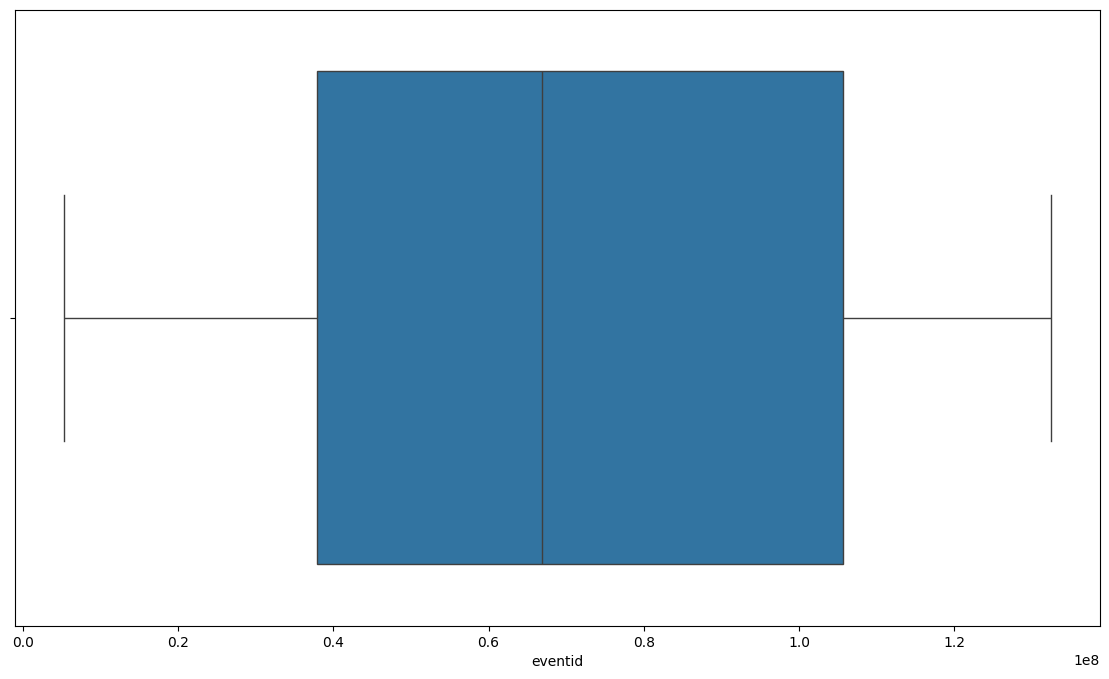

 ------------------ 


'Value counts of event_start'

event_start
2022-10-27 07:50:35.000    10
2022-10-07 20:16:07.700     9
2022-11-14 11:45:18.800     9
2019-10-04 16:13:30.000     8
2021-09-19 02:48:21.000     8
2022-05-17 18:15:50.300     7
Name: count, dtype: int64

 ------------------ 


'Least used values in event_start column: '

event_start
2019-06-07 10:01:16.500    1
2019-02-25 21:24:40.800    1
2019-02-25 06:19:52.500    1
2019-02-25 14:27:20.000    1
2019-02-25 16:17:18.500    1
Name: count, dtype: int64

 ------------------ 


'Value counts of event_end'

event_end
2021-07-29 20:23:07.300    8
2021-07-21 12:04:16.200    7
2023-07-12 05:18:47.100    6
2019-08-10 20:02:04.900    6
2022-10-07 20:16:10.200    6
2022-11-14 11:45:20.700    6
Name: count, dtype: int64

 ------------------ 


'Least used values in event_end column: '

event_end
2019-10-11 15:32:08.500    1
2019-08-15 04:34:18.800    1
2019-08-15 05:58:13.200    1
2019-08-15 04:57:19.000    1
2019-08-15 13:38:03.000    1
Name: count, dtype: int64

 ------------------ 


'Value counts of duration_seconds'

duration_seconds
6.0    63361
1.1    52461
7.0    52233
1.2    48623
1.3    44458
8.0    43985
Name: count, dtype: int64

 ------------------ 


'Least used values in duration_seconds column: '

duration_seconds
67.1    1
79.9    1
21.8    1
57.1    1
89.9    1
Name: count, dtype: int64

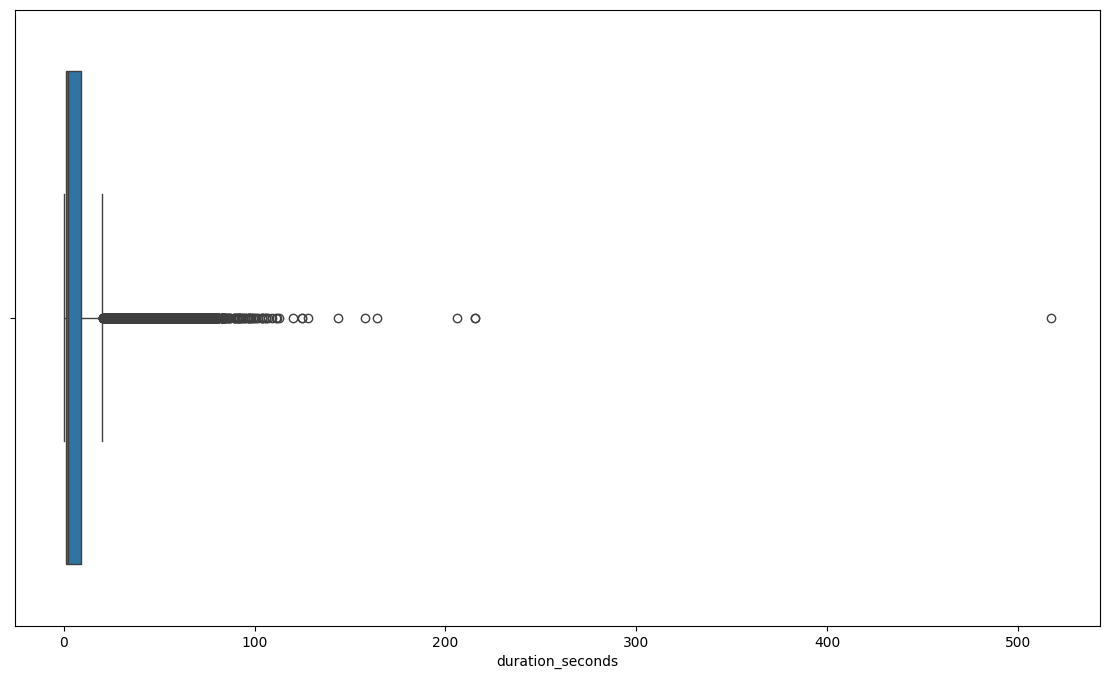

 ------------------ 


'Value counts of latitude'

latitude
51.58178    2764
51.58176    2532
51.58179    2412
51.58175    2124
51.58177    2000
51.57175    1969
Name: count, dtype: int64

 ------------------ 


'Least used values in latitude column: '

latitude
51.538070    1
51.565624    1
51.549330    1
51.618225    1
51.618767    1
Name: count, dtype: int64

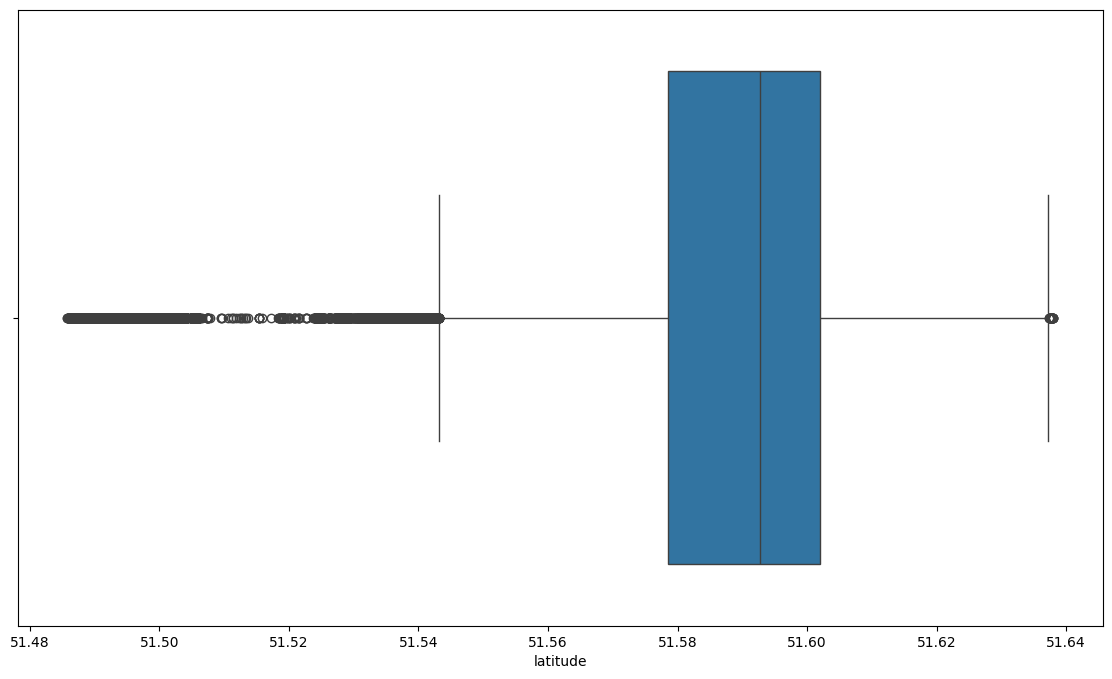

 ------------------ 


'Value counts of longitude'

longitude
4.82120    360
4.77035    344
4.74904    304
4.82181    302
4.82182    298
4.82180    277
Name: count, dtype: int64

 ------------------ 


'Least used values in longitude column: '

longitude
4.716968    1
4.808452    1
4.717577    1
4.727375    1
4.668099    1
Name: count, dtype: int64

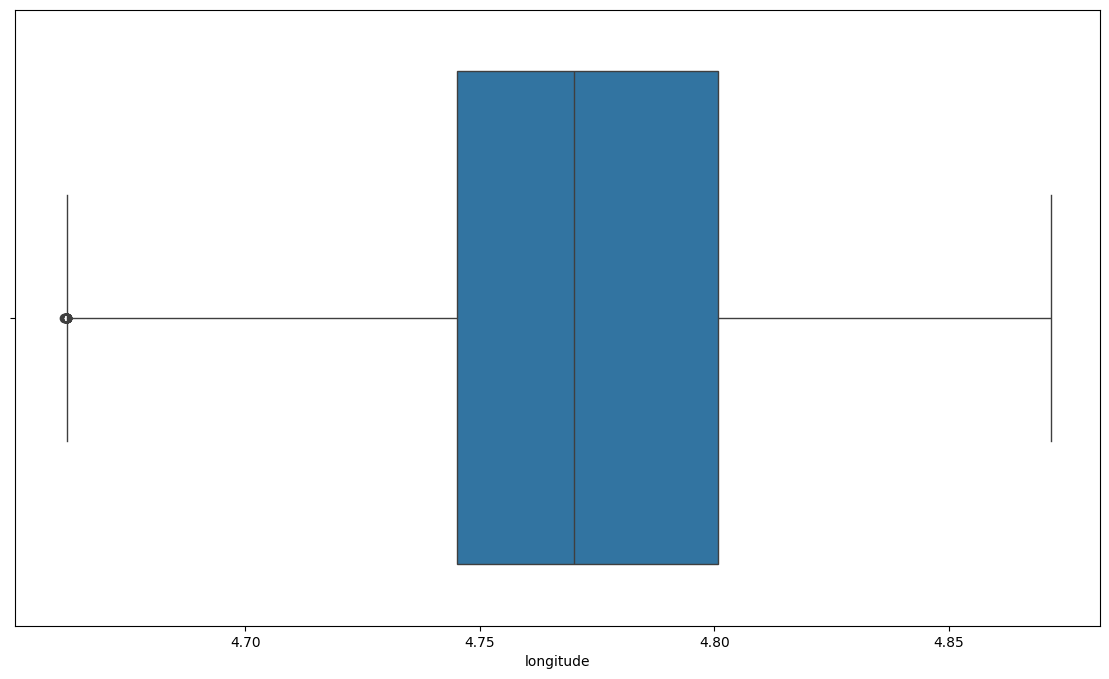

 ------------------ 


'Value counts of speed_kmh'

speed_kmh
62.764416    61499
41.842945    60315
64.373760    44865
28.968191    31586
27.358849    30738
32.186880    28019
Name: count, dtype: int64

 ------------------ 


'Least used values in speed_kmh column: '

speed_kmh
67.370510     1
9.727216      1
56.311290     1
100.886566    1
74.293320     1
Name: count, dtype: int64

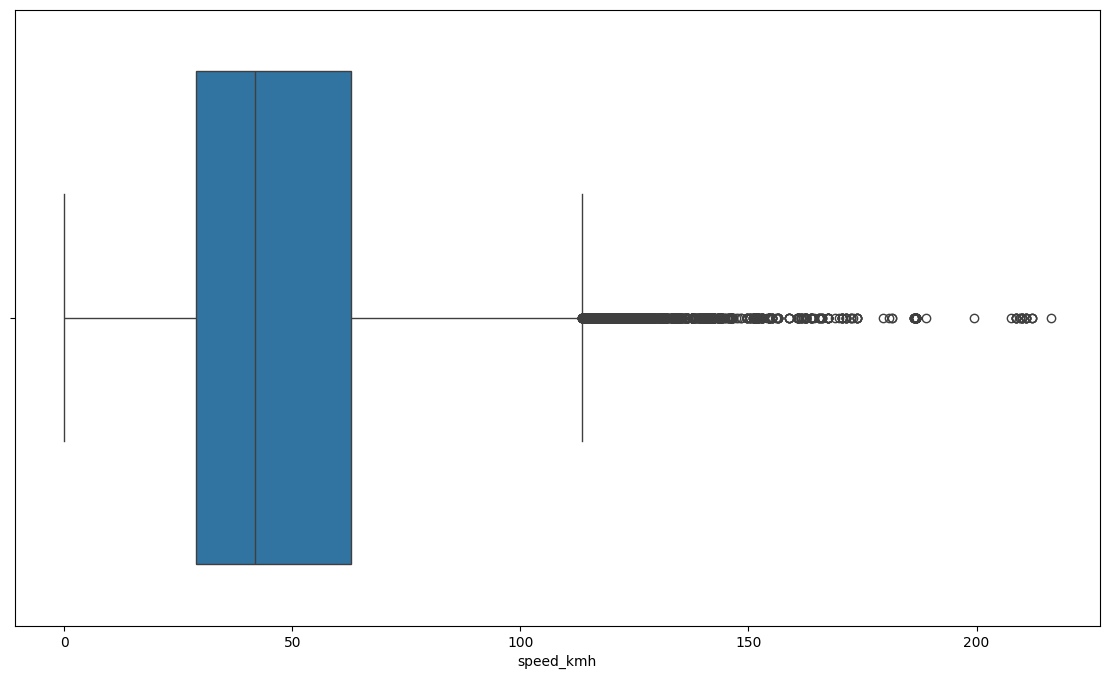

 ------------------ 


'Value counts of end_speed_kmh'

end_speed_kmh
41.842945    60501
62.764416    59211
64.373760    41898
28.968191    32388
27.358849    30021
32.186880    29518
Name: count, dtype: int64

 ------------------ 


'Least used values in end_speed_kmh column: '

end_speed_kmh
77.421730    1
55.958492    1
47.426480    1
16.851627    1
50.356888    1
Name: count, dtype: int64

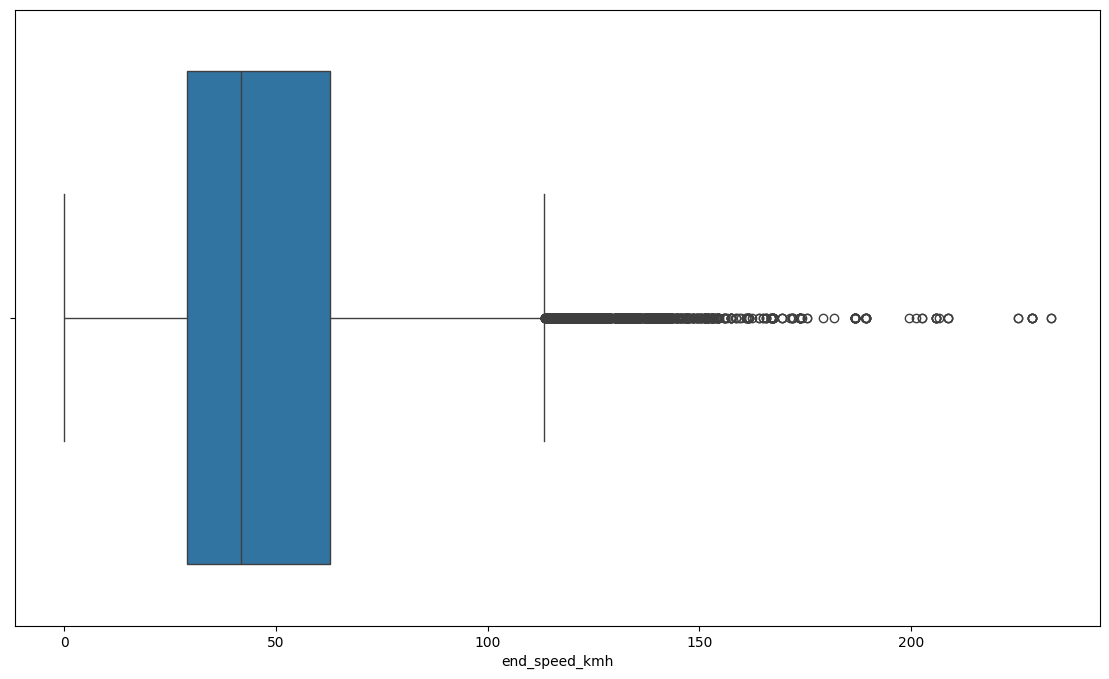

 ------------------ 


'Value counts of maxwaarde'

maxwaarde
0.753173     43284
0.778922     36663
0.729033     33607
0.804672     31215
65.983100    27075
0.703283     24771
Name: count, dtype: int64

 ------------------ 


'Least used values in maxwaarde column: '

maxwaarde
88.578150    1
87.944540    1
59.652100    1
58.381294    1
41.889670    1
Name: count, dtype: int64

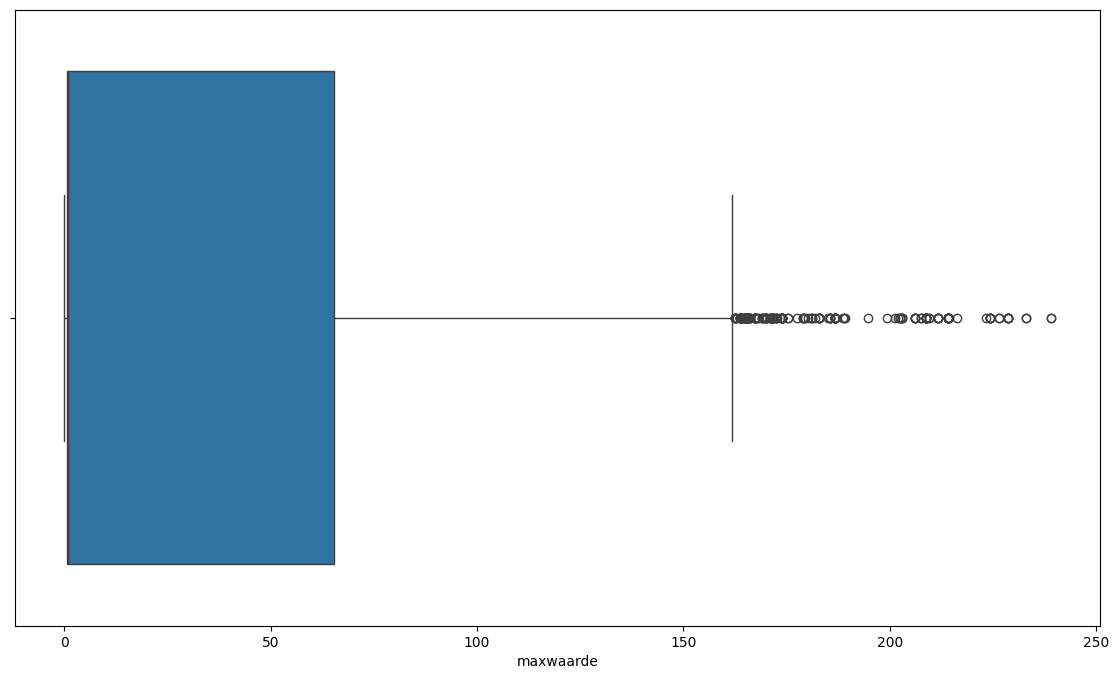

 ------------------ 


'Value counts of category'

category
harsh cornering    456982
speed              408404
braking             58927
accelerating        40175
Name: count, dtype: int64

 ------------------ 


'Least used values in category column: '

category
accelerating        40175
braking             58927
speed              408404
harsh cornering    456982
Name: count, dtype: int64

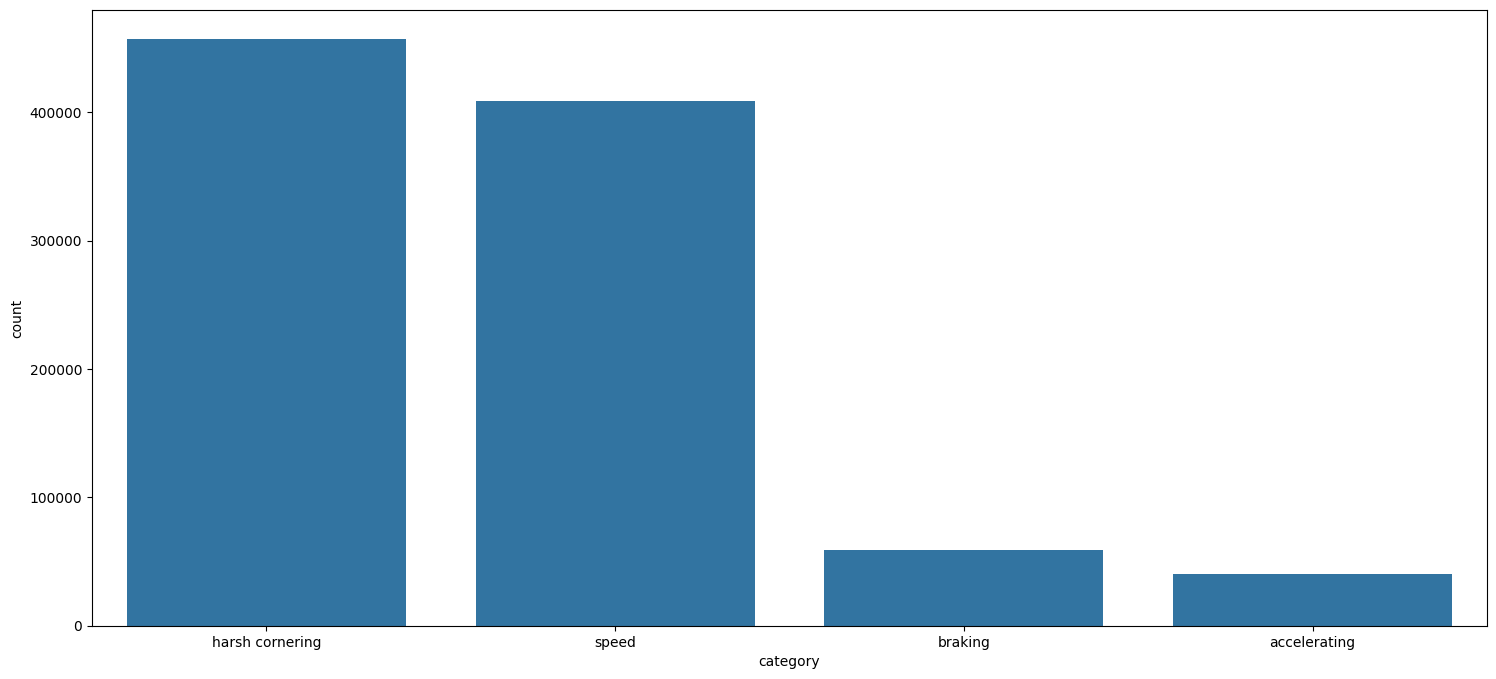

 ------------------ 


'Value counts of incident_severity'

incident_severity
hc1    440243
sp1    374078
hb1     50406
ha1     30473
sp2     29801
hc2      8876
Name: count, dtype: int64

 ------------------ 


'Least used values in incident_severity column: '

incident_severity
hc21     1
hc20     1
hc18     2
hc11     2
hc19    23
Name: count, dtype: int64

 ------------------ 


'Value counts of is_valid'

is_valid
True     820392
False    144096
Name: count, dtype: int64

 ------------------ 


'Least used values in is_valid column: '

is_valid
False    144096
True     820392
Name: count, dtype: int64

 ------------------ 


'Value counts of road_segment_id'

road_segment_id
600893106    19318
231198030    17504
600123821    15683
227197120    14629
600750708    11531
600751226     9344
Name: count, dtype: int64

 ------------------ 


'Least used values in road_segment_id column: '

road_segment_id
600914640    1
228199049    1
228192033    1
219197084    1
227200079    1
Name: count, dtype: int64

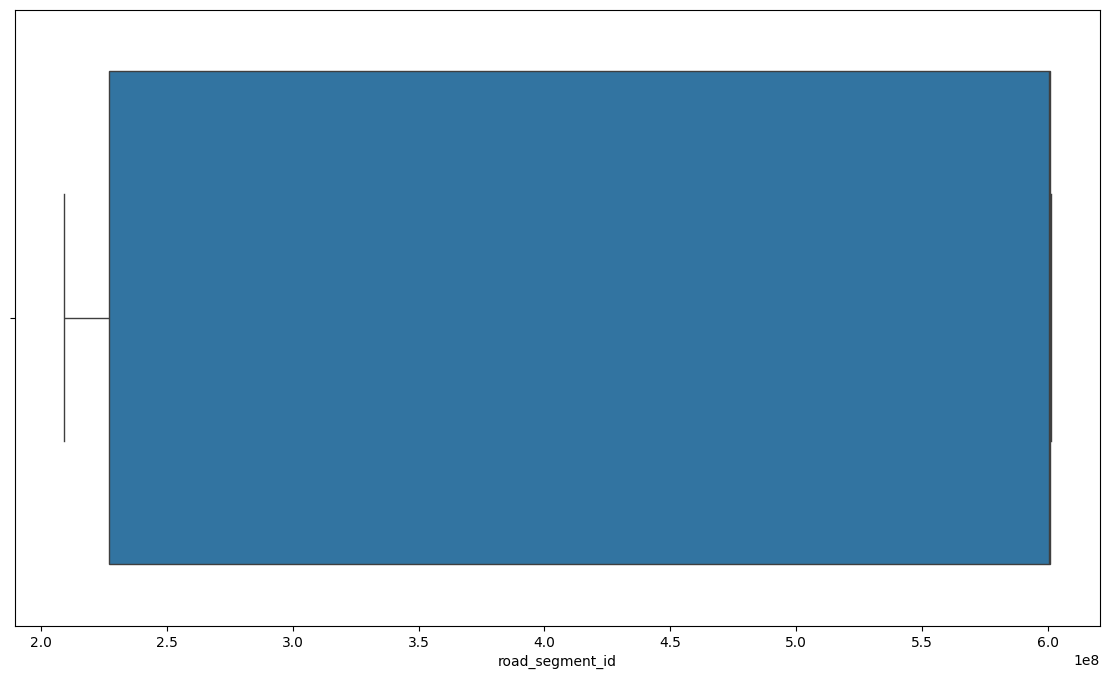

 ------------------ 


'Value counts of road_manager_type'

road_manager_type
g    964488
Name: count, dtype: int64

 ------------------ 


'Least used values in road_manager_type column: '

road_manager_type
g    964488
Name: count, dtype: int64

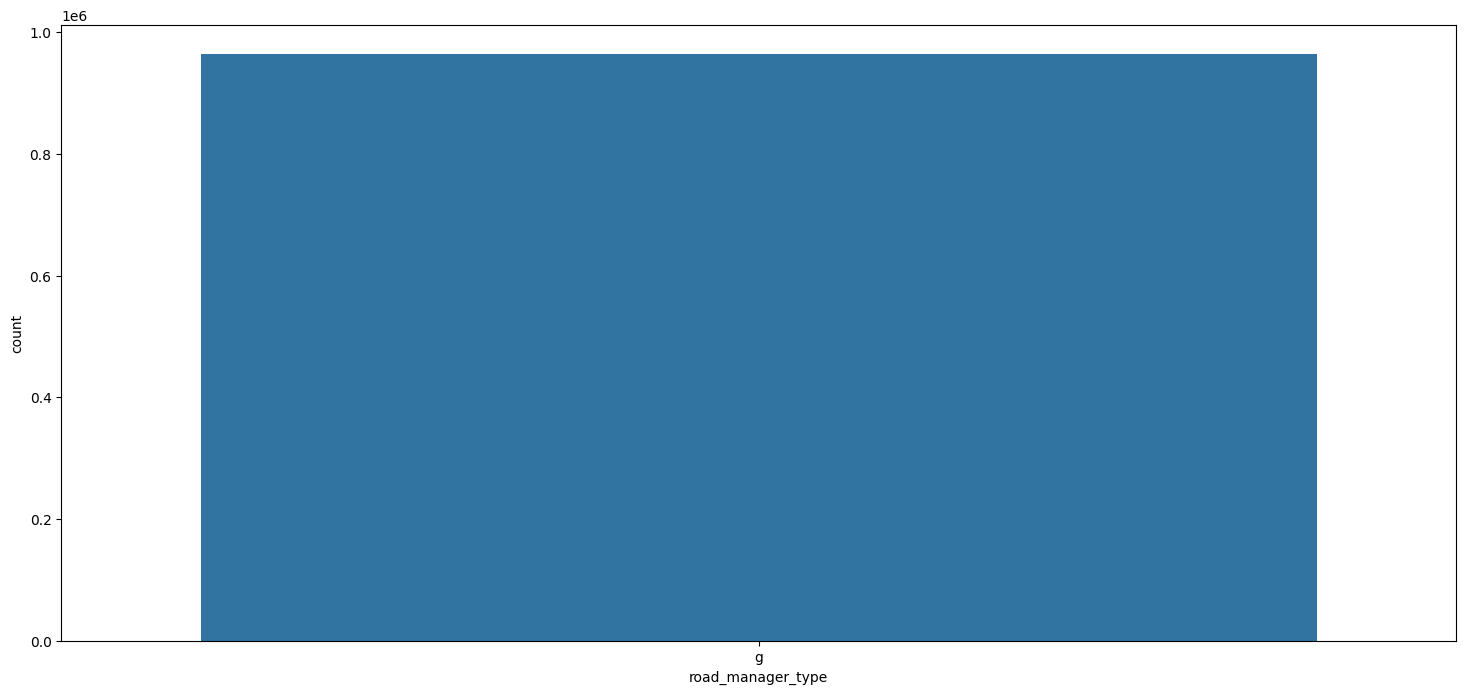

 ------------------ 


'Value counts of road_number'

road_number
    964488
Name: count, dtype: int64

 ------------------ 


'Least used values in road_number column: '

road_number
    964488
Name: count, dtype: int64

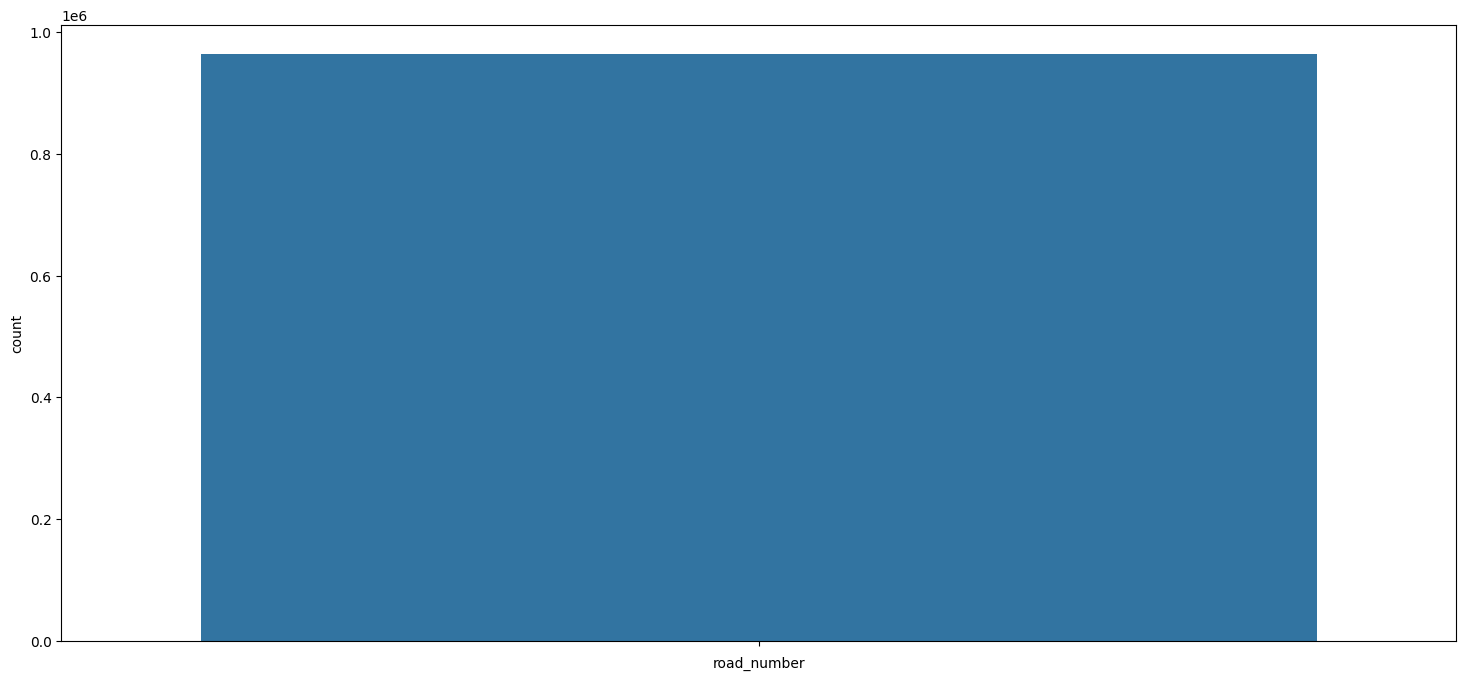

 ------------------ 


'Value counts of road_name'

road_name
franklin rooseveltlaan    73053
graaf engelbertlaan       71242
backer en ruebweg         54888
tilburgseweg              47826
moerlaken                 35200
nieuwe kadijk             34027
Name: count, dtype: int64

 ------------------ 


'Least used values in road_name column: '

road_name
blankenbergestraat         1
mandenmakerstraat          1
albert van huffelstraat    1
amundsenweg                1
stadserf                   1
Name: count, dtype: int64

 ------------------ 


'Value counts of place_name'

place_name
breda          866662
prinsenbeek     50100
teteringen      28741
bavel           14210
ulvenhout        4775
Name: count, dtype: int64

 ------------------ 


'Least used values in place_name column: '

place_name
ulvenhout        4775
bavel           14210
teteringen      28741
prinsenbeek     50100
breda          866662
Name: count, dtype: int64

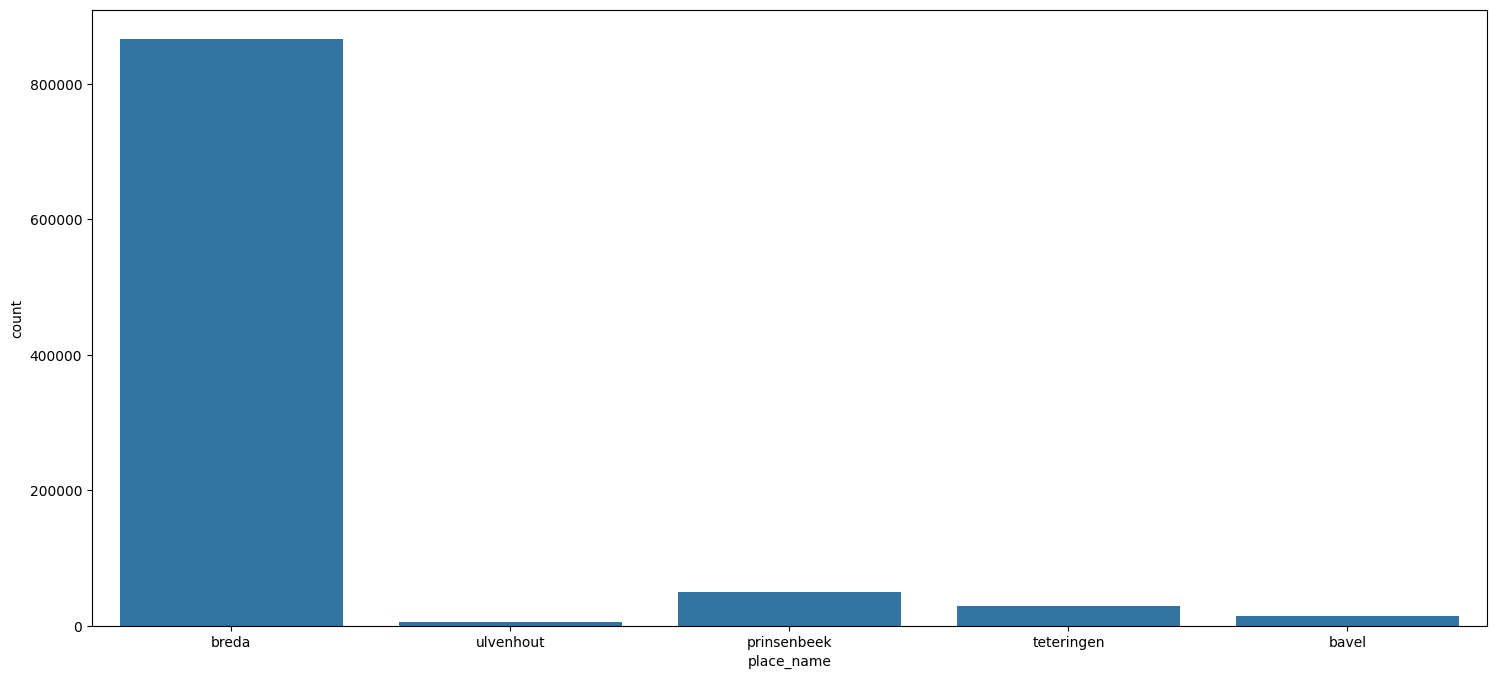

 ------------------ 


'Value counts of municipality_name'

municipality_name
breda    964488
Name: count, dtype: int64

 ------------------ 


'Least used values in municipality_name column: '

municipality_name
breda    964488
Name: count, dtype: int64

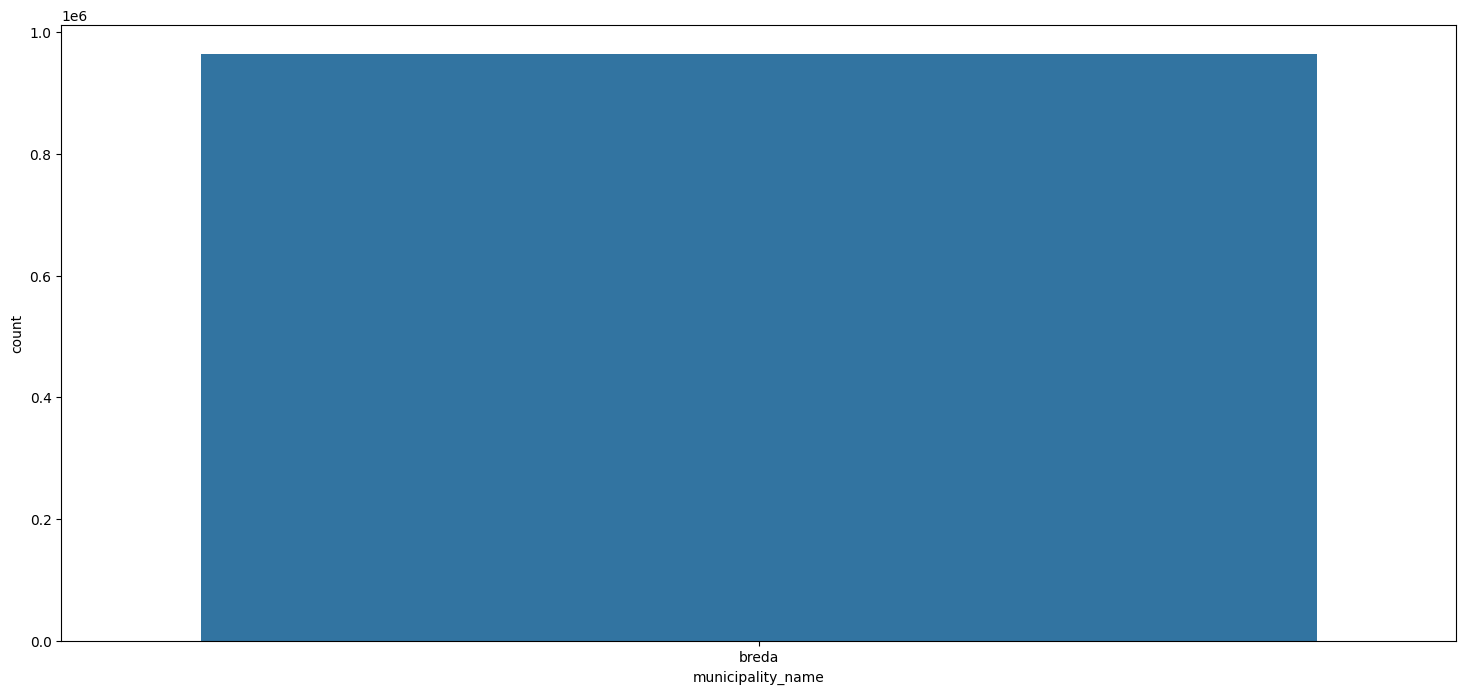

 ------------------ 


'Value counts of road_manager_name'

road_manager_name
breda             964416
ettenleur             52
gilze en rijen        20
Name: count, dtype: int64

 ------------------ 


'Least used values in road_manager_name column: '

road_manager_name
gilze en rijen        20
ettenleur             52
breda             964416
Name: count, dtype: int64

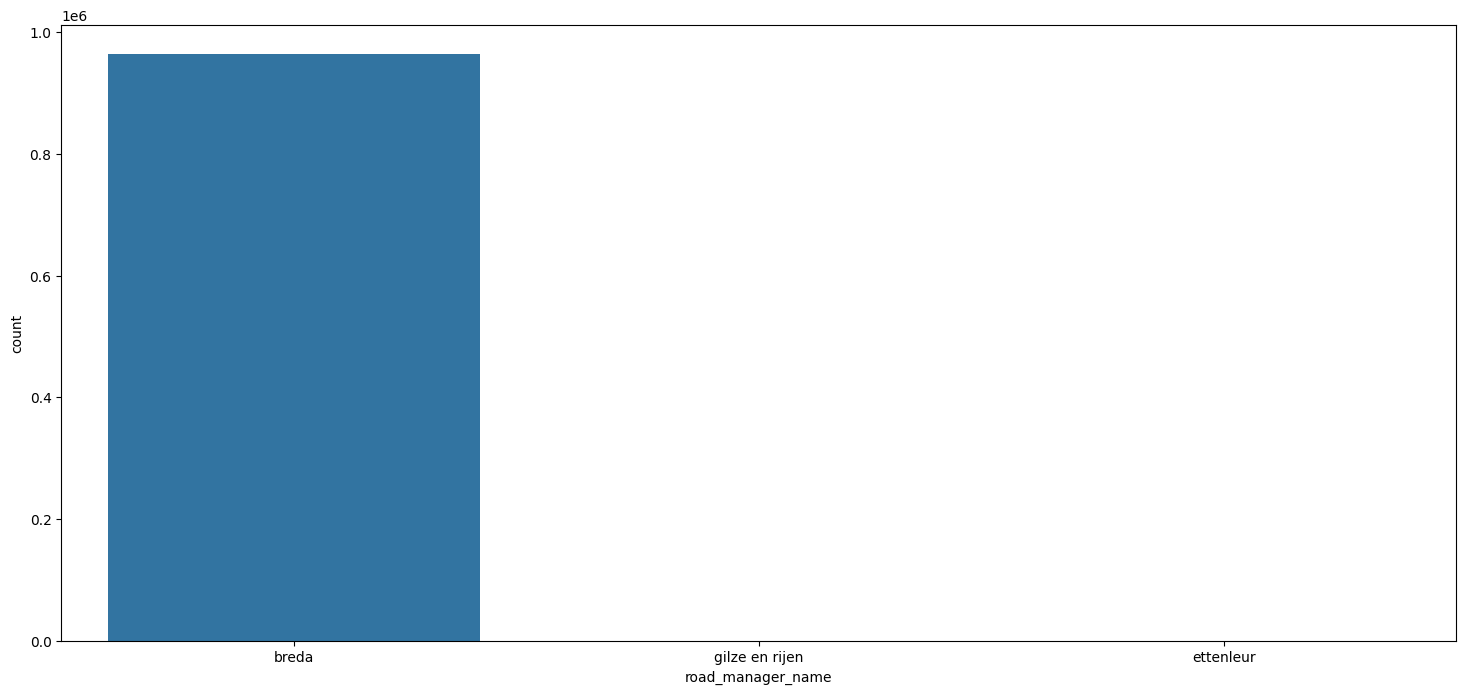

In [13]:
show_dataframe_column_value_counts(safe_driving_df)

In [14]:
def show_duplicated_values_in_column(df , col_name):
    display("Show duplicated values in column: {col_name}")
    total_duplicated_values  = df[col_name].duplicated().sum()
    if total_duplicated_values > 0:
        
        display(f'Duplicated values in {col_name} :')
        display('Number of duplicated values / all rows')
        duplicated_values_perc = round((total_duplicated_values/df[col_name].shape[0]* 100) , 2)
        
        display(f'{total_duplicated_values}/{df[col_name].shape[0]} :  which is around {duplicated_values_perc}%')
        sorted_val_df = df[col_name].value_counts().sort_values(ascending = False)
        sorted_val_df = sorted_val_df[sorted_val_df > 1]

        
        display(sorted_val_df)

        duplicated_values = sorted_val_df.reset_index()[col_name]



        display('Show duplicated column rows :')
        display(df[df[col_name].isin(duplicated_values.to_list())])
    else:
        display('No duplicated values in this column !!!')
        



In [15]:
def show_general_duplicate_values(df,col_name= None):

    if col_name is not None:
        
        show_duplicated_values_in_column(df,col_name)
    else:
        total_duplicated_values  = df.duplicated().sum()
        if total_duplicated_values > 0:
            
            display(f'Duplicated values in df:')
            display('Number of duplicated values / all rows')
            duplicated_values_perc = round((total_duplicated_values/df.shape[0]* 100) , 2)
    
            display(f'{total_duplicated_values}/{df.shape[0]} :  which is around {duplicated_values_perc}%')
        else:
            display('No duplicated values in this dataframe !!!')




def drop_duplicates_in_df(df,columns):
   
    drop_duplicated = False

    if len(columns) > 1:
        for col in columns:
            display('Duplicated values in {columns} after dropping them')
            print_line_break()
            drop_duplicated = df.drop_duplicates(subset=[col] , inplace = True)
            show_duplicated_values_in_column(safe_driving_df ,col )

            print_line_break()
    else:
        display('Duplicated values in {columns} after dropping them')
        print_line_break()
        drop_duplicated = df.drop_duplicates(subset=[*columns] , inplace = True)
        show_duplicated_values_in_column(safe_driving_df ,columns[0] )
    
    return drop_duplicated
    

In [16]:
show_general_duplicate_values(safe_driving_df)

'No duplicated values in this dataframe !!!'

In [17]:
show_duplicated_values_in_column(safe_driving_df , 'eventid')

'Show duplicated values in column: {col_name}'

'Duplicated values in eventid :'

'Number of duplicated values / all rows'

'450/964488 :  which is around 0.05%'

eventid
7792551      4
59736608     4
48336428     3
130560972    3
13587337     3
            ..
6381399      2
70050842     2
129991725    2
13481361     2
107452159    2
Name: count, Length: 404, dtype: int64

'Show duplicated column rows :'

eventid             event_start               event_end  \
4820     68446280 2021-08-15 09:26:09.200 2021-08-15 09:26:10.900   
4821     68446280 2021-08-15 09:26:09.200 2021-08-15 09:26:10.900   
4830     67734650 2021-08-15 11:03:21.900 2021-08-15 11:03:23.800   
4831     67734650 2021-08-15 11:03:21.900 2021-08-15 11:03:23.800   
6155    101990435 2022-10-11 16:23:35.200 2022-10-11 16:23:36.400   
...           ...                     ...                     ...   
962962  101316662 2022-10-07 20:16:07.700 2022-10-07 20:16:11.200   
962963  101316662 2022-10-07 20:16:07.700 2022-10-07 20:16:11.200   
962964  101316662 2022-10-07 20:16:07.700 2022-10-07 20:16:11.200   
963514   78080266 2022-02-04 16:13:58.700 2022-02-04 16:14:00.300   
963515   78080266 2022-02-04 16:13:58.700 2022-02-04 16:14:00.300   

        duration_seconds  latitude  longitude  speed_kmh  end_speed_kmh  \
4820                 1.7  51.60046   4.813352  24.140160      22.530815   
4821                 1.7  51.60046   4.813352  24.140160      22.530815   
4830                 1.9  51.60011   4.740209  28.968191      28.968191   
4831                 1.9  51.60011   4.740209  28.968191      28.968191   
6155                 1.2  51.60046   4.813352  19.656029      20.052040   
...                  ...       ...        ...        ...            ...   
962962               3.5  51.59589   4.719620  24.264048      26.524837   
962963               3.5  51.59589   4.719620  24.264048      26.524837   
962964               3.5  51.59589   4.719620  24.264048      26.524837   
963514               1.6  51.58863   4.735120  26.676044      35.136060   
963515               1.6  51.58863   4.735120  26.676044      35.136060   

        maxwaarde         category incident_severity  is_valid  \
4820     0.729033  harsh cornering               hc1      True   
4821     0.729033  harsh cornering               hc1      True   
4830     0.703283  harsh cornering               hc1     False   
4831     0.703283  harsh cornering               hc1     False   
6155     0.682362  harsh cornering               hc1      True   
...           ...              ...               ...       ...   
962962   0.000000  harsh cornering              hc13     False   
962963   0.000000  harsh cornering              hc13     False   
962964   0.000000  harsh cornering              hc13     False   
963514   0.733861  harsh cornering               hc1      True   
963515   0.733861  harsh cornering               hc1      True   

        road_segment_id road_manager_type road_number      road_name  \
4820          600893311                 g              nieuwe kadijk   
4821          600893312                 g              nieuwe kadijk   
4830          600749942                 g                  veldsteen   
4831          220202049                 g                  veldsteen   
6155          600893311                 g              nieuwe kadijk   
...                 ...               ...         ...            ...   
962962        217201012                 g                  plantsoen   
962963        217202030                 g                  middenweg   
962964        217201024                 g                  haverdijk   
963514        601074880                 g                  baanzicht   
963515        601074879                 g                  baanzicht   

         place_name municipality_name road_manager_name  
4820     teteringen             breda             breda  
4821     teteringen             breda             breda  
4830          breda             breda             breda  
4831          breda             breda             breda  
6155     teteringen             breda             breda  
...             ...               ...               ...  
962962  prinsenbeek             breda             breda  
962963  prinsenbeek             breda             breda  
962964  prinsenbeek             breda             breda  
963514        breda             breda     

In [18]:
show_duplicated_values_in_column(safe_driving_df , 'event_start')

'Show duplicated values in column: {col_name}'

'Duplicated values in event_start :'

'Number of duplicated values / all rows'

'16852/964488 :  which is around 1.75%'

event_start
2022-10-27 07:50:35.000    10
2022-10-07 20:16:07.700     9
2022-11-14 11:45:18.800     9
2019-10-04 16:13:30.000     8
2021-09-19 02:48:21.000     8
                           ..
2022-05-06 19:04:56.000     2
2020-01-22 06:16:00.000     2
2023-03-04 11:06:46.600     2
2020-01-22 18:26:28.000     2
2020-03-24 13:20:11.200     2
Name: count, Length: 13122, dtype: int64

'Show duplicated column rows :'

eventid             event_start               event_end  \
31       61864194 2021-04-10 10:20:58.100 2021-04-10 10:21:16.100   
76       62573377 2021-04-10 13:43:10.100 2021-04-10 13:43:11.200   
77       61565414 2021-04-10 09:54:35.000 2021-04-10 09:54:47.000   
112      62434514 2021-04-10 13:26:27.000 2021-04-10 13:26:34.000   
139      62573388 2021-04-10 13:43:10.100 2021-04-10 13:43:11.200   
...           ...                     ...                     ...   
964165  100134529 2022-09-11 09:40:03.000 2022-09-11 09:40:09.000   
964239  100053049 2022-09-11 11:27:56.400 2022-09-11 11:28:01.000   
964241  100049607 2022-09-11 08:36:02.000 2022-09-11 08:36:09.000   
964477   61864195 2021-04-10 10:20:58.100 2021-04-10 10:21:09.100   
964487   62434515 2021-04-10 13:26:27.000 2021-04-10 13:26:33.000   

        duration_seconds  latitude  longitude  speed_kmh  end_speed_kmh  \
31                  18.0  51.60948   4.672795  83.685890      72.420480   
76                   1.1  51.60216   4.724720  55.800090      53.690490   
77                  12.0  51.59665   4.799594  90.123260      69.201790   
112                  7.0  51.59792   4.799990  71.665320      70.768910   
139                  1.1  51.60216   4.724720  55.800090      53.690490   
...                  ...       ...        ...        ...            ...   
964165               6.0  51.59699   4.799659  62.244100      61.380108   
964239               4.6  51.60421   4.797123   1.440002       0.000000   
964241               7.0  51.57468   4.768874  70.884120      72.684120   
964477              11.0  51.60948   4.672795  83.685890      82.076546   
964487               6.0  51.59792   4.799990  71.665320      73.350120   

        maxwaarde         category incident_severity  is_valid  \
31      83.685890            speed               sp1      True   
76       0.000000  harsh cornering               hc4     False   
77      93.341950            speed               sp1      True   
112     73.350120            speed               sp1      True   
139      0.811109  harsh cornering               hc1     False   
...           ...              ...               ...       ...   
964165  63.648106            speed               sp1      True   
964239   0.000000  harsh cornering               hc7     False   
964241  73.584114            speed               sp2      True   
964477  83.685890            speed               sp2      True   
964487  73.350120            speed               sp2      True   

        road_segment_id road_manager_type road_number             road_name  \
31            600742924                 g                     strijpenseweg   
76            218203057                 g                          elleboog   
77            600754363                 g                       kapittelweg   
112           600754363                 g                       kapittelweg   
139           218203057                 g                          elleboog   
...                 ...               ...         ...                   ...   
964165        600754363                 g                       kapittelweg   
964239        228203055                 g              pieter huysersstraat   
964241        224197142                 g                        langendijk   
964477        600742924                 g                     strijpenseweg   
964487        600754363                 g                       kapittelweg   

         place_name municipality_name road_manager_name  
31      prinsenbeek             breda             breda  
76            breda             breda             breda  
77            breda             breda             breda  
112           breda             breda             breda  
139           breda             breda             breda  
...             ...               ...               ...  
964165        breda             breda             breda  
964239        breda             breda             breda  
964241        br

Since most of the duplicated id constitute the similar or the same accidents and the fraction of duplicated values is relatively insignificant, the duplicated rows will be dropped

In [19]:
drop_duplicates_in_df(safe_driving_df, ['eventid','event_start'])

'Duplicated values in {columns} after dropping them'

 ------------------ 


'Show duplicated values in column: {col_name}'

'No duplicated values in this column !!!'

 ------------------ 


'Duplicated values in {columns} after dropping them'

 ------------------ 


'Show duplicated values in column: {col_name}'

'No duplicated values in this column !!!'

 ------------------ 


Now I will proceed to examine outliers 


In [20]:
safe_driving_df.dtypes

eventid                       int64
event_start          datetime64[ns]
event_end            datetime64[ns]
duration_seconds            float64
latitude                    float64
longitude                   float64
speed_kmh                   float64
end_speed_kmh               float64
maxwaarde                   float64
category                     object
incident_severity            object
is_valid                       bool
road_segment_id               int64
road_manager_type            object
road_number                  object
road_name                    object
place_name                   object
municipality_name            object
road_manager_name            object
dtype: object

In [21]:
def plot_columns(df,columns , plot):
    if len(columns) == 0:
        display('No columns to plot')
        print_line_break()
        print_line_break()
        return

    cols_length  = len(columns)
    
  
    fig, axes = plt.subplots(nrows = cols_length , ncols = 1,figsize=(12, cols_length * 6) , sharex=False, sharey=False)
    print(axes , type(axes))

    if not isinstance(axes,np.ndarray):
        axes = np.array([axes])
        
    for idx,  current_ax in enumerate(axes.flatten()):
        if idx < len(columns):
            
          
            current_col = columns[idx]
            
            current_ax.set_title(f'Column: {current_col}')
            
            plot(x = df[current_col] , ax = current_ax )

    plt.show()
            
    

def plot_numeric_columns(df, columns):
    plot_columns(df,columns,sns.boxplot)

  
def plot_string_columns(df,columns):
    plot_columns(df,columns,sns.countplot)

def plot_bool_columns(df,columns):
    plot_columns(df,columns,sns.countplot)


def plot_value_distributions_in_df(df , columns_to_avoid = [] ):
    
    numeric_cols = [ col  for col in df.columns  if ( 'float' in str(df[col].dtype) or 'int' in str(df[col].dtype)) and  col not in columns_to_avoid ]

    string_cols =   [ col  for col in df.columns  if 'object' == str(df[col].dtype)  and  col not in columns_to_avoid ]

    bool_cols =   [ col  for col in df.columns  if 'bool' == str(df[col].dtype)  and  col not in columns_to_avoid ]

    if numeric_cols:
        

        display('Numerical columns plotted :')
        plot_numeric_columns(df, numeric_cols)
        print_line_break()
        print_line_break()
        print_line_break()

    if string_cols:
        
        display('String columns plotted :')
        plot_string_columns(df, string_cols)
    
        print_line_break()
        print_line_break()
        print_line_break()

    if bool_cols:
        
        
        display('Bool columns plotted :')
        plot_bool_columns(df,bool_cols)




    

    

'Numerical columns plotted :'

[<Axes: > <Axes: > <Axes: > <Axes: >] <class 'numpy.ndarray'>


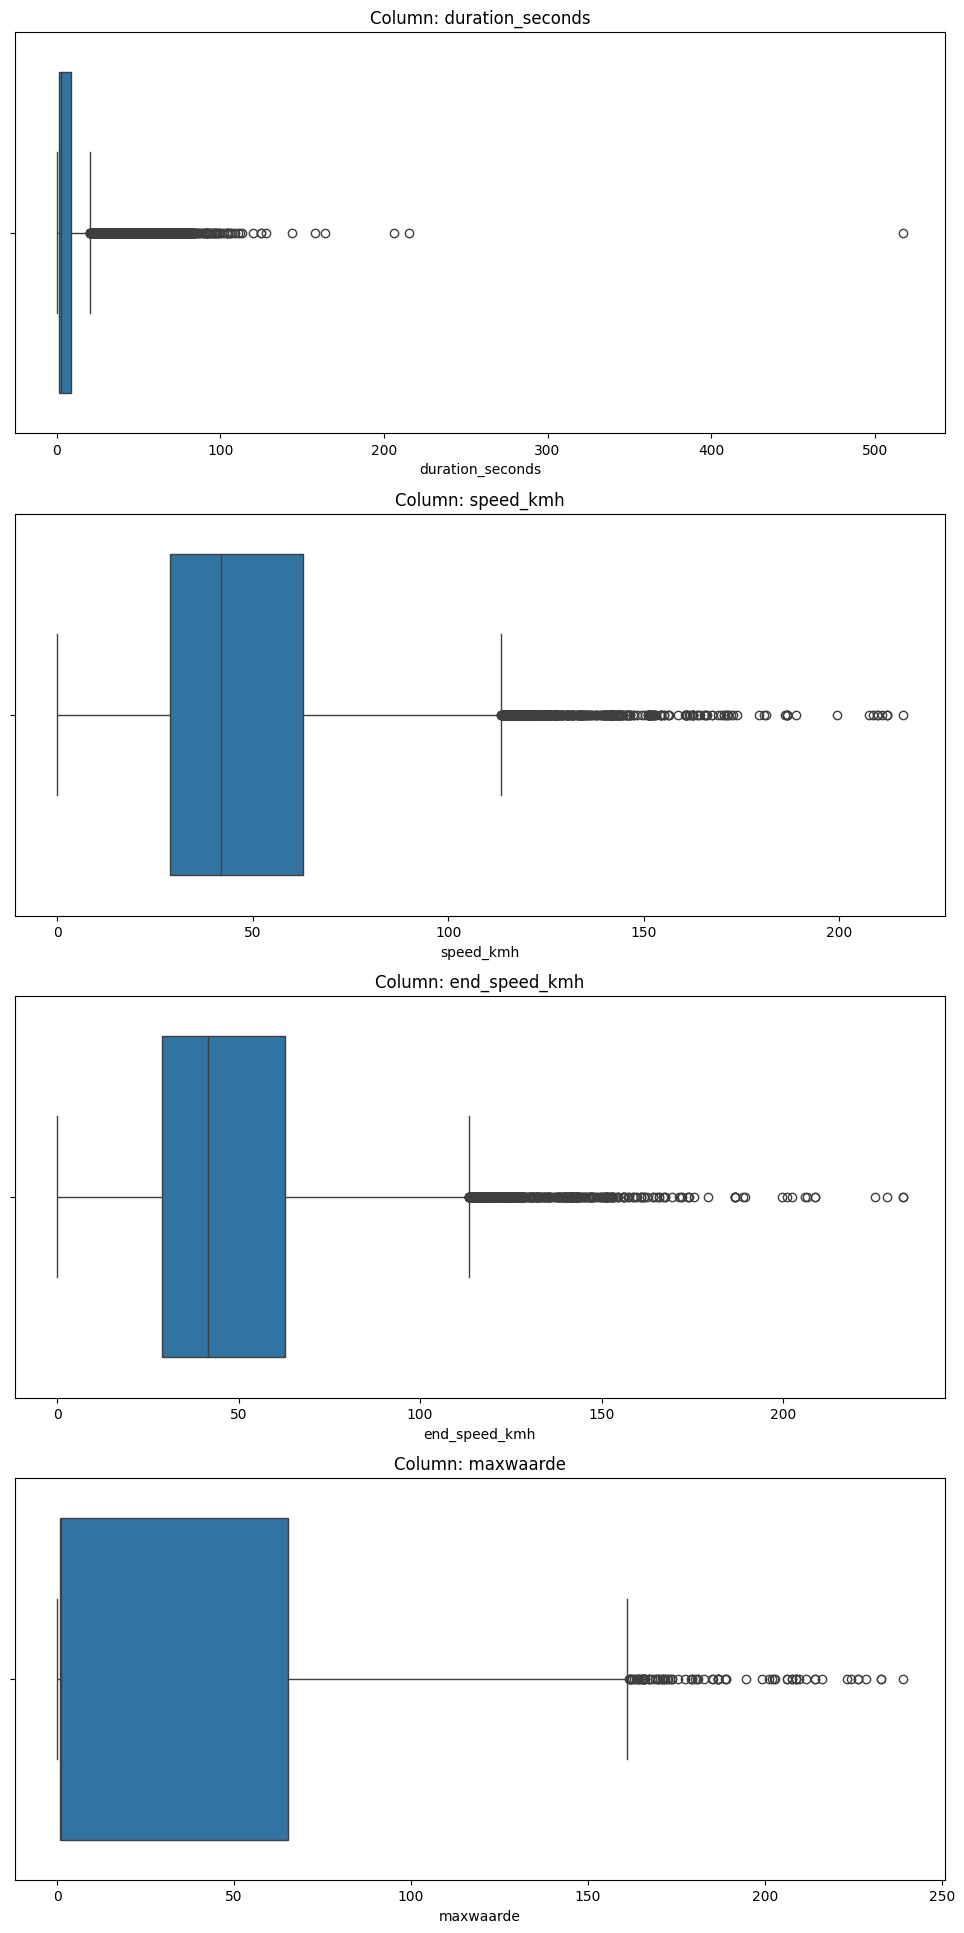

 ------------------ 
 ------------------ 
 ------------------ 


'String columns plotted :'

[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >] <class 'numpy.ndarray'>


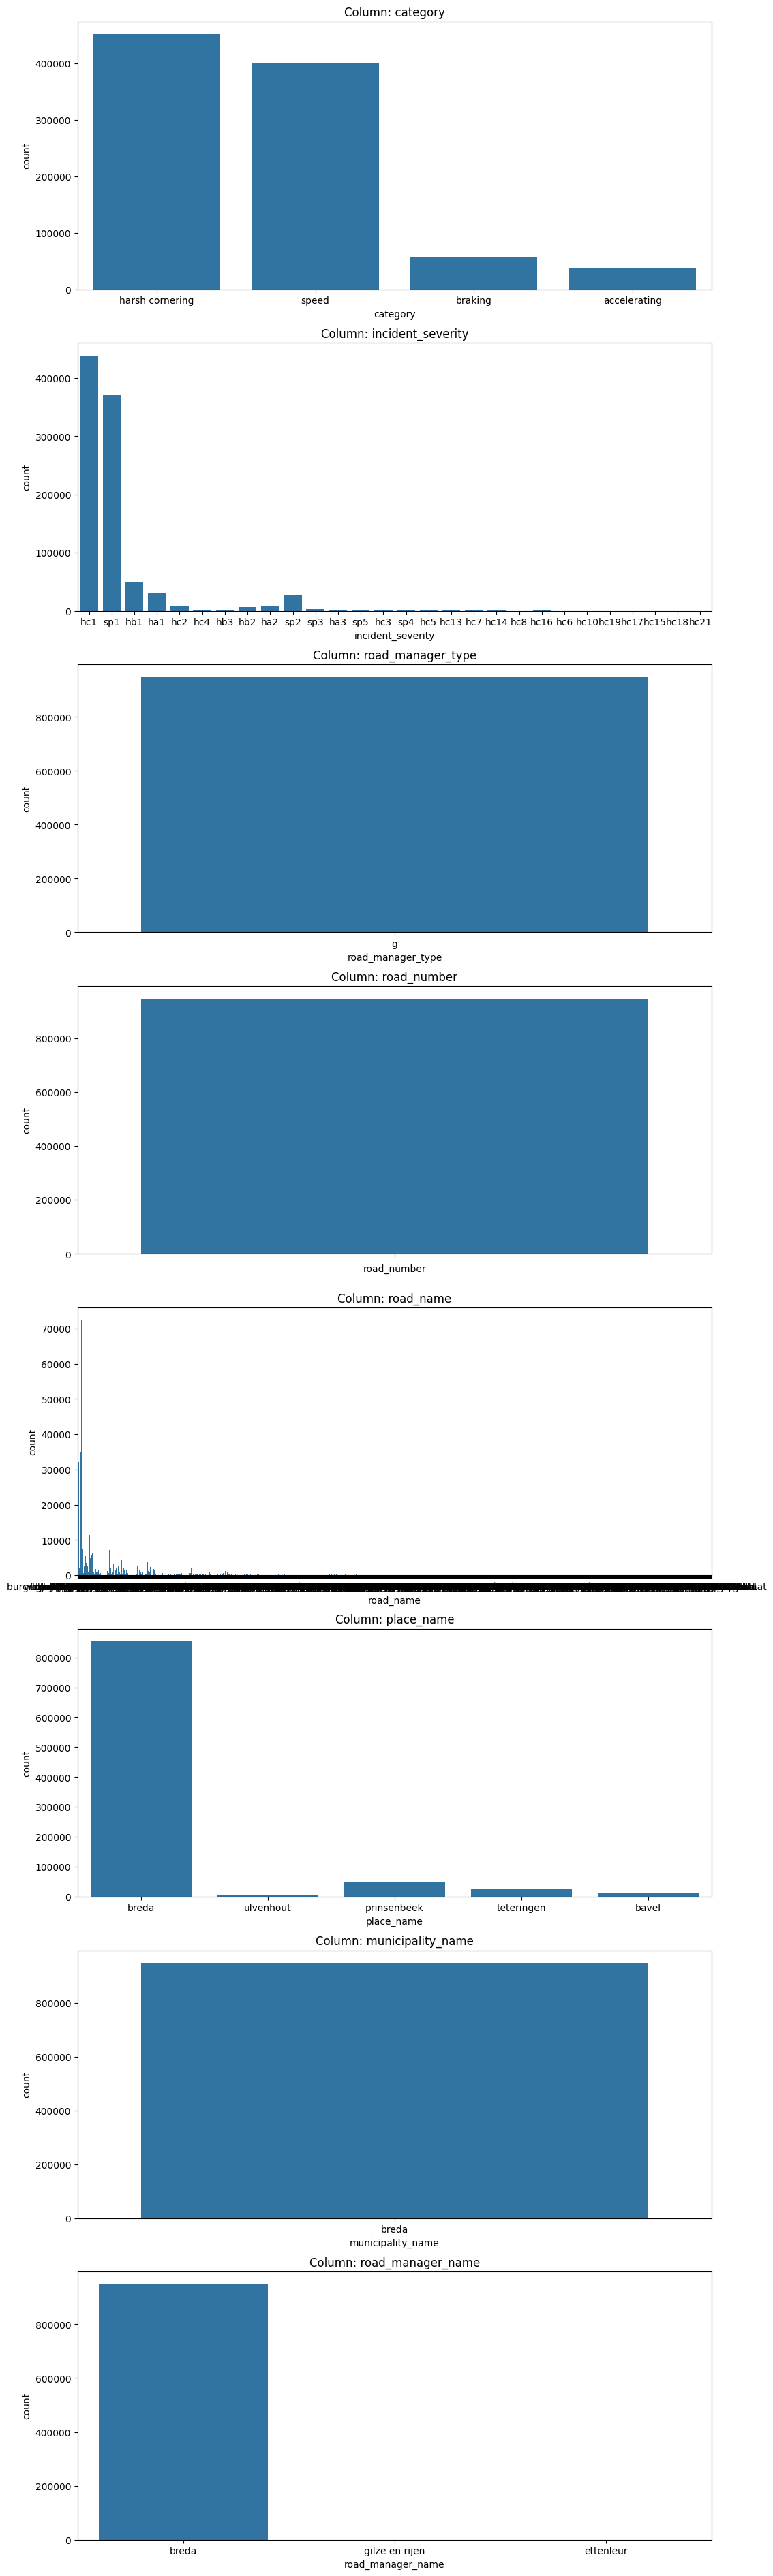

 ------------------ 
 ------------------ 
 ------------------ 


'Bool columns plotted :'

Axes(0.125,0.11;0.775x0.77) <class 'matplotlib.axes._axes.Axes'>


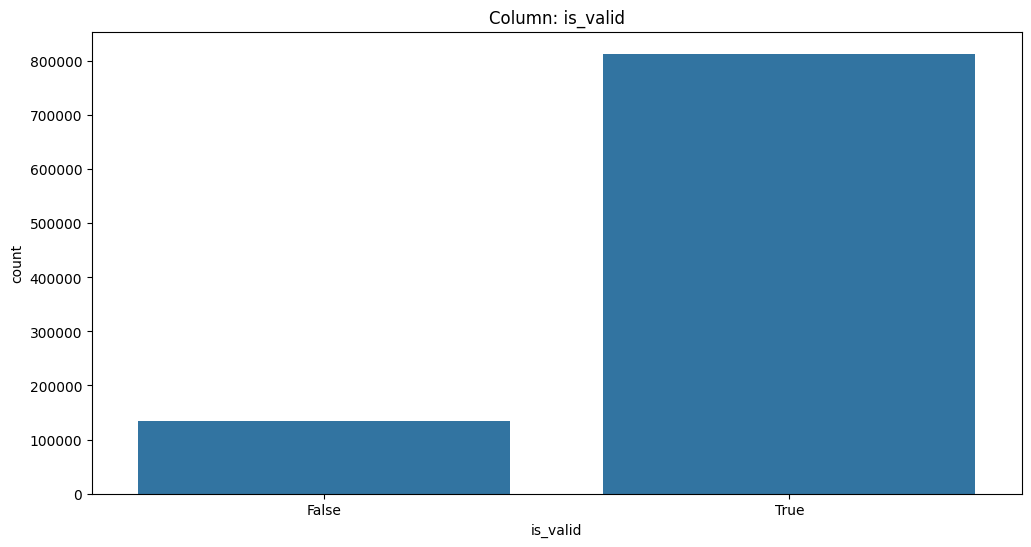

In [22]:
plot_value_distributions_in_df(safe_driving_df , ['eventid', 'road_segment_id', 'latitude', 'longitude'])

In [23]:
def show_outliers_fraction(df, col , Q1,Q3,IQR):
        print_line_break()
        display(f'The fraction of outliers in {col}')
        total_outliers_number_in_col_mask =  (df[col] < Q1 - 1.5 * IQR) | (df[col] >  Q3 + 1.5 * IQR)
        total_outliers_number_in_col  = df[total_outliers_number_in_col_mask].shape[0]
        if total_outliers_number_in_col   <=0:
            display(f'No outliers detected in {col} column')
            return

        print(total_outliers_number_in_col)
        total_outliers_number_in_col_perc =  round( (total_outliers_number_in_col / df.shape[0])  , 2 ) * 100
        display(f'{total_outliers_number_in_col}  / {df.shape[0]} which is around {total_outliers_number_in_col_perc}%')
        print_line_break()

def delete_outliers(df , columns , multiplier = 1.5):
    df_no_outliers = df.copy()
    
    for col in columns:
        Q1 = df_no_outliers[col].quantile(0.25)
        Q3 = df_no_outliers[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - (IQR * multiplier)
        upper_bound = Q3 + (IQR * multiplier)

        show_outliers_fraction(df, col, Q1, Q3, IQR)
        print(f"{col}: Q1={Q1}, Q3={Q3}, IQR={IQR}, Lower Bound={lower_bound}, Upper Bound={upper_bound}")

        df_no_outliers = df_no_outliers[ (df_no_outliers[col] >=lower_bound) & (df_no_outliers[col] <= upper_bound)]

    

    return df_no_outliers

Due to low amount of outliers located in dataset they will be removed using IQR and quantiles lower 0.25 and greater than 0.75

In [24]:
safe_driving_df = delete_outliers(safe_driving_df , ['end_speed_kmh' , 'speed_kmh' , 'duration_seconds'])

 ------------------ 


'The fraction of outliers in end_speed_kmh'

634


'634  / 947636 which is around 0.0%'

 ------------------ 
end_speed_kmh: Q1=28.968191, Q3=62.764416, IQR=33.79622499999999, Lower Bound=-21.726146499999988, Upper Bound=113.45875349999999
 ------------------ 


'The fraction of outliers in speed_kmh'

664


'664  / 947636 which is around 0.0%'

 ------------------ 
speed_kmh: Q1=28.968191, Q3=62.764416, IQR=33.79622499999999, Lower Bound=-21.726146499999988, Upper Bound=113.45875349999999
 ------------------ 


'The fraction of outliers in duration_seconds'

50725


'50725  / 947636 which is around 5.0%'

 ------------------ 
duration_seconds: Q1=1.4, Q3=9.0, IQR=7.6, Lower Bound=-9.999999999999998, Upper Bound=20.4


'Numerical columns plotted :'

[<Axes: > <Axes: > <Axes: > <Axes: >] <class 'numpy.ndarray'>


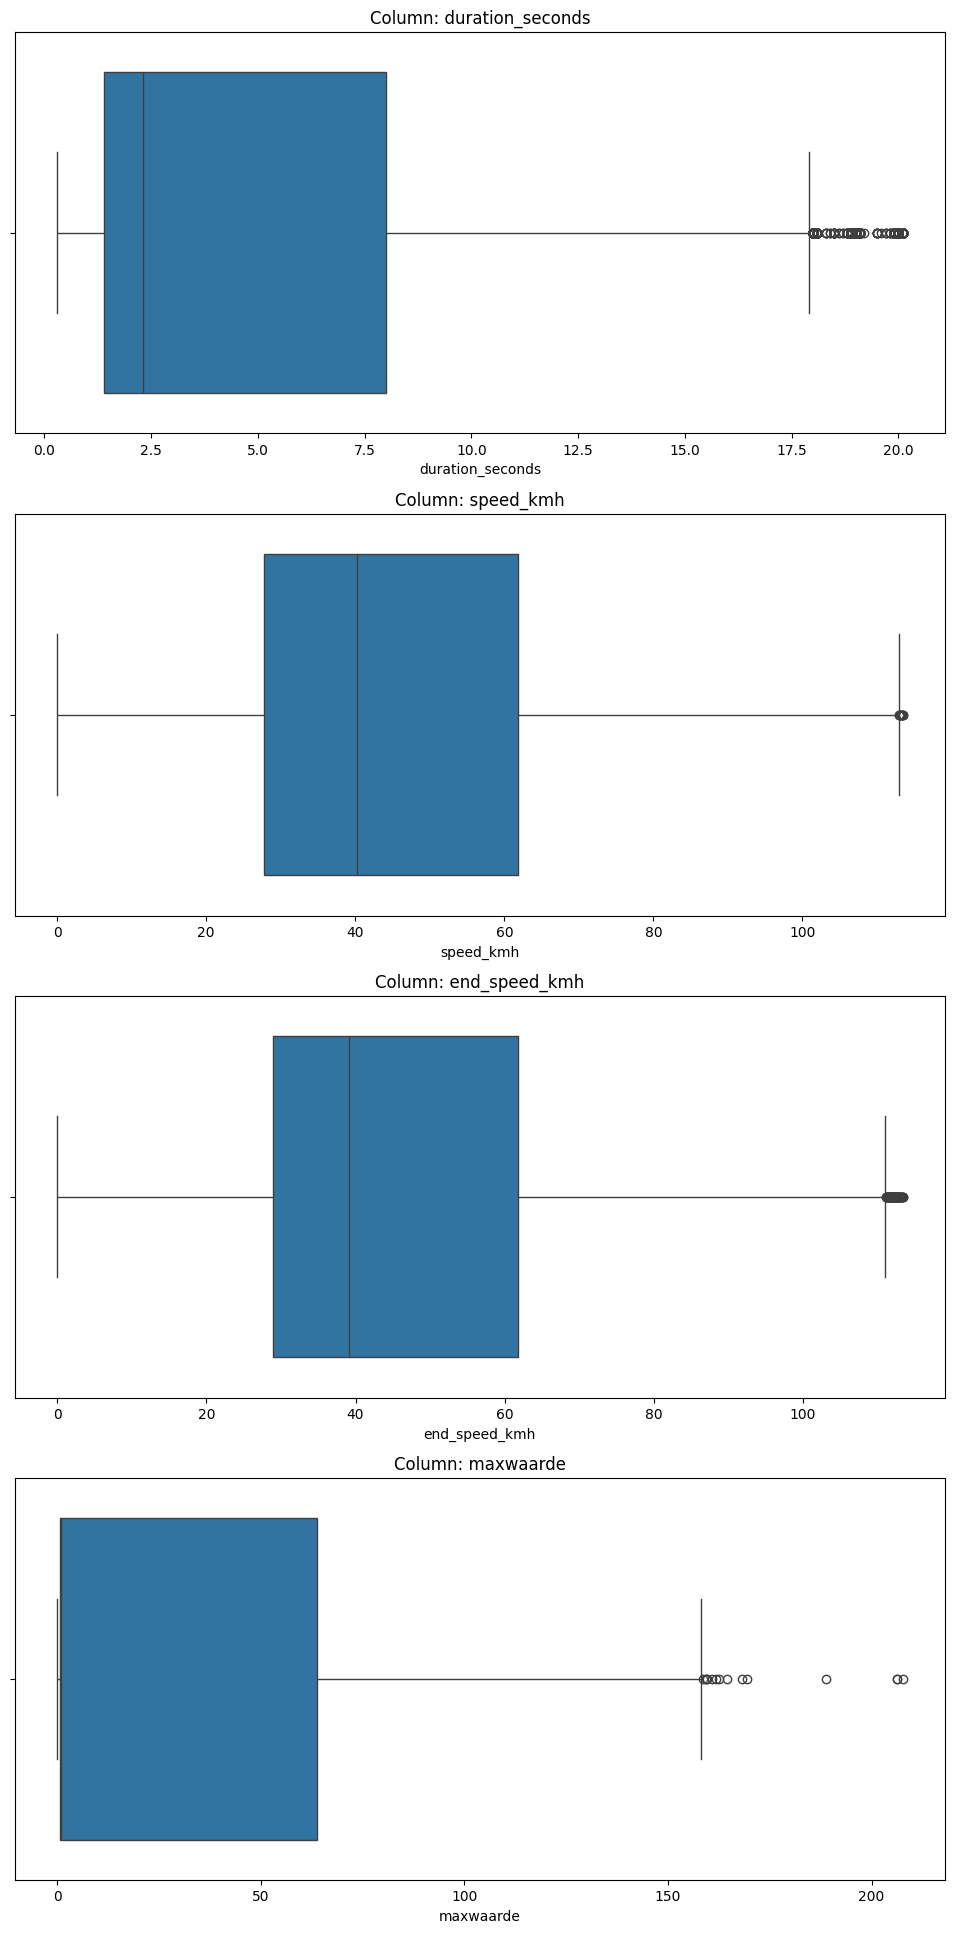

 ------------------ 
 ------------------ 
 ------------------ 


'String columns plotted :'

[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >] <class 'numpy.ndarray'>


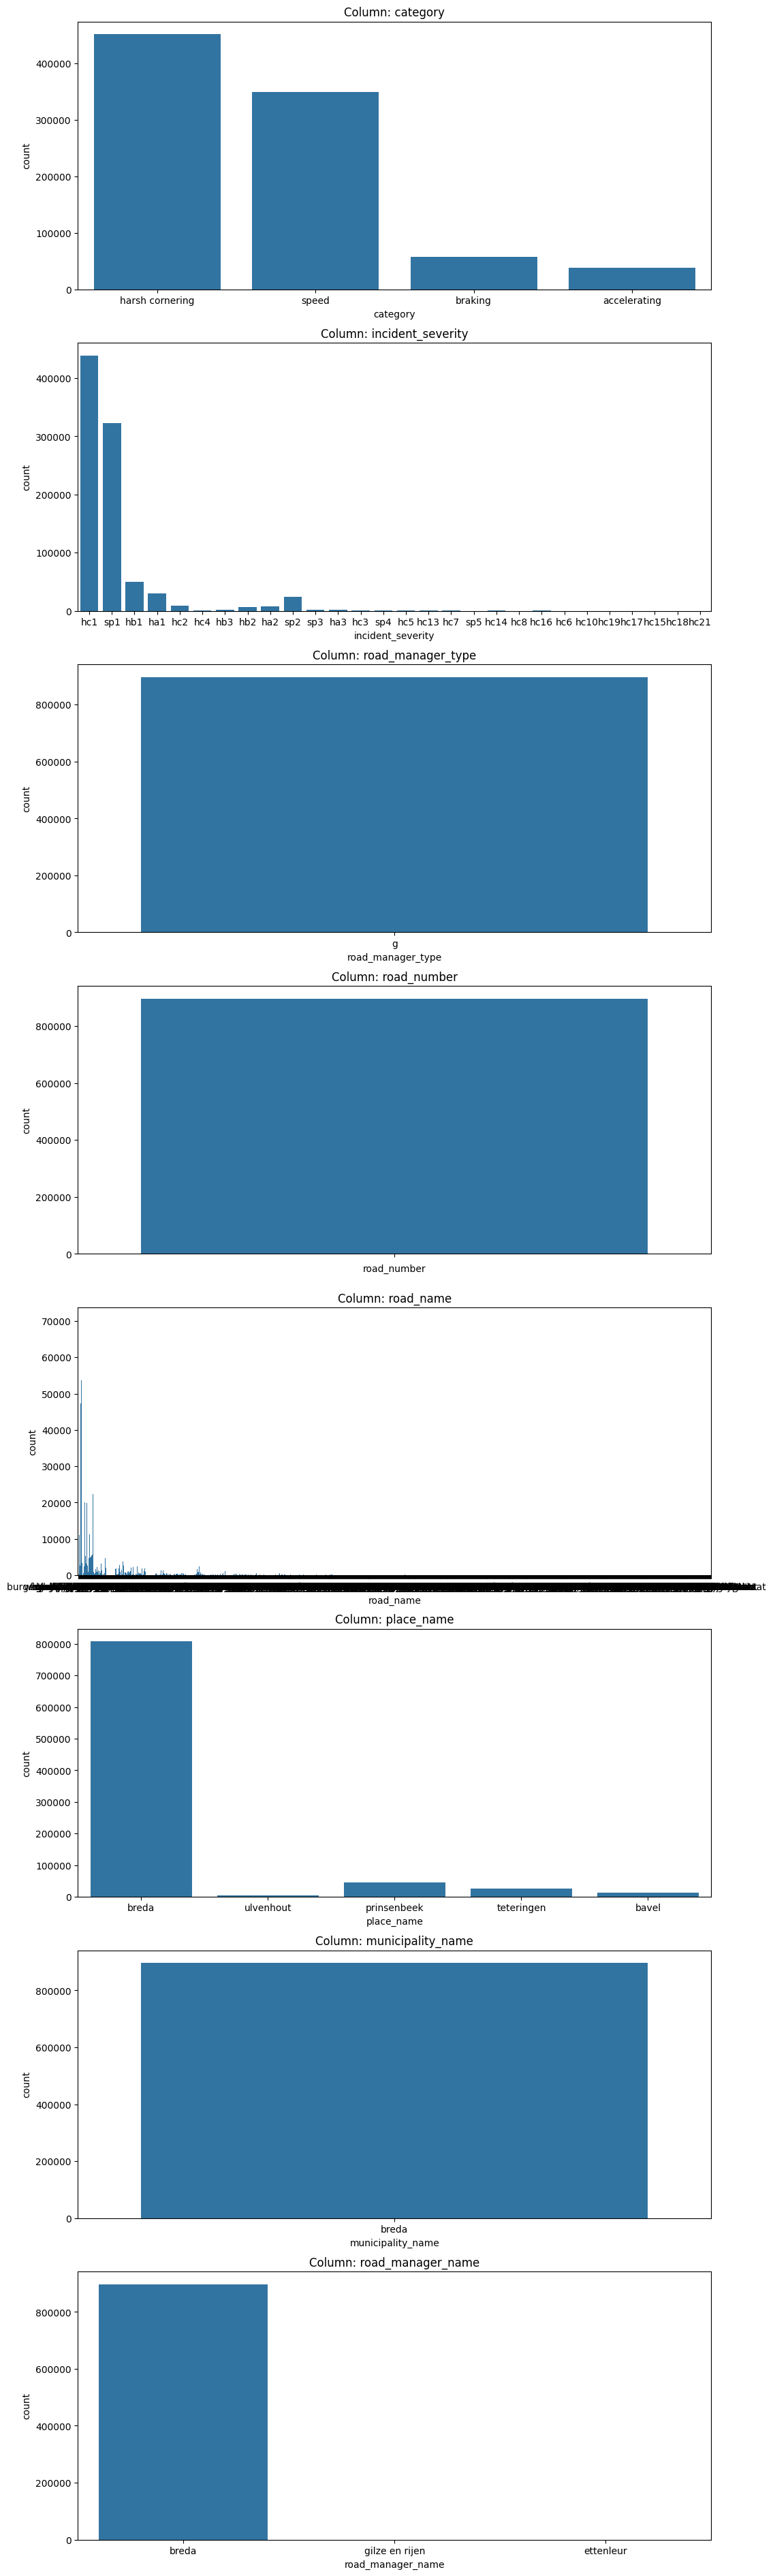

 ------------------ 
 ------------------ 
 ------------------ 


'Bool columns plotted :'

Axes(0.125,0.11;0.775x0.77) <class 'matplotlib.axes._axes.Axes'>


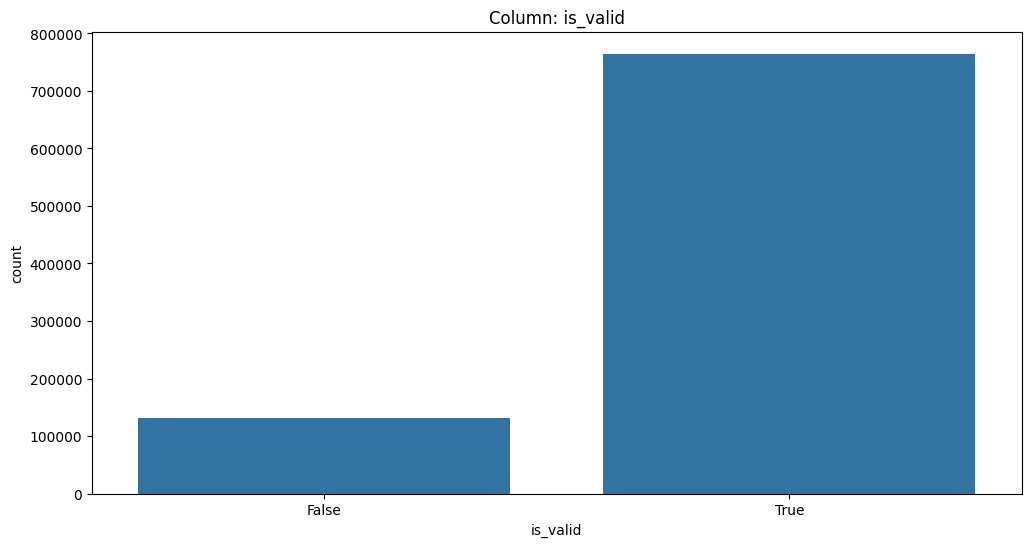

In [25]:
plot_value_distributions_in_df(safe_driving_df , ['eventid', 'road_segment_id', 'latitude', 'longitude'])

is_valid , road_manager_type, road_number,road_manager_name, municipality_name columns does not provide much value therefore they will be dropped


In [26]:
def drop_columns_in_df(df, columns_to_drop):
    cols_drop_len  = len(columns_to_drop)

    for col_to_drop in columns_to_drop:
        if col_to_drop in df.columns:
            
            df.drop(columns=[col_to_drop] , inplace=True)

In [27]:

drop_columns_in_df(safe_driving_df , ['is_valid', 'road_manager_type', 'road_number' , 'road_manager_name', 'municipality_name' , 'place_name'])

### Let's simplify incident_severity column

In [28]:

def convert_column_to_binary(df, columns_with_new_values):
    for key, val  in columns_with_new_values.items():
        col = key
        multiple_values = val['top_values']
       
        new_replace_value = val['new_value']
        
        most_frequent_values = df[col].value_counts().index[0:multiple_values]
        
        df[col] = df[col].apply(lambda row: row if str(row) in most_frequent_values else new_replace_value)


In [29]:
columns_with_new_values_dict = {
    'incident_severity':{
        'new_value':'other incident severities',
         'top_values':2
    },

}

convert_column_to_binary(safe_driving_df, columns_with_new_values_dict)

'Numerical columns plotted :'

[<Axes: > <Axes: > <Axes: > <Axes: >] <class 'numpy.ndarray'>


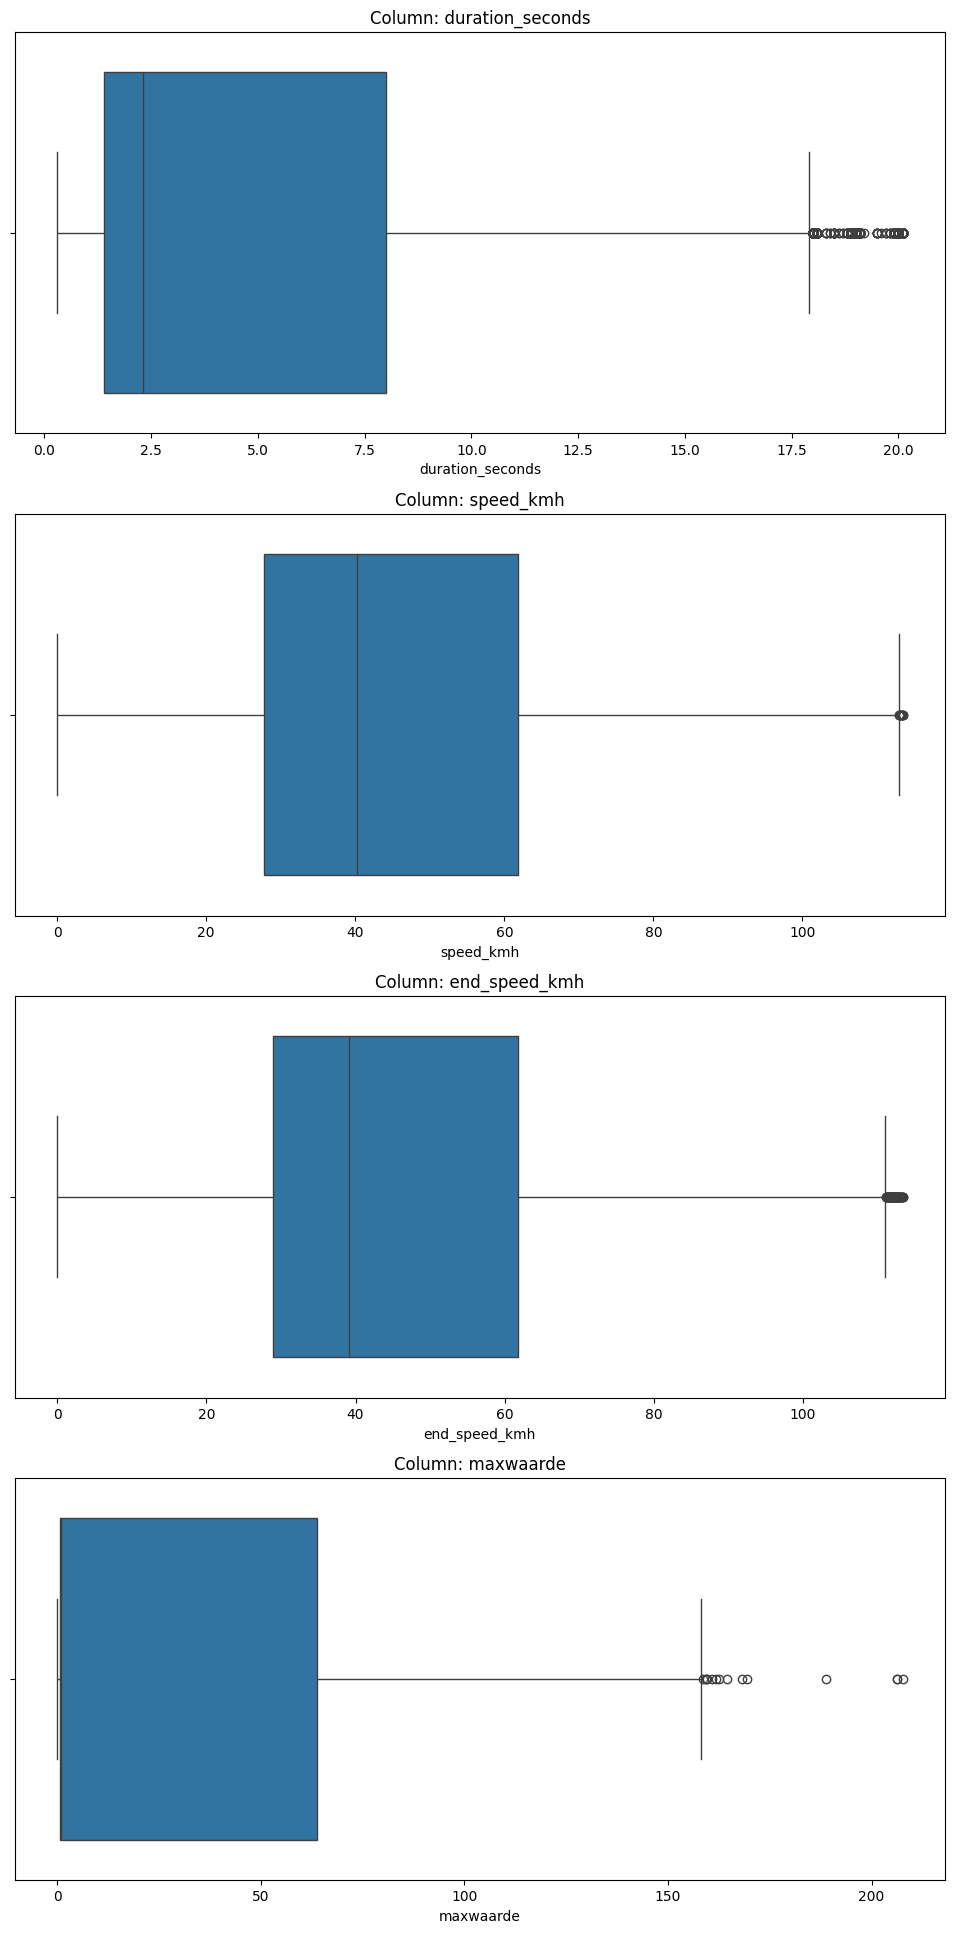

 ------------------ 
 ------------------ 
 ------------------ 


'String columns plotted :'

[<Axes: > <Axes: > <Axes: >] <class 'numpy.ndarray'>


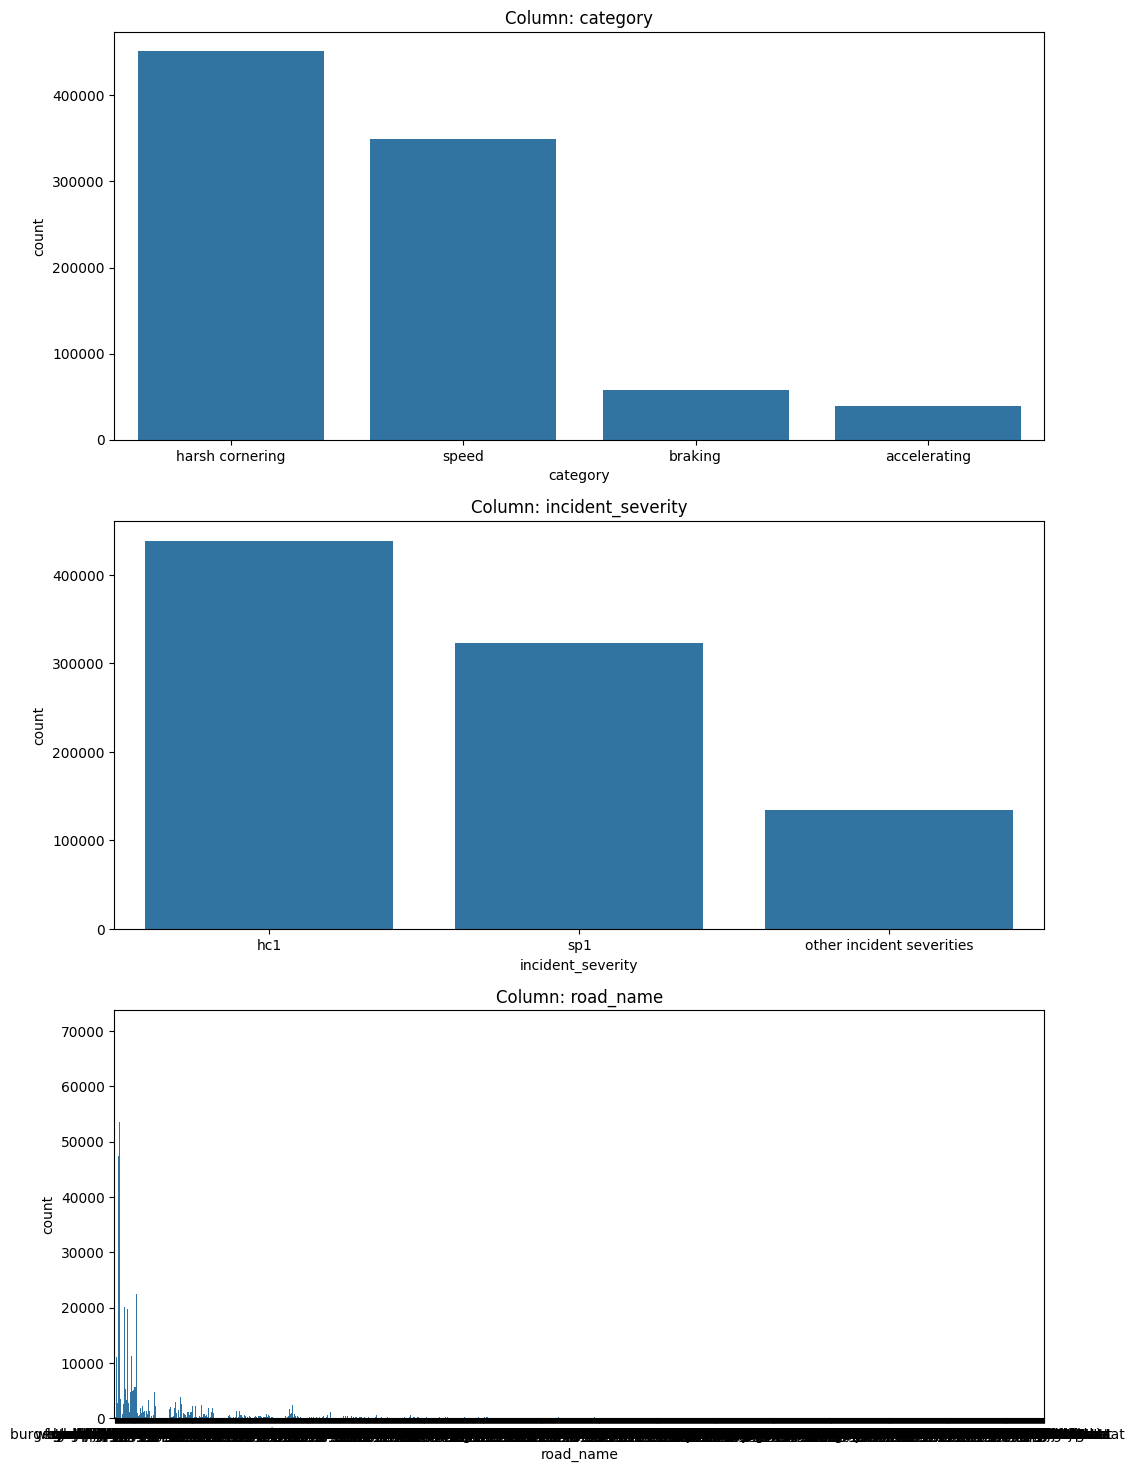

 ------------------ 
 ------------------ 
 ------------------ 


In [30]:
plot_value_distributions_in_df(safe_driving_df , ['eventid', 'road_segment_id', 'latitude', 'longitude'])

Let's proceed with data inconsistencies 

In [31]:
safe_driving_df['incident_severity'].value_counts()

incident_severity
hc1                          438540
sp1                          322858
other incident severities    134790
Name: count, dtype: int64

In [32]:
def clip_numerical_cols(df,columns):
    for col in columns:
        df[col] = df[col].round(2)


def clean_numerical_cols(df):
    numeric_cols = [ col  for col in df.columns  if ( 'float' in str(df[col].dtype) or 'int' in str(df[col].dtype)) ]
    
    for col in numeric_cols:
        df[col] = df[col].abs()
        df[col] = df[col].astype(float)
    

In [33]:
clean_numerical_cols(safe_driving_df)

In [34]:
clip_numerical_cols(safe_driving_df,  ['speed_kmh' , 'end_speed_kmh', 'maxwaarde' ])

There were some cases where initial speed_kmh was 0, we will analyze that



In [35]:
safe_driving_df[safe_driving_df['speed_kmh'] == 0.0]

eventid             event_start               event_end  \
803      72980016.0 2021-10-15 06:17:45.900 2021-10-15 06:17:46.600   
939      75799340.0 2021-12-20 12:27:09.800 2021-12-20 12:27:11.500   
1028     75799350.0 2021-12-20 12:27:09.600 2021-12-20 12:27:11.700   
1050     75799341.0 2021-12-20 12:28:04.400 2021-12-20 12:28:06.600   
1730     41439953.0 2019-12-18 08:54:03.900 2019-12-18 08:54:04.600   
...             ...                     ...                     ...   
962200  106595525.0 2022-12-31 13:17:06.600 2022-12-31 13:17:07.600   
962571  104721608.0 2022-11-28 13:04:29.600 2022-11-28 13:04:30.500   
963128   66818011.0 2021-07-16 23:20:13.700 2021-07-16 23:20:14.700   
963429   78850297.0 2022-02-16 13:01:24.900 2022-02-16 13:01:26.100   
964004  106061412.0 2022-12-21 16:56:35.500 2022-12-21 16:56:44.200   

        duration_seconds   latitude  longitude  speed_kmh  end_speed_kmh  \
803                  0.7  51.601880   4.790570        0.0          12.12   
939                  1.7  51.581654   4.805430        0.0          11.92   
1028                 2.1  51.581654   4.805430        0.0          11.92   
1050                 2.2  51.580597   4.804467        0.0          15.98   
1730                 0.7  51.606140   4.743725        0.0           1.61   
...                  ...        ...        ...        ...            ...   
962200               1.0  51.567940   4.735580        0.0           6.97   
962571               0.9  51.579040   4.805340        0.0           0.23   
963128               1.0  51.601530   4.801550        0.0           8.28   
963429               1.2  51.602660   4.730080        0.0          11.67   
964004               8.7  51.605930   4.817680        0.0           1.61   

        maxwaarde      category          incident_severity  road_segment_id  \
803          0.95  accelerating  other incident severities      600892900.0   
939          1.48  accelerating  other incident severities      600754809.0   
1028         1.48  accelerating  other incident severities      600754809.0   
1050         1.56  accelerating  other incident severities      600754813.0   
1730         1.01  accelerating  other incident severities      220204106.0   
...           ...           ...                        ...              ...   
962200       0.84  accelerating  other incident severities      600749077.0   
962571       1.19  accelerating  other incident severities      600754290.0   
963128       1.53  accelerating  other incident severities      600893097.0   
963429       1.13  accelerating  other incident severities      600892614.0   
964004       0.83  accelerating  other incident severities      600756144.0   

                     road_name  
803              nieuwe kadijk  
939                   heerbaan  
1028                  heerbaan  
1050      claudius prinsenlaan  
1730                 hondsdonk  
...                        ...  
962200         princenhagelaan  
962571  franklin rooseveltlaan  
963128           nieuwe kadijk  
963429       backer en ruebweg  
964004              hoolstraat  

[3444 rows x 13 columns]

These cases have reasonable explanation caused by Accelerating therefore these rows will not be removed

In [36]:
safe_driving_df.describe()

eventid                    event_start  \
count  8.961880e+05                         896188   
mean   6.974055e+07  2021-05-19 17:22:12.823037184   
min    5.345485e+06     2018-01-01 00:18:20.500000   
25%    3.818322e+07  2019-11-02 14:06:38.175000064   
50%    6.718059e+07     2021-07-23 10:46:17.800000   
75%    1.057970e+08  2022-12-16 07:22:21.275000064   
max    1.323910e+08     2024-02-29 23:10:34.500000   
std    3.736806e+07                            NaN   

                           event_end  duration_seconds       latitude  \
count                         896188     896188.000000  896188.000000   
mean   2021-05-19 17:22:17.779347200          4.956310      51.589731   
min       2018-01-01 00:18:28.500000          0.300000      51.485760   
25%    2019-11-02 14:06:40.575000064          1.400000      51.578870   
50%    2021-07-23 10:46:18.950000128          2.300000      51.592740   
75%    2022-12-16 07:22:22.824999936          8.000000      51.601870   
max       2024-02-29 23:10:35.700000         20.100000      51.638050   
std                              NaN          4.724088       0.018057   

           longitude      speed_kmh  end_speed_kmh      maxwaarde  \
count  896188.000000  896188.000000  896188.000000  896188.000000   
mean        4.772486      41.973165      41.954623      25.516969   
min         4.661410       0.000000       0.000000       0.000000   
25%         4.744310      27.780000      28.970000       0.780000   
50%         4.770360      40.230000      39.080000       0.950000   
75%         4.801098      61.850000      61.820000      63.890000   
max         4.871680     113.440000     113.340000     207.610000   
std         0.035383      19.125455      19.296817      31.986380   

       road_segment_id  
count     8.961880e+05  
mean      4.508175e+08  
min       2.092070e+08  
25%       2.271971e+08  
50%       6.003838e+08  
75%       6.007548e+08  
max       6.010751e+08  
std       1.841859e+08

Now we will prooced with scaling data using Standard Scaler from Sklearn


In [37]:
def scale_numerical_data(df , columns):

    for col in columns:
        scaler = StandardScaler()
        df[col] = scaler.fit_transform(df[[col]])

In [38]:
scale_numerical_data(safe_driving_df , ['duration_seconds', 'speed_kmh', 'end_speed_kmh', 'maxwaarde'])


In [39]:
safe_driving_df.head(10)

eventid             event_start               event_end  \
0  61935645.0 2021-04-10 08:17:22.200 2021-04-10 08:17:23.600   
1  62020809.0 2021-04-10 14:04:31.000 2021-04-10 14:04:48.000   
2  62750286.0 2021-04-10 13:37:11.000 2021-04-10 13:37:21.000   
3  62192476.0 2021-04-10 15:15:45.600 2021-04-10 15:15:47.000   
4  61564425.0 2021-04-10 15:04:32.500 2021-04-10 15:04:45.500   
5  61593433.0 2021-04-10 16:50:09.700 2021-04-10 16:50:11.700   
6  62020810.0 2021-04-10 14:05:04.100 2021-04-10 14:05:11.100   
7  61648492.0 2021-04-10 10:14:32.700 2021-04-10 10:14:33.100   
8  62425619.0 2021-04-10 07:48:37.100 2021-04-10 07:48:39.400   
9  62202715.0 2021-04-10 12:53:49.000 2021-04-10 12:53:59.000   

   duration_seconds  latitude  longitude  speed_kmh  end_speed_kmh  maxwaarde  \
0         -0.752804  51.58925   4.763226  -1.016612      -1.006624  -0.771797   
1          2.549422  51.57238   4.799316   0.161399       0.160927   0.711648   
2          1.067654  51.61025   4.771960   1.210787       1.004590   1.412259   
3         -0.752804  51.59961   4.748355  -0.259506      -0.422589  -0.775861   
4          1.702698  51.60844   4.775484   1.171049       1.161611   1.265009   
5         -0.625795  51.58104   4.736259  -0.427345      -0.672890  -0.771171   
6          0.432611  51.57369   4.803343  -0.006963      -0.005940   0.610980   
7         -0.964485  51.58239   4.786695  -1.605357      -2.174174  -0.759917   
8         -0.562291  51.59282   4.829744  -0.091144       0.327794  -0.774923   
9          1.067654  51.60725   4.751900   1.339934       1.001999   1.387561   

          category          incident_severity  road_segment_id  \
0  harsh cornering                        hc1      600977030.0   
1            speed                        sp1      228196054.0   
2            speed                        sp1      224205027.0   
3  harsh cornering                        hc1      221202022.0   
4            speed                        sp1      225204067.0   
5  harsh cornering                        hc1      600749553.0   
6            speed                        sp1      228197004.0   
7          braking  other incident severities      226198034.0   
8  harsh cornering                        hc1      232201050.0   
9            speed                        sp1      221204021.0   

            road_name  
0         lunetstraat  
1    mathenessestraat  
2           oude baan  
3        emerparklaan  
4     terheijdenseweg  
5       heilaarstraat  
6  groot ypelaardreef  
7        tennisstraat  
8        tilburgseweg  
9        emerparklaan

Categorical encoding will be left for modelling process therefore no decoding functions will be implemented currently


Lets import weather informations


In [40]:
safe_driving_df = safe_driving_df.sort_values(by=['event_start'])
safe_driving_df = safe_driving_df.iloc[:8000,:]

In [41]:
def import_weather_df(table_name):
    df = load_sql_to_df(table_name)
    df = df.set_index('dtg').loc['2018-01-01':, :]
    df = df.sort_index()
    df = df.iloc[:10000,:]
    
    return df

In [42]:
wind_df = import_weather_df('wind')

Connection was successful!
Connection was successful!


No we will check basic column data distribution of ff sensor 10 


In [43]:
wind_df['ff_sensor_10'].value_counts()

ff_sensor_10
4.04     46
4.39     44
4.72     43
4.76     42
4.41     40
         ..
25.43     1
24.93     1
24.00     1
25.74     1
14.19     1
Name: count, Length: 876, dtype: int64

<Axes: xlabel='ff_sensor_10'>

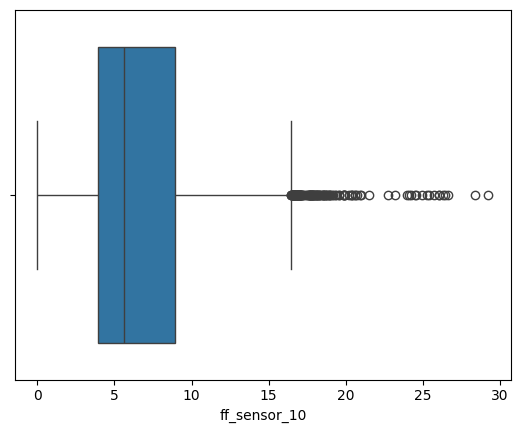

In [44]:
sns.boxplot(x = wind_df['ff_sensor_10'])

In [45]:
import numpy as np
import pandas as pd

def calculate_average_value_optimized(accident_event_start, data_df, value_column):
    # Adjust time range to numpy datetime64 for precise and efficient comparison
    
    time_interval_start = np.datetime64(accident_event_start - pd.Timedelta(hours=1))
    accident_event_start = np.datetime64(accident_event_start)
    
    # Since 'dtg' is the index, we use .index for filtering
    mask = (data_df.index >= time_interval_start) & (data_df.index <= accident_event_start)
    filtered_values = data_df.loc[mask, value_column]  # Efficient filtering using .loc

    # Calculate the mean using numpy to ensure minimal overhead, directly from Pandas series

    
   
    return round(filtered_values.mean(),2) if not filtered_values.empty else np.nan

def calculate_weather_statistics_optimized(weather_df, value_column, driving_df_values , new_value_column_name):
    # Utilize list comprehension for efficient processing
    
    average_data = [
        {'eventid': row_values[0], 'dtg': row_values[1], new_value_column_name: calculate_average_value_optimized(row_values[1], weather_df, value_column)}
        for _, row_values in driving_df_values.iterrows()
    ]
    return pd.DataFrame(average_data)




In [46]:
def merge_driving_with_weather_df(driving_df, weather_df,  old_value_column_name, new_value_column_name , on ='eventid', how='left'):
    
    average_weather_df = calculate_weather_statistics_optimized(weather_df, old_value_column_name, driving_df.loc[: , ['eventid' , 'event_start']] , new_value_column_name)

    driving_df = pd.merge(driving_df, average_weather_df.loc[:,['eventid' , new_value_column_name]], on='eventid', how='left')

    return driving_df

In [47]:
safe_driving_df = merge_driving_with_weather_df(safe_driving_df ,wind_df, 'ff_sensor_10',    'last_hour_wind_avg'   )


/tmp/ipykernel_51026/584755091.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  {'eventid': row_values[0], 'dtg': row_values[1], new_value_column_name: calculate_average_value_optimized(row_values[1], weather_df, value_column)}


In [48]:
safe_driving_df.loc[: , ['event_start', 'last_hour_wind_avg']].describe()

event_start  last_hour_wind_avg
count                           8000         8000.000000
mean   2018-01-26 15:53:31.862649856            6.857752
min       2018-01-01 00:18:20.500000            0.150000
25%       2018-01-14 20:54:23.500000            4.150000
50%       2018-01-27 09:07:46.500000            6.100000
75%       2018-02-07 13:33:41.400000            9.122500
max              2018-02-18 12:54:16           26.560000
std                              NaN            3.848200

In [49]:
temp_df = import_weather_df('temperature')


Connection was successful!
Connection was successful!


In [50]:
temp_df.describe()

latitude     longitude      altitude    u_bool_10    t_dryb_10  \
count  1.000000e+04  1.000000e+04  1.000000e+04  9999.000000  9999.000000   
mean   5.156500e+01  4.935278e+00  1.490000e+01     0.611261     3.346205   
std    1.421157e-14  1.776446e-15  1.776446e-15     0.487488     4.347209   
min    5.156500e+01  4.935278e+00  1.490000e+01     0.000000    -7.900000   
25%    5.156500e+01  4.935278e+00  1.490000e+01     0.000000     0.500000   
50%    5.156500e+01  4.935278e+00  1.490000e+01     1.000000     3.600000   
75%    5.156500e+01  4.935278e+00  1.490000e+01     1.000000     6.300000   
max    5.156500e+01  4.935278e+00  1.490000e+01     1.000000    15.500000   

       tn_10cm_past_6h_10    t_dewp_10  t_dewp_sea_10  t_dryb_sea_10  \
count         9999.000000  9999.000000    9999.000000    9997.000000   
mean             2.663556     0.280816       3.237344       2.110278   
std              4.773909     5.432106       4.518089       4.336553   
min            -10.700000   -14.800000      -8.200000      -9.070012   
25%             -0.300000    -2.800000       0.300000      -0.680402   
50%              3.000000     1.100000       3.500000       2.385943   
75%              6.000000     4.200000       6.200000       5.292907   
max             16.000000    11.400000      86.000000      12.283180   

        tn_dryb_10    t_wetb_10  
count  9997.000000  9997.000000  
mean      3.473392    80.985796  
std       4.321866    13.937866  
min      -7.600000    30.000000  
25%       0.700000    75.000000  
50%       3.700000    84.000000  
75%       6.400000    92.000000  
max      15.600000   100.000000

In [51]:

safe_driving_df = merge_driving_with_weather_df(safe_driving_df ,temp_df, 't_dryb_10',    'last_hour_temp_avg' )


/tmp/ipykernel_51026/584755091.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  {'eventid': row_values[0], 'dtg': row_values[1], new_value_column_name: calculate_average_value_optimized(row_values[1], weather_df, value_column)}


In [52]:
prec_df = import_weather_df('precipitation')



Connection was successful!
Connection was successful!


In [53]:

safe_driving_df = merge_driving_with_weather_df(safe_driving_df ,prec_df, 'ri_pws_10',    'last_hour_rain_avg' )


/tmp/ipykernel_51026/584755091.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  {'eventid': row_values[0], 'dtg': row_values[1], new_value_column_name: calculate_average_value_optimized(row_values[1], weather_df, value_column)}


In [54]:
safe_driving_df.head(10)

eventid             event_start               event_end  \
0  5653658.0 2018-01-01 00:18:20.500 2018-01-01 00:18:28.500   
1  5653662.0 2018-01-01 00:21:41.100 2018-01-01 00:21:43.500   
2  5653659.0 2018-01-01 00:22:54.500 2018-01-01 00:23:01.500   
3  5653663.0 2018-01-01 00:24:33.800 2018-01-01 00:24:35.500   
4  5653660.0 2018-01-01 00:24:42.500 2018-01-01 00:24:49.500   
5  5653664.0 2018-01-01 00:25:07.900 2018-01-01 00:25:09.700   
6  5879594.0 2018-01-01 00:27:43.500 2018-01-01 00:27:49.500   
7  5493833.0 2018-01-01 00:51:05.600 2018-01-01 00:51:06.900   
8  5493832.0 2018-01-01 00:51:34.000 2018-01-01 00:51:41.000   
9  5718272.0 2018-01-01 01:01:46.500 2018-01-01 01:01:49.200   

   duration_seconds  latitude  longitude  speed_kmh  end_speed_kmh  maxwaarde  \
0          0.644292  51.59962   4.749473   2.097041       2.079379   1.919038   
1         -0.541123  51.59909   4.791214  -0.595707      -0.256241  -0.771171   
2          0.432611  51.59847   4.800009   1.086868       1.078177   1.214675   
3         -0.689300  51.59342   4.804034  -1.016612      -0.839757  -0.774298   
4          0.432611  51.59399   4.804958   1.339411       1.328478   1.919038   
5         -0.668131  51.59563   4.808778  -0.679888      -1.006624  -0.769608   
6          0.220929  51.59777   4.799728   1.086868       1.078177   1.214675   
7         -0.773972  51.57217   4.768219  -0.427345      -0.589456  -0.775861   
8          0.432611  51.57211   4.763133   1.086868       1.245044   1.265009   
9         -0.477618  51.60253   4.720942  -0.595707      -0.422589  -0.772735   

          category incident_severity  road_segment_id              road_name  \
0            speed               sp1      600750243.0      backer en ruebweg   
1  harsh cornering               hc1      600753776.0           doornboslaan   
2            speed               sp1      600892914.0            kapittelweg   
3  harsh cornering               hc1      600941106.0         teteringsedijk   
4            speed               sp1      600941096.0         teteringsedijk   
5  harsh cornering               hc1      600754837.0        oosterhoutseweg   
6            speed               sp1      600892914.0            kapittelweg   
7  harsh cornering               hc1      600121497.0  willem van oranjelaan   
8            speed               sp1      600914069.0    graaf engelbertlaan   
9  harsh cornering               hc1      217203086.0      backer en ruebweg   

   last_hour_wind_avg  last_hour_temp_avg  last_hour_rain_avg  
0               13.75                8.90                0.00  
1               13.46                8.87                0.00  
2               13.46                8.87                0.00  
3               13.46                8.87                0.00  
4               13.46                8.87                0.00  
5               13.46                8.87                0.00  
6               13.46                8.87                0.00  
7               13.29                8.80                0.01  
8               13.29                8.80                0.01  
9               13.27                8.75                0.01

In [55]:
def scale_numerical_data(df , columns):

    for col in columns:
        scaler = StandardScaler()
        df[col] = scaler.fit_transform(df[[col]])
        

In [56]:
scale_numerical_data(safe_driving_df , ['last_hour_wind_avg', 'last_hour_temp_avg', 'last_hour_rain_avg'])


In [57]:
safe_driving_df.head(10)

eventid             event_start               event_end  \
0  5653658.0 2018-01-01 00:18:20.500 2018-01-01 00:18:28.500   
1  5653662.0 2018-01-01 00:21:41.100 2018-01-01 00:21:43.500   
2  5653659.0 2018-01-01 00:22:54.500 2018-01-01 00:23:01.500   
3  5653663.0 2018-01-01 00:24:33.800 2018-01-01 00:24:35.500   
4  5653660.0 2018-01-01 00:24:42.500 2018-01-01 00:24:49.500   
5  5653664.0 2018-01-01 00:25:07.900 2018-01-01 00:25:09.700   
6  5879594.0 2018-01-01 00:27:43.500 2018-01-01 00:27:49.500   
7  5493833.0 2018-01-01 00:51:05.600 2018-01-01 00:51:06.900   
8  5493832.0 2018-01-01 00:51:34.000 2018-01-01 00:51:41.000   
9  5718272.0 2018-01-01 01:01:46.500 2018-01-01 01:01:49.200   

   duration_seconds  latitude  longitude  speed_kmh  end_speed_kmh  maxwaarde  \
0          0.644292  51.59962   4.749473   2.097041       2.079379   1.919038   
1         -0.541123  51.59909   4.791214  -0.595707      -0.256241  -0.771171   
2          0.432611  51.59847   4.800009   1.086868       1.078177   1.214675   
3         -0.689300  51.59342   4.804034  -1.016612      -0.839757  -0.774298   
4          0.432611  51.59399   4.804958   1.339411       1.328478   1.919038   
5         -0.668131  51.59563   4.808778  -0.679888      -1.006624  -0.769608   
6          0.220929  51.59777   4.799728   1.086868       1.078177   1.214675   
7         -0.773972  51.57217   4.768219  -0.427345      -0.589456  -0.775861   
8          0.432611  51.57211   4.763133   1.086868       1.245044   1.265009   
9         -0.477618  51.60253   4.720942  -0.595707      -0.422589  -0.772735   

          category incident_severity  road_segment_id              road_name  \
0            speed               sp1      600750243.0      backer en ruebweg   
1  harsh cornering               hc1      600753776.0           doornboslaan   
2            speed               sp1      600892914.0            kapittelweg   
3  harsh cornering               hc1      600941106.0         teteringsedijk   
4            speed               sp1      600941096.0         teteringsedijk   
5  harsh cornering               hc1      600754837.0        oosterhoutseweg   
6            speed               sp1      600892914.0            kapittelweg   
7  harsh cornering               hc1      600121497.0  willem van oranjelaan   
8            speed               sp1      600914069.0    graaf engelbertlaan   
9  harsh cornering               hc1      217203086.0      backer en ruebweg   

   last_hour_wind_avg  last_hour_temp_avg  last_hour_rain_avg  
0            1.791143            1.197395           -0.234421  
1            1.715779            1.188755           -0.234421  
2            1.715779            1.188755           -0.234421  
3            1.715779            1.188755           -0.234421  
4            1.715779            1.188755           -0.234421  
5            1.715779            1.188755           -0.234421  
6            1.715779            1.188755           -0.234421  
7            1.671599            1.168594           -0.207451  
8            1.671599            1.168594           -0.207451  
9            1.666402            1.154194           -0.207451

In [58]:
safe_driving_df.shape

(8000, 16)

### Import the dataset 

In [59]:
accidents_17_23_df = load_sql_to_df('accident_data_17_23')

Connection was successful!
Connection was successful!


### Manage columns and transform them


In [60]:
def transform_numerical_column_to_str(df,columns):
    df.loc[:, columns] = df.loc[:,columns].astype(str)
    

### We will transform Year column to categorical column in order to make it easier to plot for now

In [61]:
transform_numerical_column_to_str( accidents_17_23_df , ['Year'])

/tmp/ipykernel_51026/2014619507.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2017' '2017' '2017' ... '2023' '2023' '2023']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, columns] = df.loc[:,columns].astype(str)


### We will ensure categorical values do not have uneccesary whitespace or other unexpected special characters, moreover, we will unifiy value casing to lower


In [62]:
accidents_17_23_df = clean_categorical_data(accidents_17_23_df)

### We will ensure that all unknown values are converted as nan values

In [63]:
def convert_unknown_to_nan(df):
    df.replace({'unknown':np.nan}, inplace = True)

In [64]:
convert_unknown_to_nan(accidents_17_23_df)

### In some columns  are presents empty '' values which we will convert to  nan values



In [65]:
def convert_empty_values_to_nan(df,columns):
    for col in columns:
        df[col] = df[col].replace({'':np.nan})

In [66]:
convert_empty_values_to_nan(accidents_17_23_df , ['first_mode_of_transport'])

### We will ensure that rows with insignificant rows will be dropped

In [67]:
def drop_rows_with_drop_values(df, col  , drop_values):
    
    if drop_values:
       mask = df[col].apply(lambda row: str(row) in drop_values)

       print(pd.unique(mask))
        
       idxs_to_drop = df[mask].index
       print(idxs_to_drop)
       df.drop(index = idxs_to_drop , inplace = True)

In [68]:


def convert_string_column_to_numerical(df,col ,  drop_values = []):
    drop_rows_with_drop_values(df, col, drop_values)
    
    def return_speed(row):
        
        splitted_row =     str(row).split(' ')      
        return float(splitted_row[0])
        
    df[col]  = df[col].apply(lambda row:  return_speed(row) if not pd.isnull(row) else row)



 
    

### Delete footpace homezone value from speed_limit column because it only occurs 6 times in whole df

In [69]:
convert_string_column_to_numerical(accidents_17_23_df, 'speed_limit' , drop_values = ['footpace  homezone']) 

[False  True]
Index([570, 634, 682, 813, 1029, 1031], dtype='int64')


### Drop municipality column because it has only "breda" value

In [70]:
drop_columns_in_df(accidents_17_23_df , ['municipality'  ])

### Show the columns with missing values

In [71]:
def show_columns_with_missing_values(df):
    df_cols = df.columns

    for col in df_cols:
        missing_vals_in_col  = df[col].isna().sum()
        if missing_vals_in_col > 0:
            nan_perc = round( (missing_vals_in_col / df.shape[0]) * 100  , 2 )
            print(f'Col: {col} has {missing_vals_in_col} missing values')
            print(f'Percentage of missing values / all values in column: {nan_perc } %')
            show_dataframe_column_value_counts(df[[col]])
            print_line_break()
            
            
    

Col: first_mode_of_transport has 851 missing values
Percentage of missing values / all values in column: 12.34 %
 ------------------ 


'Value counts of first_mode_of_transport'

first_mode_of_transport
car             4346
delivery van     496
moped            362
lorry            240
bicycle          181
lightmoped       166
Name: count, dtype: int64

 ------------------ 


'Least used values in first_mode_of_transport column: '

first_mode_of_transport
pedestrian         6
other vehicle     22
bus               37
other             83
motorcycle       106
Name: count, dtype: int64

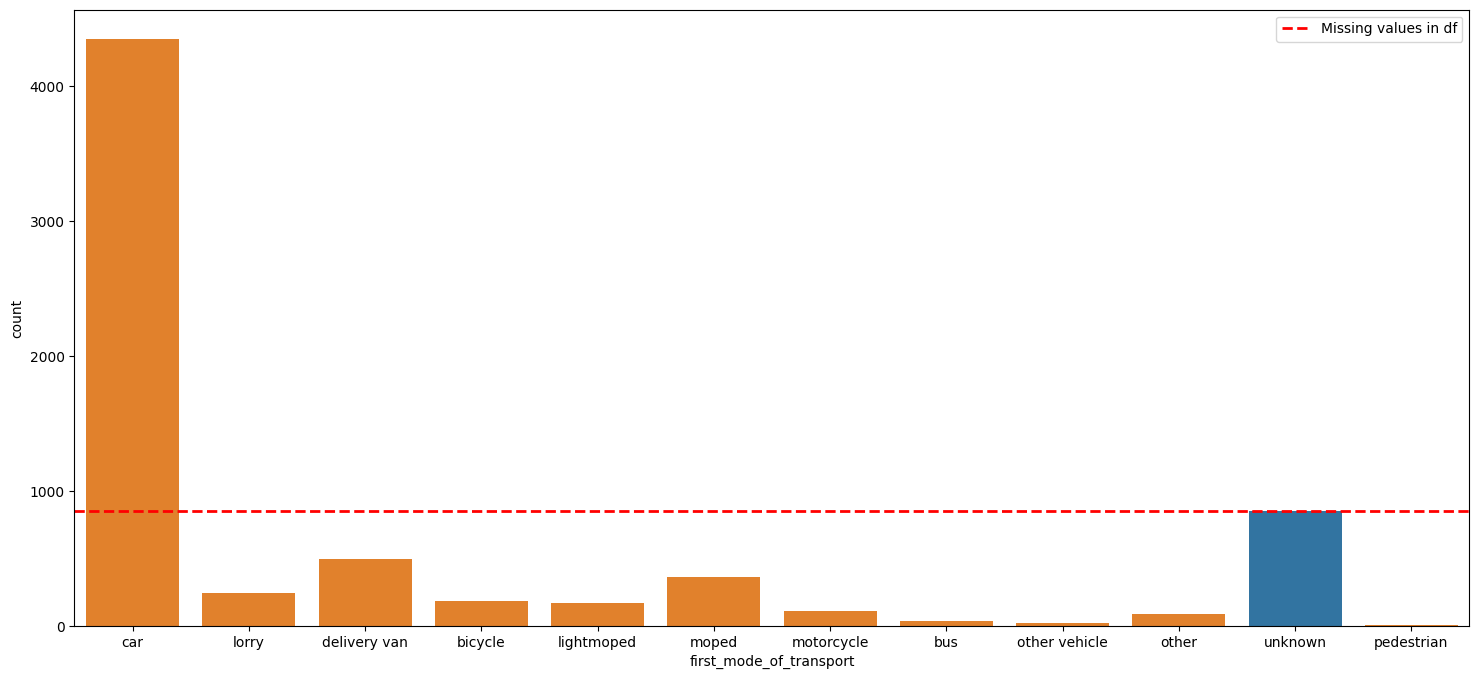

'Missing values in first_mode_of_transport'

'first_mode_of_transport: 851'

 ------------------ 
Col: area_type has 2245 missing values
Percentage of missing values / all values in column: 32.56 %
 ------------------ 


'Value counts of area_type'

area_type
urban area    3451
rural area    1200
Name: count, dtype: int64

 ------------------ 


'Least used values in area_type column: '

area_type
rural area    1200
urban area    3451
Name: count, dtype: int64

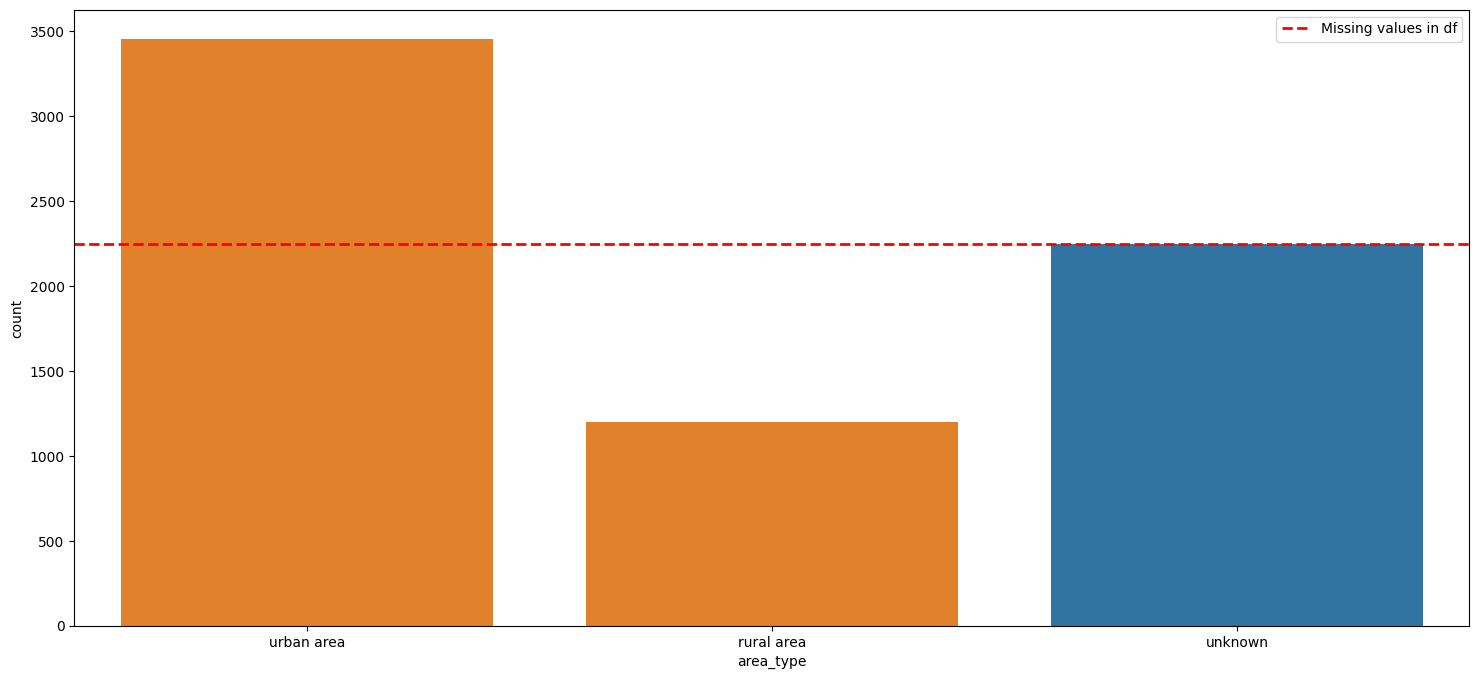

'Missing values in area_type'

'area_type: 2245'

 ------------------ 
Col: road_condition has 2255 missing values
Percentage of missing values / all values in column: 32.7 %
 ------------------ 


'Value counts of road_condition'

road_condition
dry              3093
wetdamp          1498
snowblack ice      50
Name: count, dtype: int64

 ------------------ 


'Least used values in road_condition column: '

road_condition
snowblack ice      50
wetdamp          1498
dry              3093
Name: count, dtype: int64

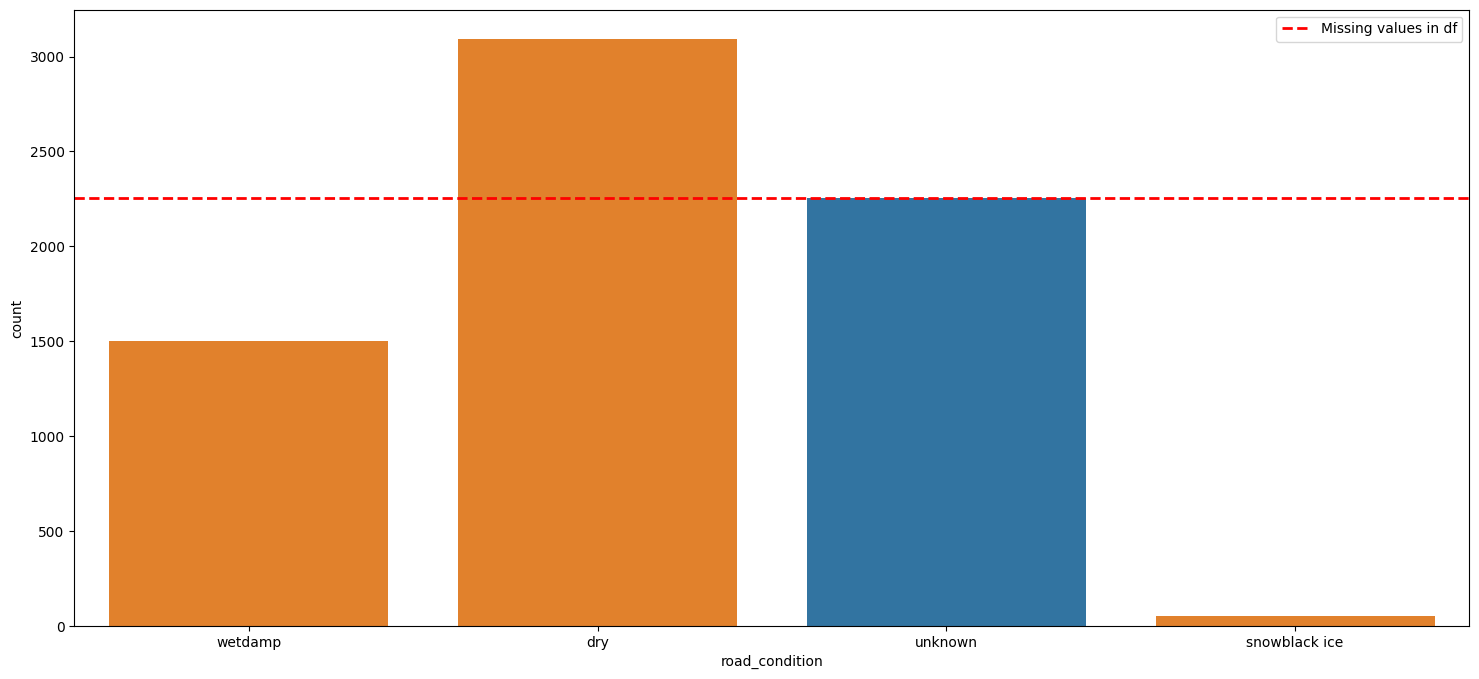

'Missing values in road_condition'

'road_condition: 2255'

 ------------------ 
Col: road_surface has 2346 missing values
Percentage of missing values / all values in column: 34.02 %
 ------------------ 


'Value counts of road_surface'

road_surface
asphalt other     2488
porous asphalt    1178
brick              543
concrete           341
Name: count, dtype: int64

 ------------------ 


'Least used values in road_surface column: '

road_surface
concrete           341
brick              543
porous asphalt    1178
asphalt other     2488
Name: count, dtype: int64

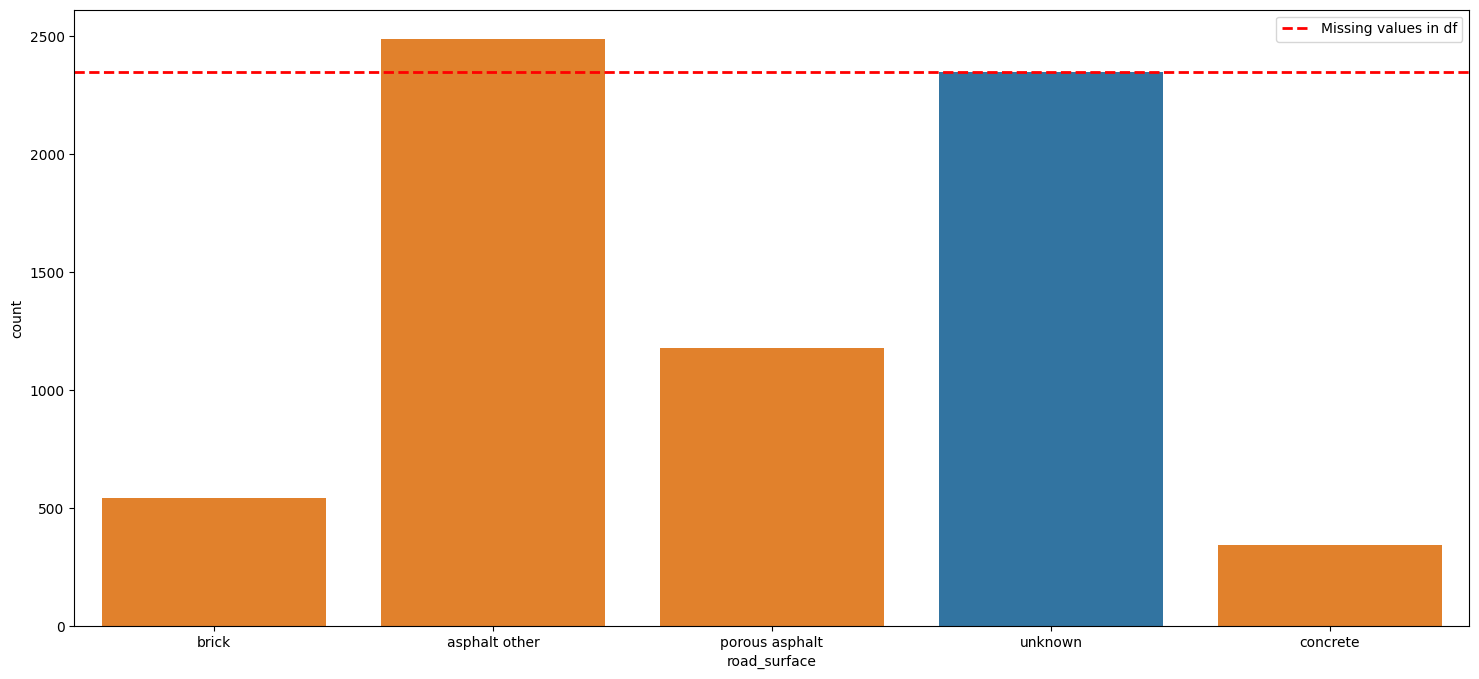

'Missing values in road_surface'

'road_surface: 2346'

 ------------------ 
Col: road_situation has 2283 missing values
Percentage of missing values / all values in column: 33.11 %
 ------------------ 


'Value counts of road_situation'

road_situation
straight road                           2261
intersection  4 arms                    1236
intersection  3 arms                     550
bend                                     461
roundabout                               102
straight road  separated carriageway       3
Name: count, dtype: int64

 ------------------ 


'Least used values in road_situation column: '

road_situation
straight road  separated carriageway       3
roundabout                               102
bend                                     461
intersection  3 arms                     550
intersection  4 arms                    1236
Name: count, dtype: int64

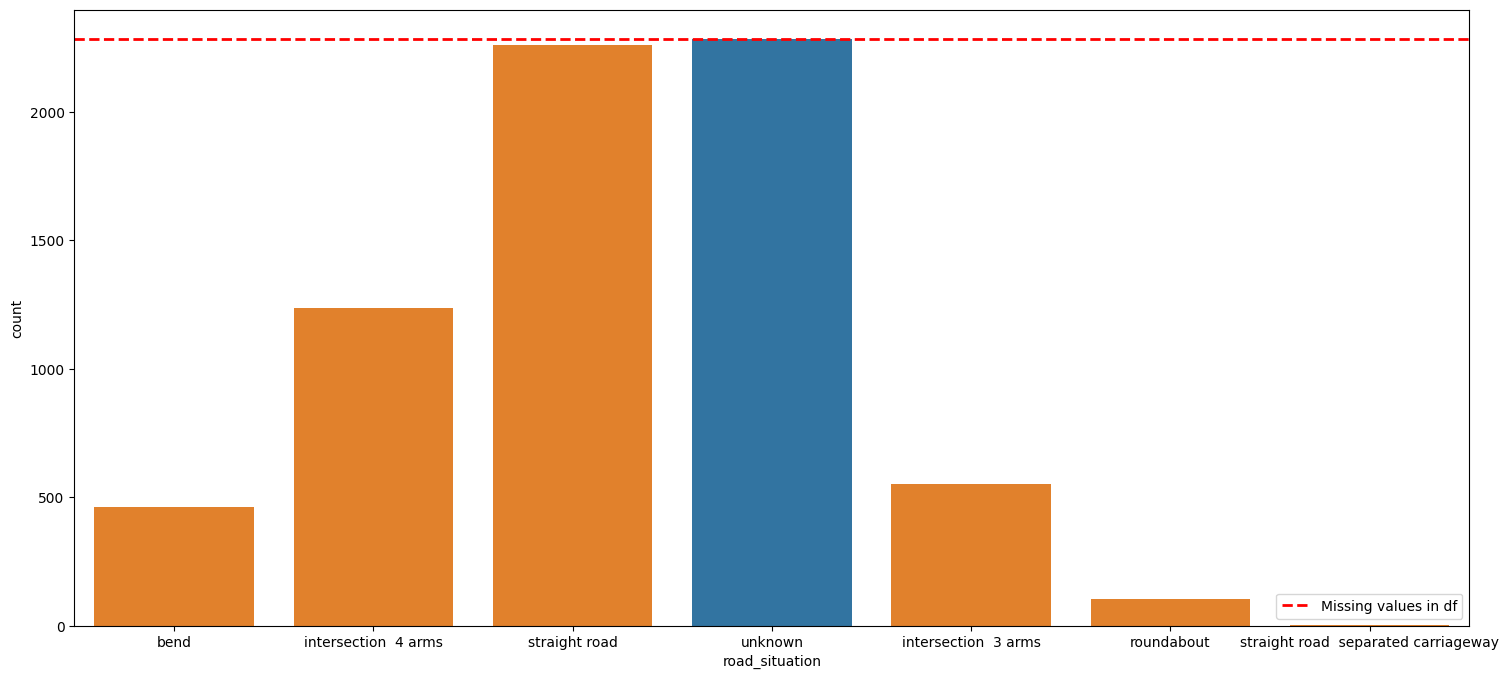

'Missing values in road_situation'

'road_situation: 2283'

 ------------------ 
Col: speed_limit has 1103 missing values
Percentage of missing values / all values in column: 15.99 %
 ------------------ 


'Value counts of speed_limit'

speed_limit
50.0     2762
30.0     1058
130.0     632
70.0      535
100.0     359
120.0     166
Name: count, dtype: int64

 ------------------ 


'Least used values in speed_limit column: '

speed_limit
90.0      22
15.0      31
80.0      70
60.0     158
120.0    166
Name: count, dtype: int64

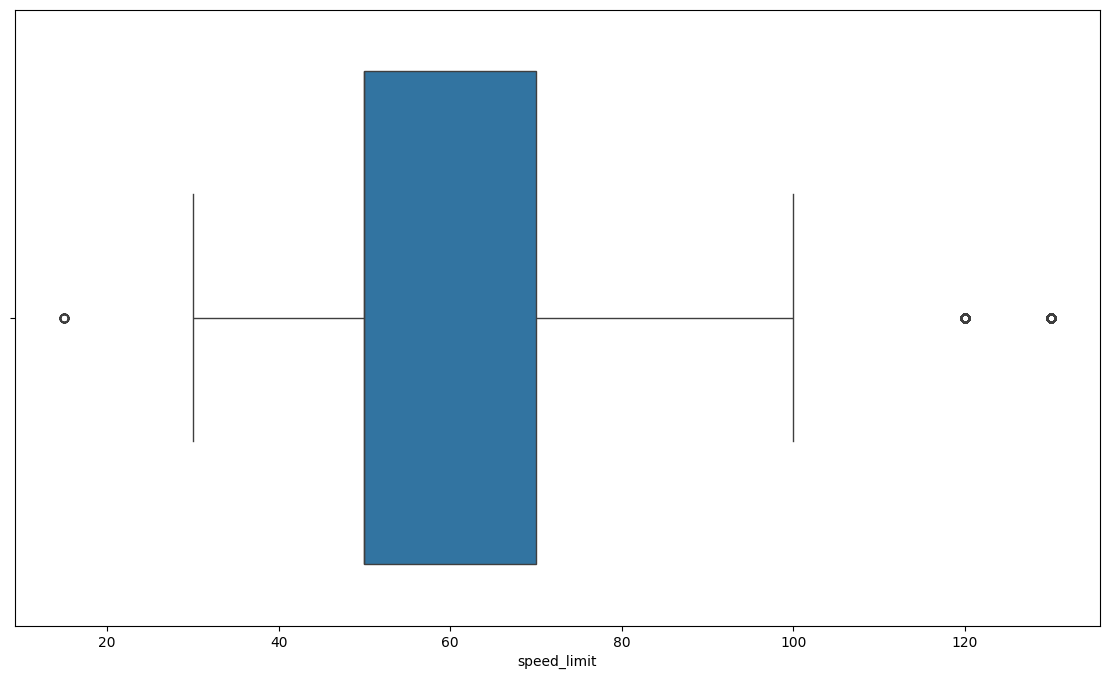

'Missing values in speed_limit'

'speed_limit: 1103'

 ------------------ 
Col: weather has 2397 missing values
Percentage of missing values / all values in column: 34.76 %
 ------------------ 


'Value counts of weather'

weather
dry                   3747
rain                   697
snowhale                34
fog                     17
hard gusts of wind       4
Name: count, dtype: int64

 ------------------ 


'Least used values in weather column: '

weather
hard gusts of wind       4
fog                     17
snowhale                34
rain                   697
dry                   3747
Name: count, dtype: int64

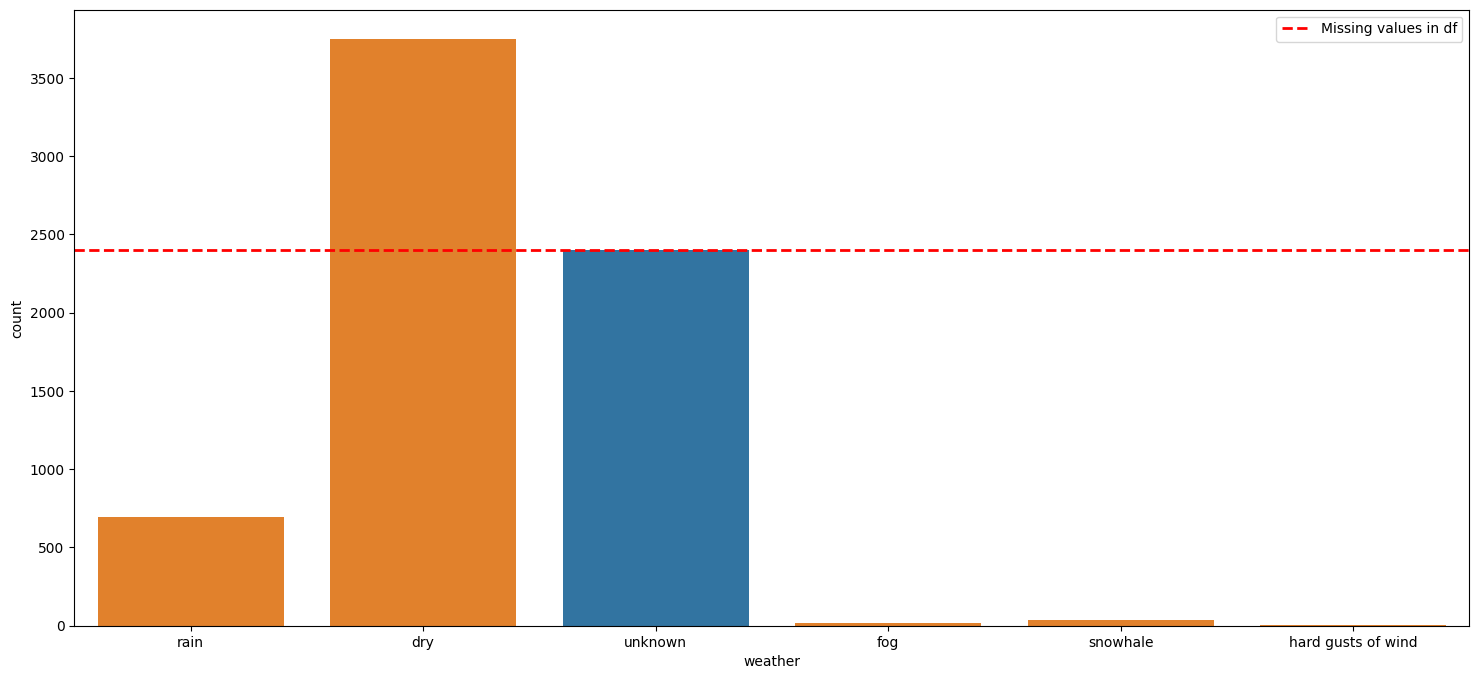

'Missing values in weather'

'weather: 2397'

 ------------------ 


In [72]:
show_columns_with_missing_values(accidents_17_23_df)

### Since every column has missing values over 15% that means that missing values constitute significant amount of important information , but because of the fact that I am not convinced how the datasets will be merged I will leave missing data imputation steps for later


In [73]:
show_general_duplicate_values(accidents_17_23_df)

'No duplicated values in this dataframe !!!'

### The brief analysis of dataset indicates no explicit unique identifier for each event in dataframe. Moreover, the amount of whole rows  duplicated is 0  therefore it is safe to assume that there are not any duplicates  


### Now I will proceed to examine distribution

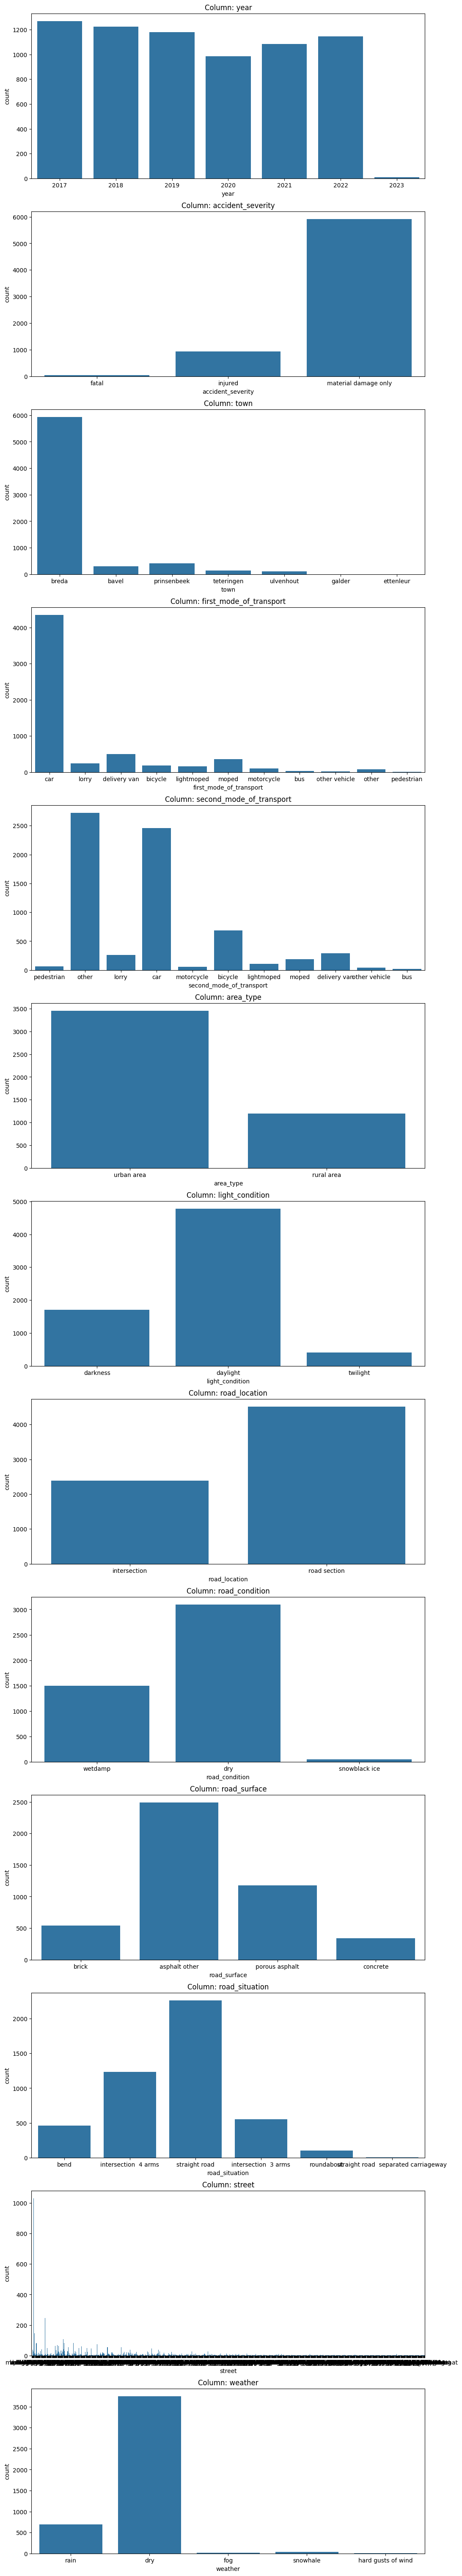

 ------------------ 
 ------------------ 
 ------------------ 


In [74]:
plot_value_distributions_in_df(accidents_17_23_df , columns_to_avoid = [])

### Due to unequal distribution of certain columns let's convert them into binary column type

In [75]:
columns_with_new_values_dict = {
    'accident_severity':{
        'new_value':'injury or fatal',
         'top_values':1
    },
    'town':{
        'new_value':'other city',
         'top_values':1
    },

    'first_mode_of_transport':{
        'new_value':'other',
         'top_values':1
    },

   'second_mode_of_transport':{
        'new_value':'other',
         'top_values':2
    },

    'light_condition':{
        'new_value':'darkness or twilight',
         'top_values':1
    },
    'road_condition':{
        'new_value': 'wetdamp or snowblack ice',
         'top_values':1
    },
    'road_situation':{
        'new_value': 'other road situation',
         'top_values':4
    },
    'weather':{
        'new_value': 'other weather situation',
         'top_values':2
    },
    
    
    

    
}



        
        

        

In [76]:
convert_column_to_binary(accidents_17_23_df ,columns_with_new_values_dict )






Let's eleminate outliers from speed_limit by removing accidents on road with very high or very low speed limit



In [77]:
def show_dist_for_cols(df , cols , boxplot = False):
    fig , axes = plt.subplots( nrows = len(cols) ,ncols = 1 , figsize = (20 ,15))
    if len(cols) == 1:
        axes = np.array([axes])
    for idx, ax in enumerate(axes.flatten()):
    
        if boxplot:
            sns.boxplot(x=cols[idx] , ax = ax , data = df)
        else:
        
            sns.countplot(x=cols[idx], ax = ax , data = df)

    plt.show()

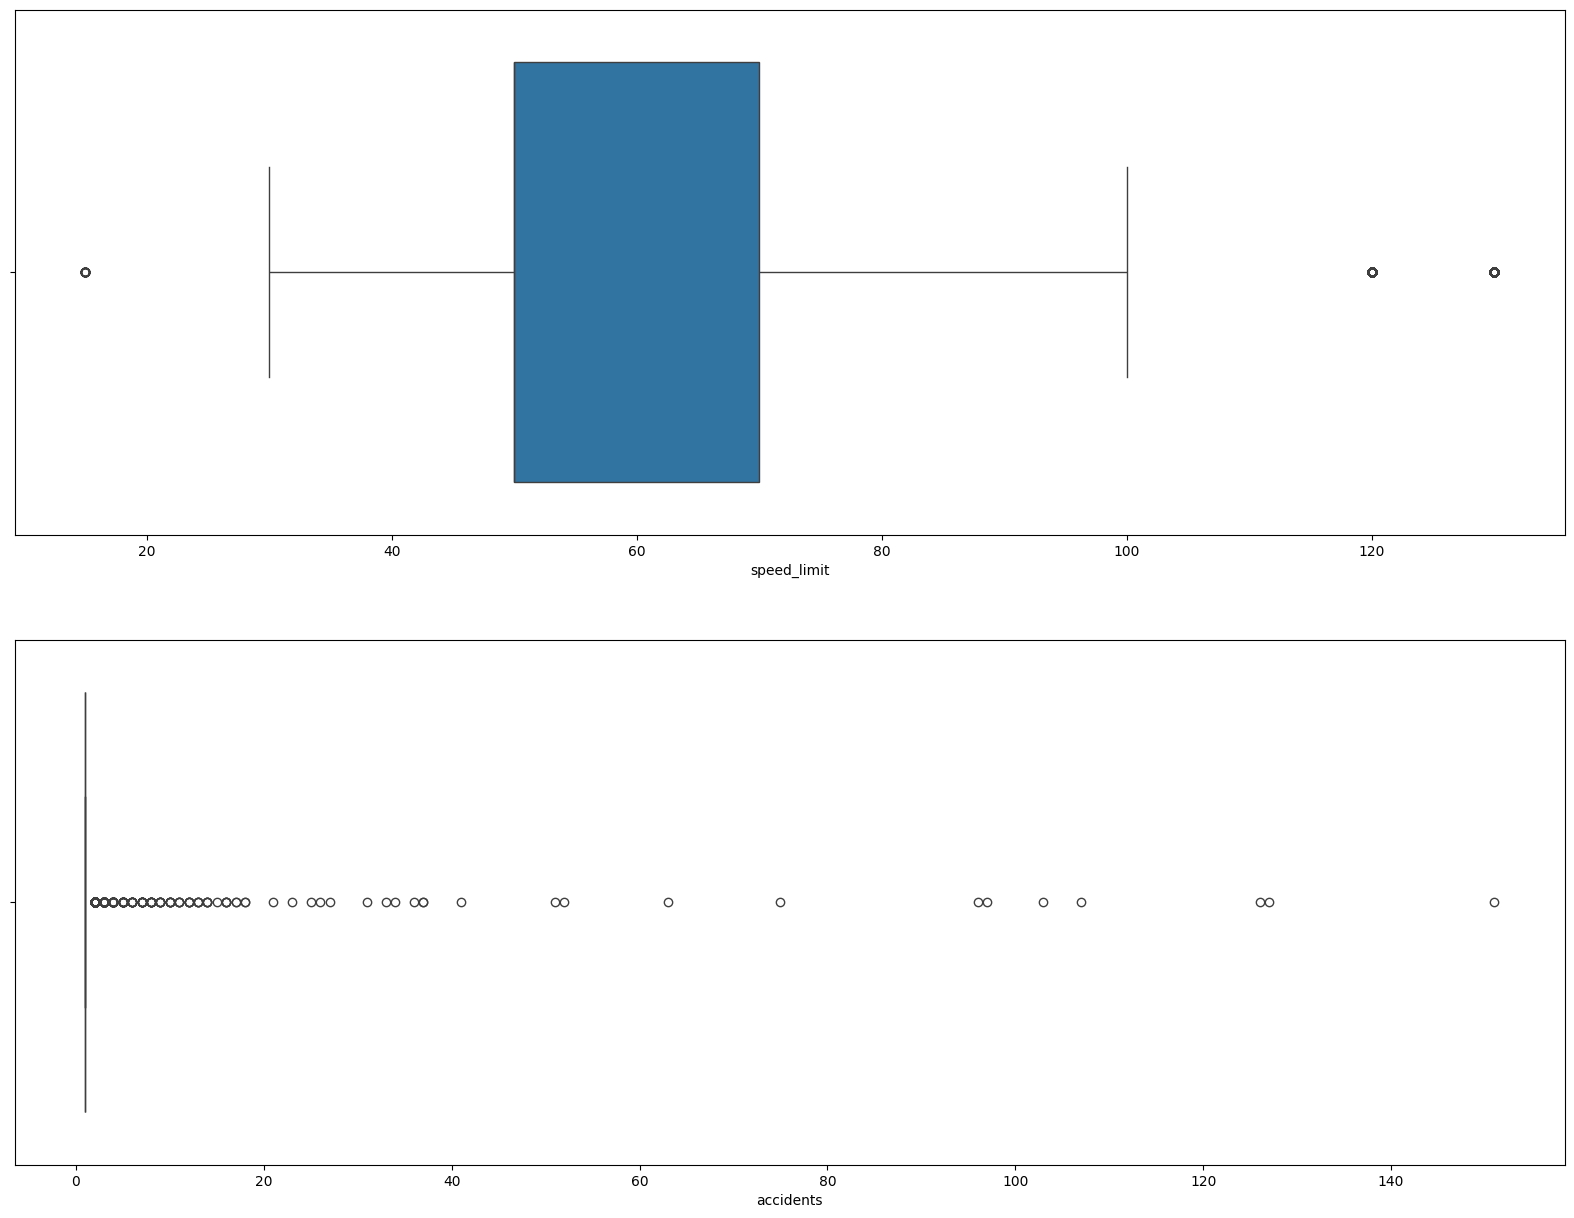

In [78]:
show_dist_for_cols(accidents_17_23_df , ['speed_limit' , 'accidents'] , True)

In [79]:
accidents_17_23_df = delete_outliers(accidents_17_23_df , ['speed_limit' , 'accidents'] )



 ------------------ 


'The fraction of outliers in speed_limit'

829


'829  / 6896 which is around 12.0%'

 ------------------ 
speed_limit: Q1=50.0, Q3=70.0, IQR=20.0, Lower Bound=20.0, Upper Bound=100.0
 ------------------ 


'The fraction of outliers in accidents'

543


'543  / 6896 which is around 8.0%'

 ------------------ 
accidents: Q1=1.0, Q3=1.0, IQR=0.0, Lower Bound=1.0, Upper Bound=1.0


INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


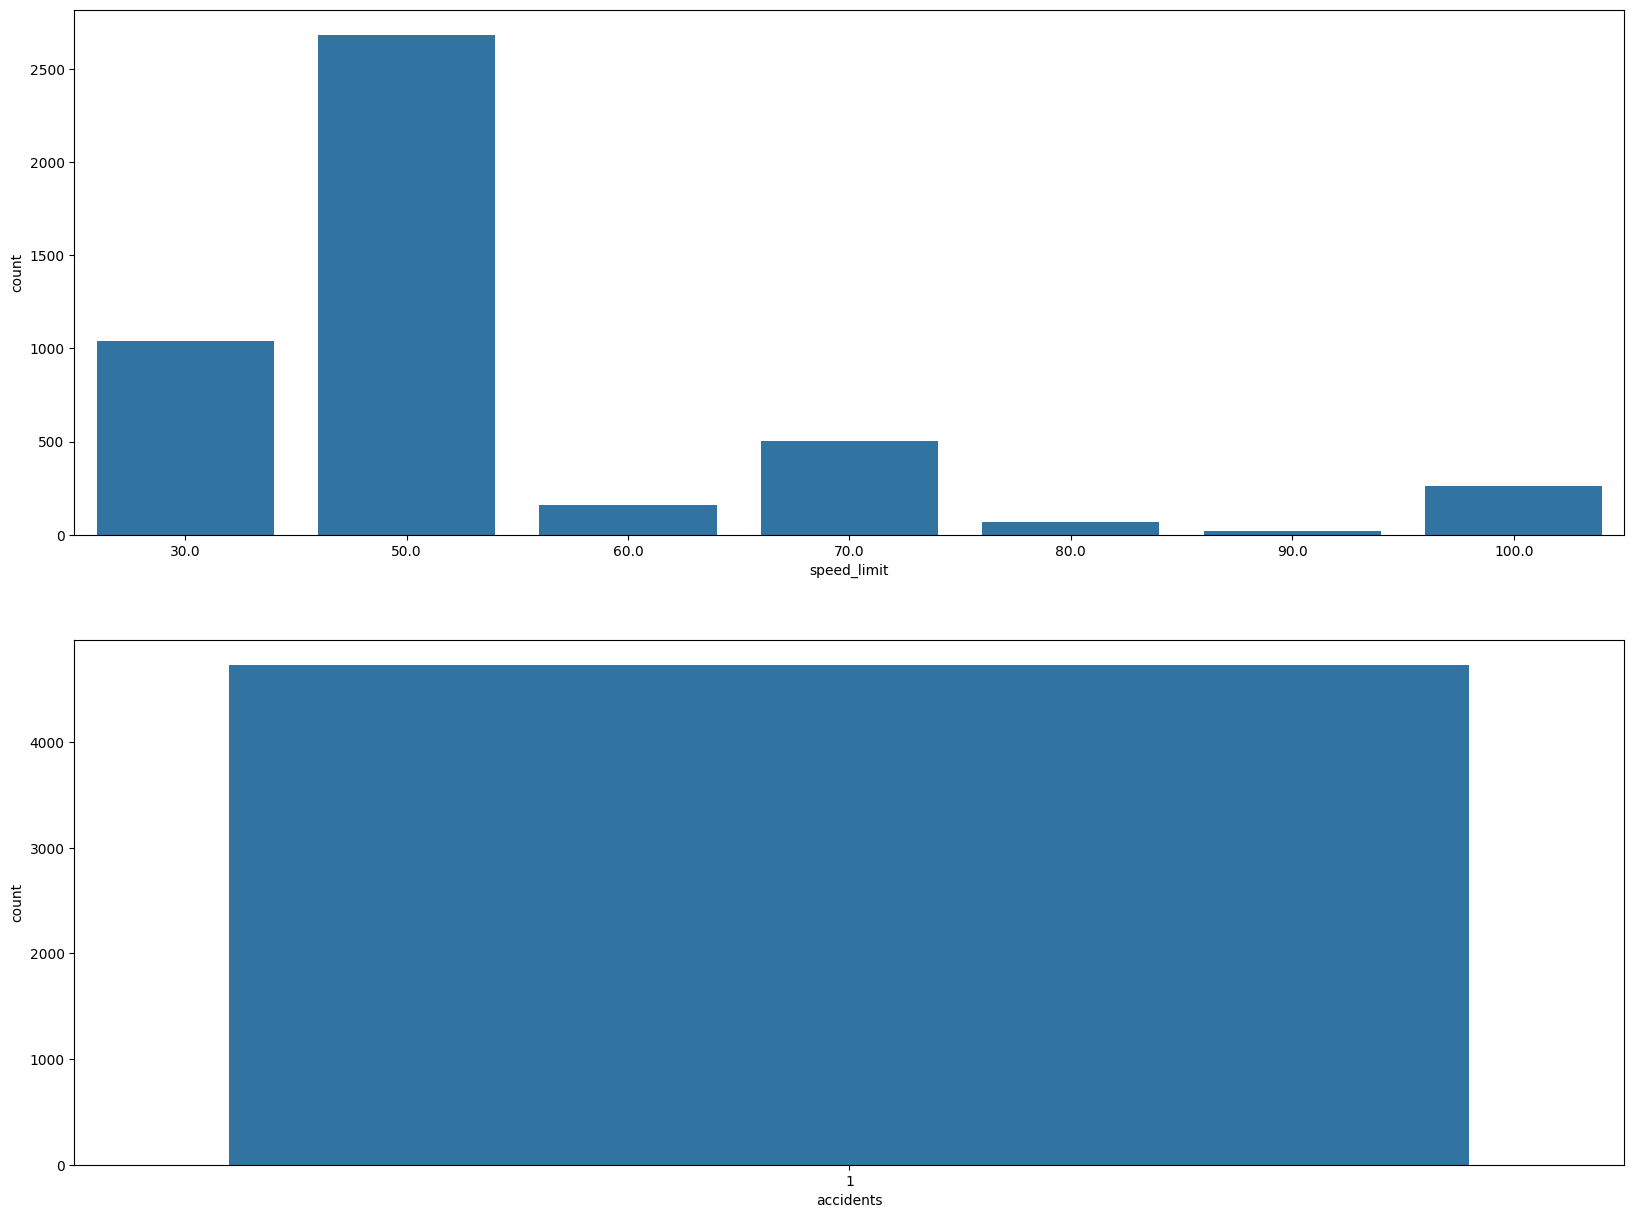

In [80]:
show_dist_for_cols(accidents_17_23_df , ['speed_limit' , 'accidents'])

### Let's again present data distributions after transformations

'Numerical columns plotted :'

[<Axes: > <Axes: >] <class 'numpy.ndarray'>


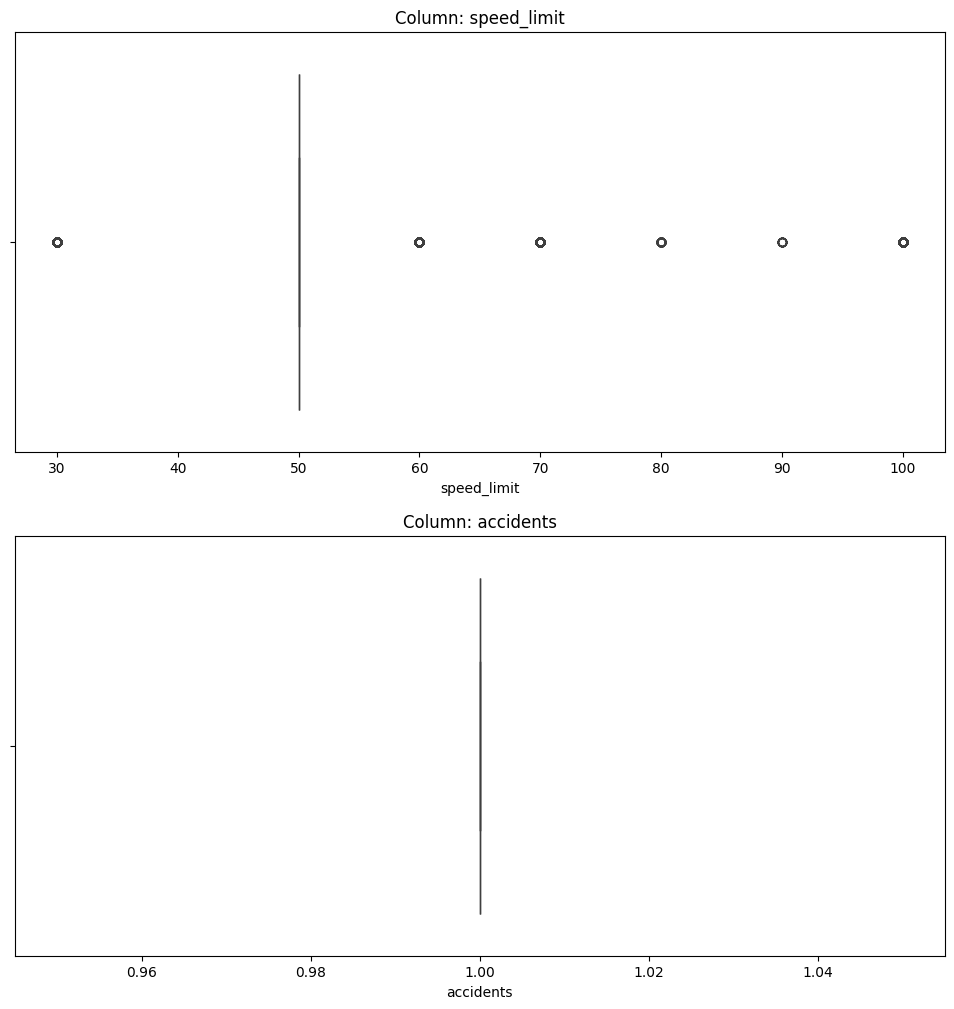

 ------------------ 
 ------------------ 
 ------------------ 


'String columns plotted :'

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >
 <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >] <class 'numpy.ndarray'>


INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


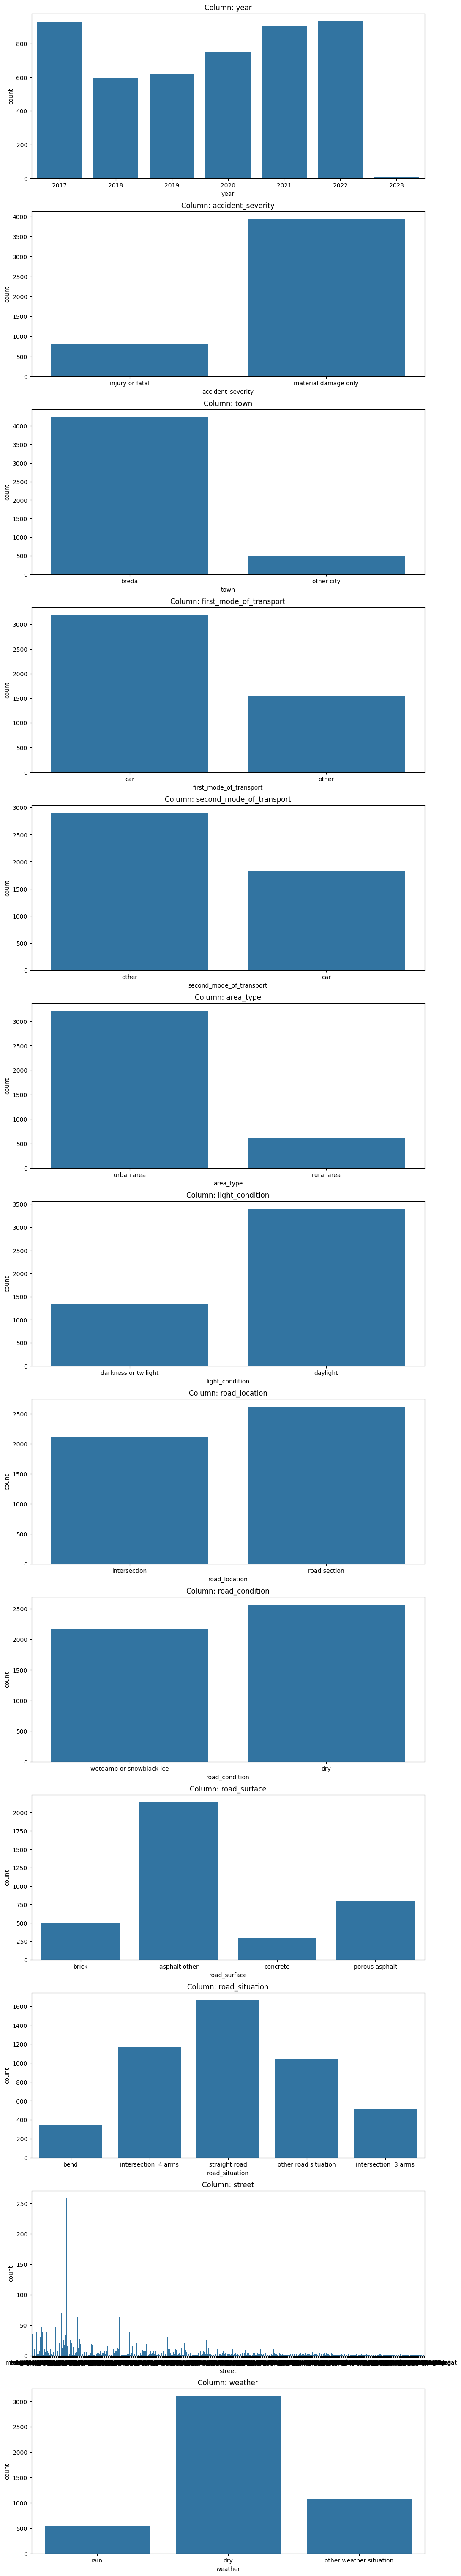

 ------------------ 
 ------------------ 
 ------------------ 


In [81]:
plot_value_distributions_in_df(accidents_17_23_df , columns_to_avoid = [])

### Let's proceed with data inconsistencies

In [82]:
clean_numerical_cols(accidents_17_23_df) 

In [83]:
accidents_17_23_df.head(10)

year accident_severity        town first_mode_of_transport  \
0   2017   injury or fatal       breda                     car   
1   2017   injury or fatal       breda                   other   
2   2017   injury or fatal       breda                   other   
5   2017   injury or fatal  other city                   other   
6   2017   injury or fatal       breda                   other   
7   2017   injury or fatal       breda                   other   
9   2017   injury or fatal       breda                   other   
10  2017   injury or fatal       breda                   other   
11  2017   injury or fatal       breda                   other   
13  2017   injury or fatal       breda                   other   

   second_mode_of_transport   area_type       light_condition road_location  \
0                     other  urban area  darkness or twilight  intersection   
1                     other  urban area              daylight  intersection   
2                     other  urban area              daylight  road section   
5                       car  rural area  darkness or twilight  road section   
6                     other  urban area              daylight  intersection   
7                     other  urban area              daylight  intersection   
9                     other         NaN  darkness or twilight  road section   
10                    other         NaN  darkness or twilight  road section   
11                    other         NaN  darkness or twilight  road section   
13                      car  urban area              daylight  intersection   

              road_condition   road_surface        road_situation  \
0   wetdamp or snowblack ice          brick                  bend   
1   wetdamp or snowblack ice          brick  intersection  4 arms   
2                        dry  asphalt other         straight road   
5   wetdamp or snowblack ice  asphalt other         straight road   
6                        dry  asphalt other  intersection  4 arms   
7                        dry  asphalt other  intersection  4 arms   
9   wetdamp or snowblack ice            NaN  other road situation   
10  wetdamp or snowblack ice            NaN  other road situation   
11  wetdamp or snowblack ice            NaN  other road situation   
13                       dry  asphalt other  intersection  4 arms   

    speed_limit           street                  weather  accidents  
0          30.0  valkeniersplein                     rain        1.0  
1          50.0  markendaalseweg                      dry        1.0  
2          50.0   academiesingel                      dry        1.0  
5          80.0         gilzeweg                     rain        1.0  
6          50.0    nieuwe kadijk                      dry        1.0  
7          30.0     rithsestraat                      dry        1.0  
9          50.0      achter emer  other weather situation        1.0  
10         50.0   academiesingel  other weather situation        1.0  
11         50.0     emerparklaan  other weather situation        1.0  
13         50.0      achter emer                      dry        1.0

### Let's see value counts of accidents



In [84]:
accidents_17_23_df['accidents'].value_counts()

accidents
1.0    4733
Name: count, dtype: int64

### Let's scale numerical values 


In [85]:
scale_numerical_data(accidents_17_23_df , accidents_17_23_df.select_dtypes(include=['float' ,'int']))


In [86]:
accidents_17_23_df.describe()

speed_limit  accidents
count  4.733000e+03     4733.0
mean   1.080902e-16        0.0
std    1.000106e+00        0.0
min   -1.259059e+00        0.0
25%   -8.357297e-02        0.0
50%   -8.357297e-02        0.0
75%   -8.357297e-02        0.0
max    2.855141e+00        0.0

## Given the fact that accidents number has std = 0 and now only contains value 0 after transofrmations, no longer it constains meaningful info, therefore let's drop accidents columns


In [87]:
drop_columns_in_df(accidents_17_23_df , ['accidents'])



In [88]:
accidents_17_23_df.describe()

speed_limit
count  4.733000e+03
mean   1.080902e-16
std    1.000106e+00
min   -1.259059e+00
25%   -8.357297e-02
50%   -8.357297e-02
75%   -8.357297e-02
max    2.855141e+00

### Categorical encoding will be left for modelling process therefore no decoding functions will be implemented currently

## Now the data needs to be analyzed

### Let's make a weighted mean of accident_severity table to make it a new column for safe_driving_df
So in our case the weighted mean of types of accidents severity will help us to assess if the street is high or low risk

In [89]:
def transform_acc_sev_col_to_encoding(df):
    df= df.copy()
        
    df = df.join(
    pd.get_dummies(df['accident_severity'] ,  dtype=float))
    return df
  

    
def w_avg(row , weights):
    w1,w2 = weights
   
    values_with_w_sum = row['injury_or_fatal_sum'] * w1 + row['material_damage_only_sum']  * w2
    
    return values_with_w_sum  / (w1 + w2) 

def calc_weighted_mean_of_acc_severity(df):
    df = df.copy()
    df = transform_acc_sev_col_to_encoding(df)

    new_df  = df.groupby(['street']).agg(injury_or_fatal_sum= ('injury or fatal', 'sum'), material_damage_only_sum = ('material damage only' , 'sum')).reset_index()

    new_df['weighted_avg'] = new_df.apply(lambda row: w_avg(row, [2,1]) , axis = 1)

    print(new_df['weighted_avg'].describe())
    return new_df


In [90]:
streets_with_accidents_ratio_df = calc_weighted_mean_of_acc_severity(accidents_17_23_df)

count    741.000000
mean       2.488529
std        5.996300
min        0.333333
25%        0.333333
50%        0.666667
75%        2.000000
max       94.333333
Name: weighted_avg, dtype: float64


In [91]:
streets_with_accidents_ratio_df.head(10)

street  injury_or_fatal_sum  material_damage_only_sum  \
0                  aanstede                  0.0                       1.0   
1                aardenhoek                  1.0                       2.0   
2               abeelstraat                  1.0                       2.0   
3              acaciastraat                  1.0                       2.0   
4            academiesingel                  5.0                      27.0   
5   achter de lange stallen                  0.0                       2.0   
6               achter emer                  5.0                       2.0   
7                 achtererf                  1.0                       3.0   
8    adriaan klaassenstraat                  0.0                       2.0   
9  adriaan van bergenstraat                  1.0                       7.0   

   weighted_avg  
0      0.333333  
1      1.333333  
2      1.333333  
3      1.333333  
4     12.333333  
5      0.666667  
6      4.000000  
7      1.666667  
8      0.666667  
9      3.000000

### Let's merge safe_driving_df with strees with accidents ratio 

In [92]:
safe_driving_with_accidents_df = safe_driving_df.copy().merge(streets_with_accidents_ratio_df , how='left' , left_on='road_name', right_on='street')

### This will allow to create Y variable labeling for our dataset

'Numerical columns plotted :'

Axes(0.125,0.11;0.775x0.77) <class 'matplotlib.axes._axes.Axes'>


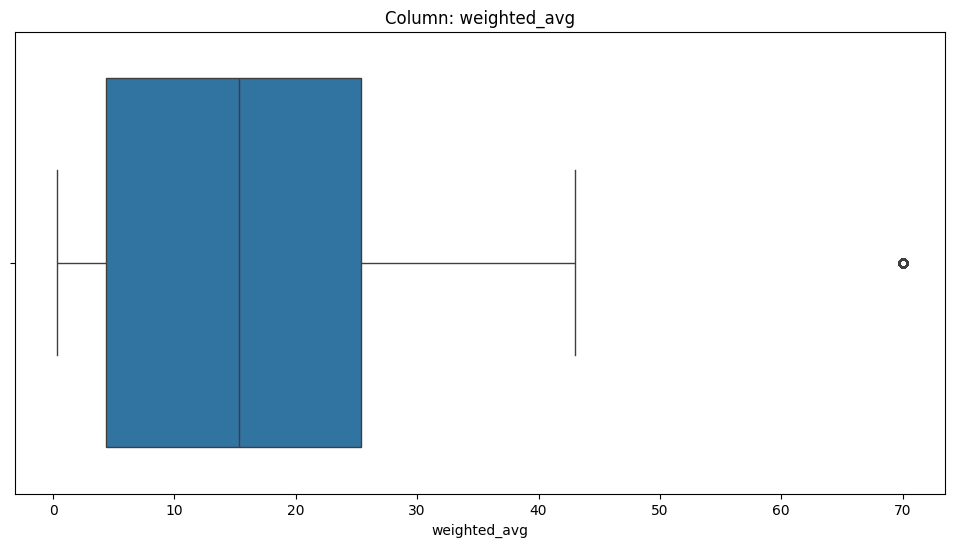

 ------------------ 
 ------------------ 
 ------------------ 


In [93]:
plot_value_distributions_in_df(safe_driving_with_accidents_df[['weighted_avg']] , columns_to_avoid = [])

In [94]:
safe_driving_with_accidents_df[['weighted_avg']].describe()

weighted_avg
count   7694.000000
mean      17.800970
std       16.124590
min        0.333333
25%        4.333333
50%       15.333333
75%       25.333333
max       70.000000

In [95]:
safe_driving_with_accidents_df['y_var'] = safe_driving_with_accidents_df['weighted_avg'].apply(lambda row:'low-risk'  if row <   safe_driving_with_accidents_df['weighted_avg'].mean() else 'high-risk')

### Let's drop columns which are not important after the merge

In [96]:
drop_columns_in_df(safe_driving_with_accidents_df , ['street'])


In [97]:
safe_driving_with_accidents_df.head(10)

eventid             event_start               event_end  \
0  5653658.0 2018-01-01 00:18:20.500 2018-01-01 00:18:28.500   
1  5653662.0 2018-01-01 00:21:41.100 2018-01-01 00:21:43.500   
2  5653659.0 2018-01-01 00:22:54.500 2018-01-01 00:23:01.500   
3  5653663.0 2018-01-01 00:24:33.800 2018-01-01 00:24:35.500   
4  5653660.0 2018-01-01 00:24:42.500 2018-01-01 00:24:49.500   
5  5653664.0 2018-01-01 00:25:07.900 2018-01-01 00:25:09.700   
6  5879594.0 2018-01-01 00:27:43.500 2018-01-01 00:27:49.500   
7  5493833.0 2018-01-01 00:51:05.600 2018-01-01 00:51:06.900   
8  5493832.0 2018-01-01 00:51:34.000 2018-01-01 00:51:41.000   
9  5718272.0 2018-01-01 01:01:46.500 2018-01-01 01:01:49.200   

   duration_seconds  latitude  longitude  speed_kmh  end_speed_kmh  maxwaarde  \
0          0.644292  51.59962   4.749473   2.097041       2.079379   1.919038   
1         -0.541123  51.59909   4.791214  -0.595707      -0.256241  -0.771171   
2          0.432611  51.59847   4.800009   1.086868       1.078177   1.214675   
3         -0.689300  51.59342   4.804034  -1.016612      -0.839757  -0.774298   
4          0.432611  51.59399   4.804958   1.339411       1.328478   1.919038   
5         -0.668131  51.59563   4.808778  -0.679888      -1.006624  -0.769608   
6          0.220929  51.59777   4.799728   1.086868       1.078177   1.214675   
7         -0.773972  51.57217   4.768219  -0.427345      -0.589456  -0.775861   
8          0.432611  51.57211   4.763133   1.086868       1.245044   1.265009   
9         -0.477618  51.60253   4.720942  -0.595707      -0.422589  -0.772735   

          category incident_severity  road_segment_id              road_name  \
0            speed               sp1      600750243.0      backer en ruebweg   
1  harsh cornering               hc1      600753776.0           doornboslaan   
2            speed               sp1      600892914.0            kapittelweg   
3  harsh cornering               hc1      600941106.0         teteringsedijk   
4            speed               sp1      600941096.0         teteringsedijk   
5  harsh cornering               hc1      600754837.0        oosterhoutseweg   
6            speed               sp1      600892914.0            kapittelweg   
7  harsh cornering               hc1      600121497.0  willem van oranjelaan   
8            speed               sp1      600914069.0    graaf engelbertlaan   
9  harsh cornering               hc1      217203086.0      backer en ruebweg   

   last_hour_wind_avg  last_hour_temp_avg  last_hour_rain_avg  \
0            1.791143            1.197395           -0.234421   
1            1.715779            1.188755           -0.234421   
2            1.715779            1.188755           -0.234421   
3            1.715779            1.188755           -0.234421   
4            1.715779            1.188755           -0.234421   
5            1.715779            1.188755           -0.234421   
6            1.715779            1.188755           -0.234421   
7            1.671599            1.168594           -0.207451   
8            1.671599            1.168594           -0.207451   
9            1.666402            1.154194           -0.207451   

   injury_or_fatal_sum  material_damage_only_sum  weighted_avg      y_var  
0                 21.0                     168.0     70.000000  high-risk  
1                 14.0                      49.0     25.666667  high-risk  
2                  7.0                      32.0     15.333333   low-risk  
3                  4.0                      17.0      8.333333   low-risk  
4                  4.0                      17.0      8.333333   low-risk  
5                 18.0                      35.0     23.666667  high-risk  
6                  7.0                      32.0     15.333333   low-risk  
7                  3.0                       8.0      4.666667   low-risk  
8                  5.0                      78.0     29.333333  high-risk  
9                 21.0                     168.0   

### This is the dataframe for modelling:


In [98]:
safe_driving_with_accidents_df.head(10)

eventid             event_start               event_end  \
0  5653658.0 2018-01-01 00:18:20.500 2018-01-01 00:18:28.500   
1  5653662.0 2018-01-01 00:21:41.100 2018-01-01 00:21:43.500   
2  5653659.0 2018-01-01 00:22:54.500 2018-01-01 00:23:01.500   
3  5653663.0 2018-01-01 00:24:33.800 2018-01-01 00:24:35.500   
4  5653660.0 2018-01-01 00:24:42.500 2018-01-01 00:24:49.500   
5  5653664.0 2018-01-01 00:25:07.900 2018-01-01 00:25:09.700   
6  5879594.0 2018-01-01 00:27:43.500 2018-01-01 00:27:49.500   
7  5493833.0 2018-01-01 00:51:05.600 2018-01-01 00:51:06.900   
8  5493832.0 2018-01-01 00:51:34.000 2018-01-01 00:51:41.000   
9  5718272.0 2018-01-01 01:01:46.500 2018-01-01 01:01:49.200   

   duration_seconds  latitude  longitude  speed_kmh  end_speed_kmh  maxwaarde  \
0          0.644292  51.59962   4.749473   2.097041       2.079379   1.919038   
1         -0.541123  51.59909   4.791214  -0.595707      -0.256241  -0.771171   
2          0.432611  51.59847   4.800009   1.086868       1.078177   1.214675   
3         -0.689300  51.59342   4.804034  -1.016612      -0.839757  -0.774298   
4          0.432611  51.59399   4.804958   1.339411       1.328478   1.919038   
5         -0.668131  51.59563   4.808778  -0.679888      -1.006624  -0.769608   
6          0.220929  51.59777   4.799728   1.086868       1.078177   1.214675   
7         -0.773972  51.57217   4.768219  -0.427345      -0.589456  -0.775861   
8          0.432611  51.57211   4.763133   1.086868       1.245044   1.265009   
9         -0.477618  51.60253   4.720942  -0.595707      -0.422589  -0.772735   

          category incident_severity  road_segment_id              road_name  \
0            speed               sp1      600750243.0      backer en ruebweg   
1  harsh cornering               hc1      600753776.0           doornboslaan   
2            speed               sp1      600892914.0            kapittelweg   
3  harsh cornering               hc1      600941106.0         teteringsedijk   
4            speed               sp1      600941096.0         teteringsedijk   
5  harsh cornering               hc1      600754837.0        oosterhoutseweg   
6            speed               sp1      600892914.0            kapittelweg   
7  harsh cornering               hc1      600121497.0  willem van oranjelaan   
8            speed               sp1      600914069.0    graaf engelbertlaan   
9  harsh cornering               hc1      217203086.0      backer en ruebweg   

   last_hour_wind_avg  last_hour_temp_avg  last_hour_rain_avg  \
0            1.791143            1.197395           -0.234421   
1            1.715779            1.188755           -0.234421   
2            1.715779            1.188755           -0.234421   
3            1.715779            1.188755           -0.234421   
4            1.715779            1.188755           -0.234421   
5            1.715779            1.188755           -0.234421   
6            1.715779            1.188755           -0.234421   
7            1.671599            1.168594           -0.207451   
8            1.671599            1.168594           -0.207451   
9            1.666402            1.154194           -0.207451   

   injury_or_fatal_sum  material_damage_only_sum  weighted_avg      y_var  
0                 21.0                     168.0     70.000000  high-risk  
1                 14.0                      49.0     25.666667  high-risk  
2                  7.0                      32.0     15.333333   low-risk  
3                  4.0                      17.0      8.333333   low-risk  
4                  4.0                      17.0      8.333333   low-risk  
5                 18.0                      35.0     23.666667  high-risk  
6                  7.0                      32.0     15.333333   low-risk  
7                  3.0                       8.0      4.666667   low-risk  
8                  5.0                      78.0     29.333333  high-risk  
9                 21.0                     168.0   

# Exploratory Data Analysis (EDA)

In [99]:
# Show general information about the dataframe
def show_dataframe_general_info(df):
    print("General info of df")
    print(df.info())
    print("Description of df")
    print(df.describe())

show_dataframe_general_info(safe_driving_df)

General info of df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   eventid             8000 non-null   float64       
 1   event_start         8000 non-null   datetime64[ns]
 2   event_end           8000 non-null   datetime64[ns]
 3   duration_seconds    8000 non-null   float64       
 4   latitude            8000 non-null   float64       
 5   longitude           8000 non-null   float64       
 6   speed_kmh           8000 non-null   float64       
 7   end_speed_kmh       8000 non-null   float64       
 8   maxwaarde           8000 non-null   float64       
 9   category            8000 non-null   object        
 10  incident_severity   8000 non-null   object        
 11  road_segment_id     8000 non-null   float64       
 12  road_name           8000 non-null   object        
 13  last_hour_wind_avg  8000 non-

In [100]:
# Check for missing values
def check_df_missing_values(df):
    total_missing_values = df.isna().sum().sum()
    print(f"Total number of missing values: {total_missing_values}")
    if total_missing_values > 0:
        print("Number of missing values in particular columns:")
        print(df.isna().sum())

check_df_missing_values(safe_driving_df)

Total number of missing values: 0


In [101]:
# Define necessary numerical features
important_numerical_features = [
    'duration_seconds', 'latitude', 'longitude', 
    'speed_kmh', 'end_speed_kmh', 'maxwaarde', 
    'last_hour_wind_avg', 'last_hour_temp_avg', 'last_hour_rain_avg'
]

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


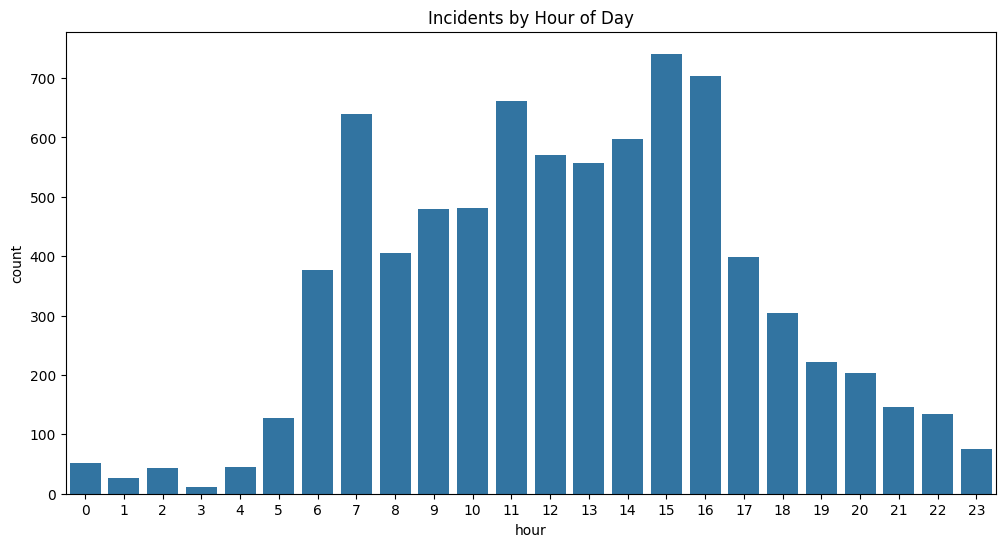

In [102]:
# Temporal analysis
safe_driving_df['event_start'] = pd.to_datetime(safe_driving_df['event_start'])
safe_driving_df['event_end'] = pd.to_datetime(safe_driving_df['event_end'])

plt.figure(figsize=(12, 6))
safe_driving_df['hour'] = safe_driving_df['event_start'].dt.hour
sns.countplot(x='hour', data=safe_driving_df)
plt.title('Incidents by Hour of Day')
plt.show()

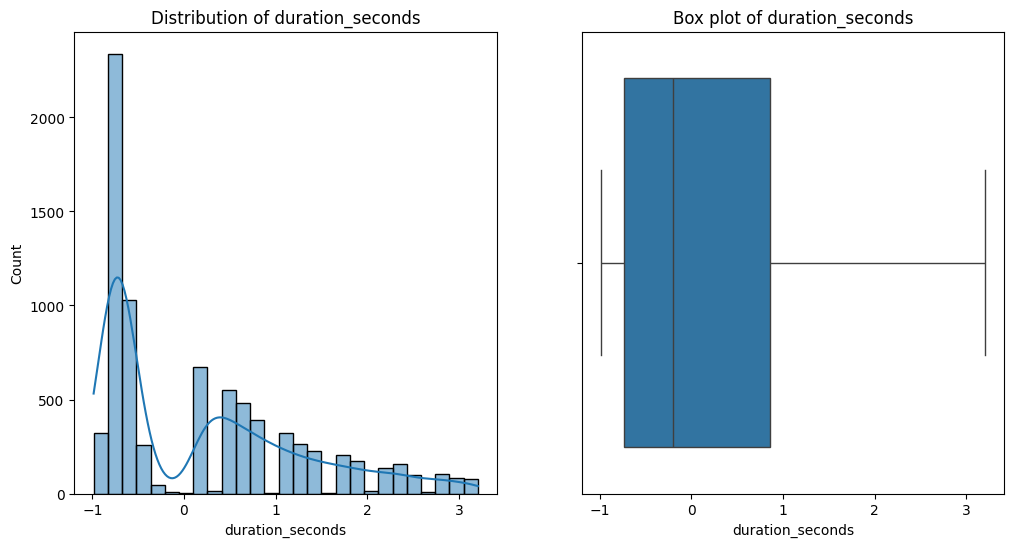

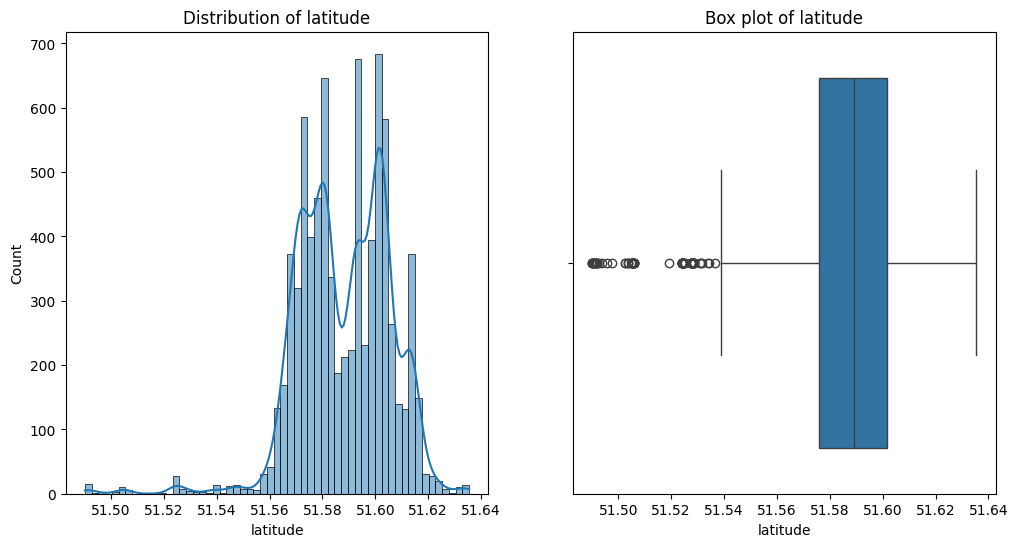

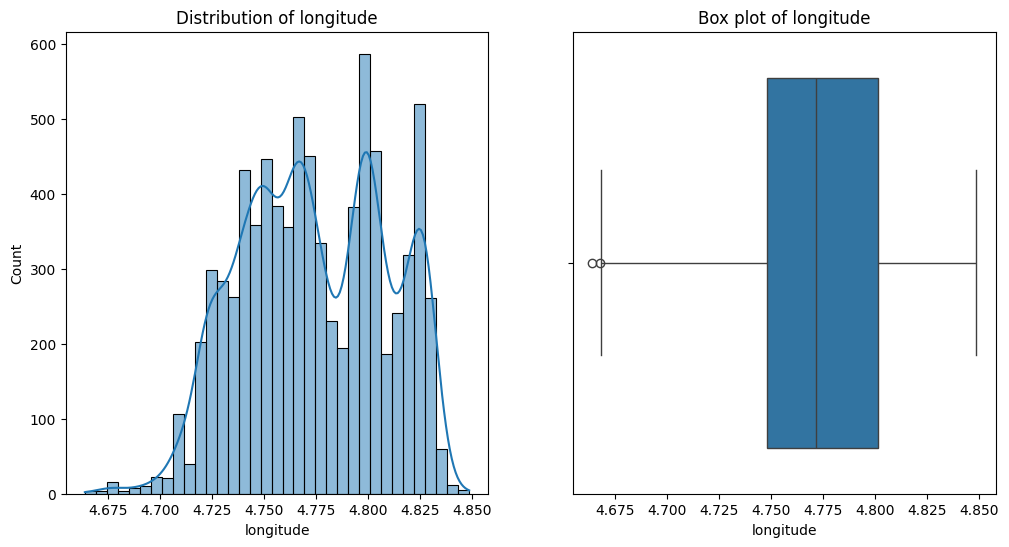

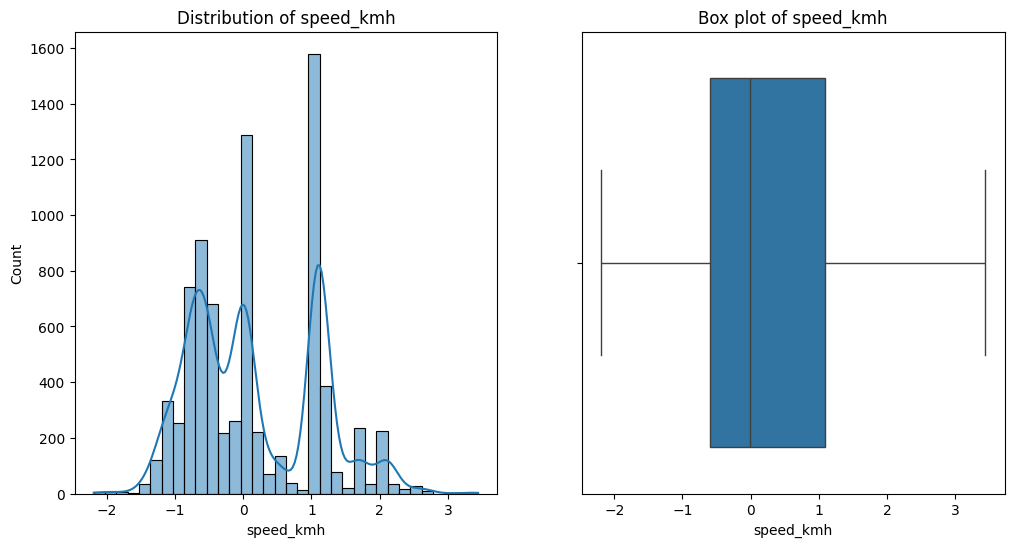

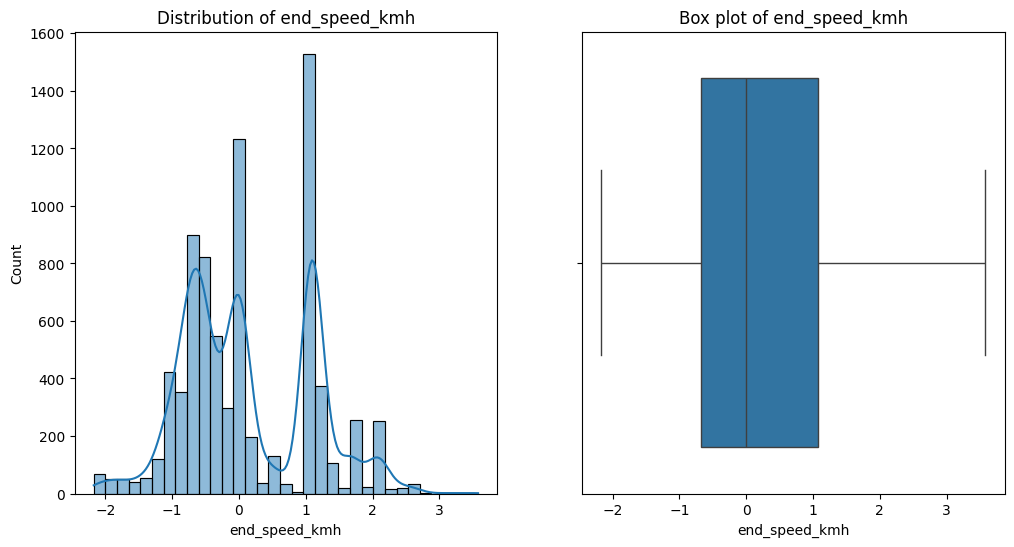

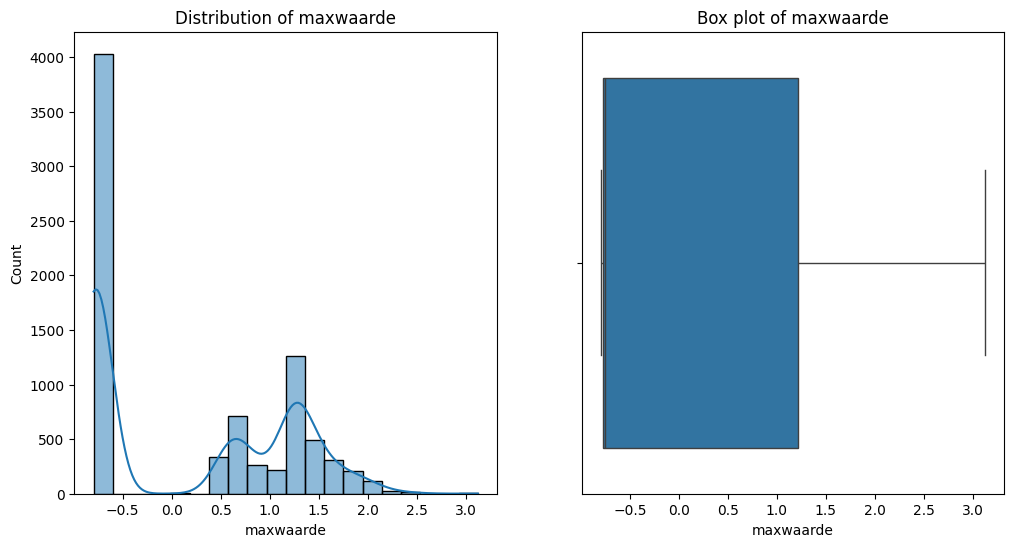

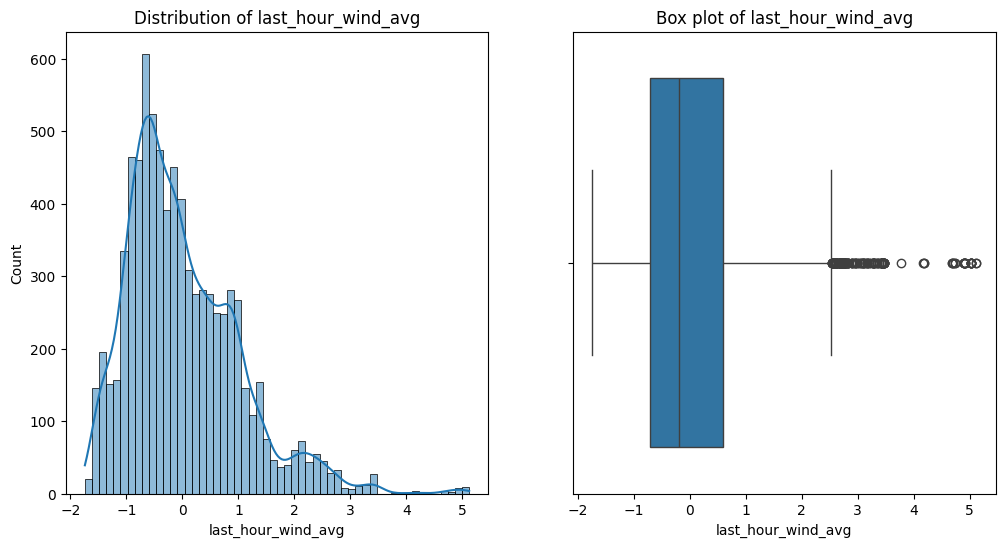

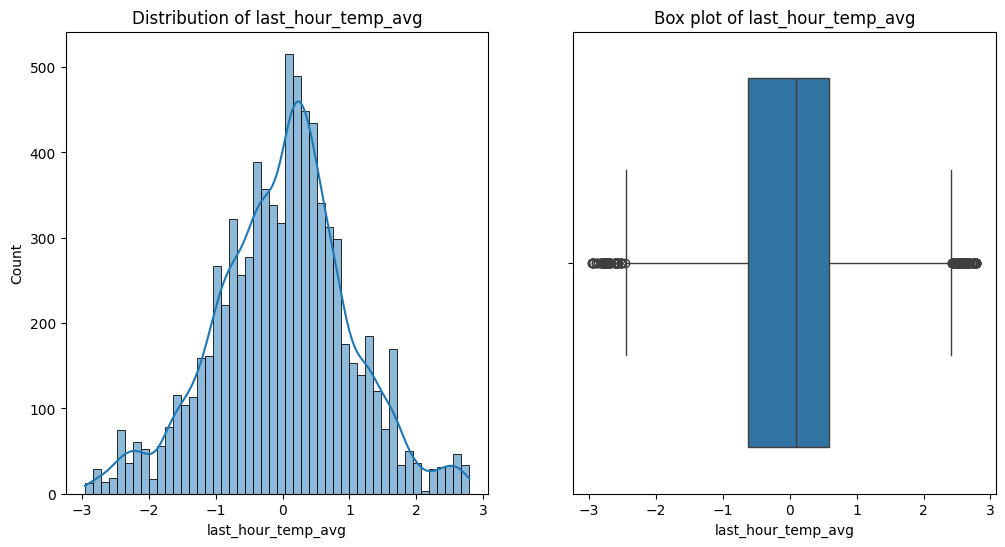

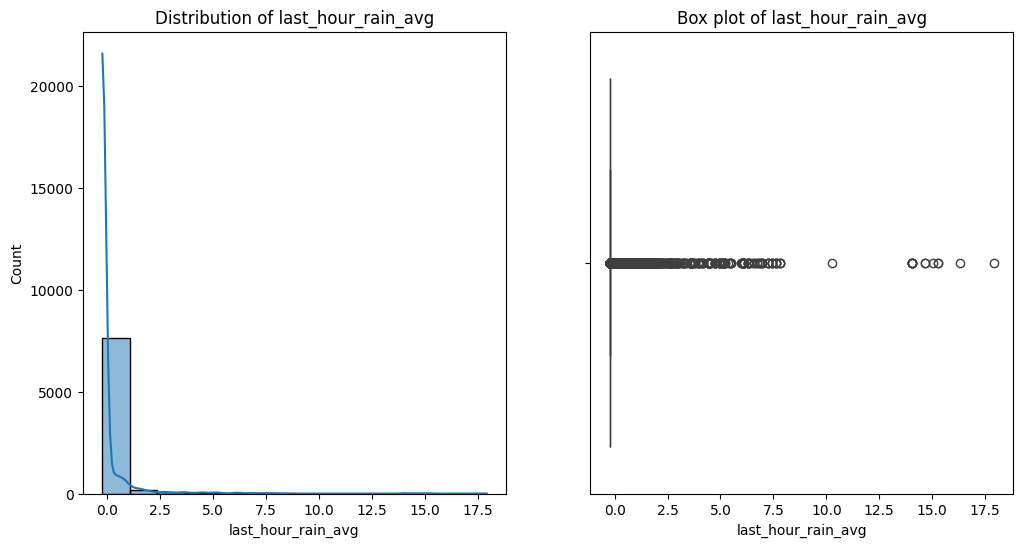

In [103]:
# Plot value distributions
def plot_value_distributions(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in important_numerical_features:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])
        plt.title(f'Box plot of {col}')
        plt.show()

plot_value_distributions(safe_driving_df)

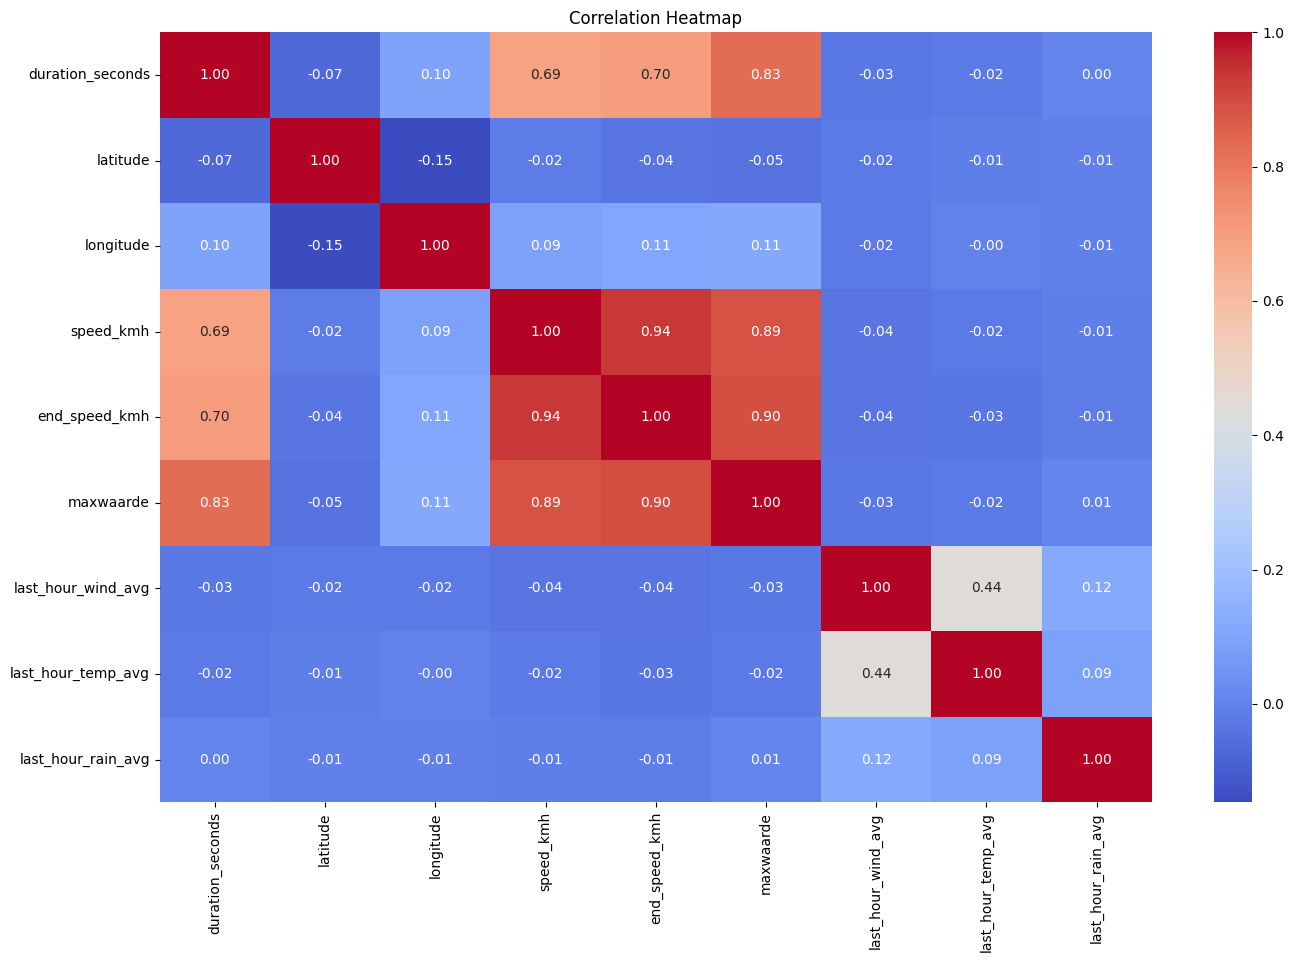

In [104]:
# Correlation heatmap
plt.figure(figsize=(16, 10))
correlation_matrix = safe_driving_df[important_numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

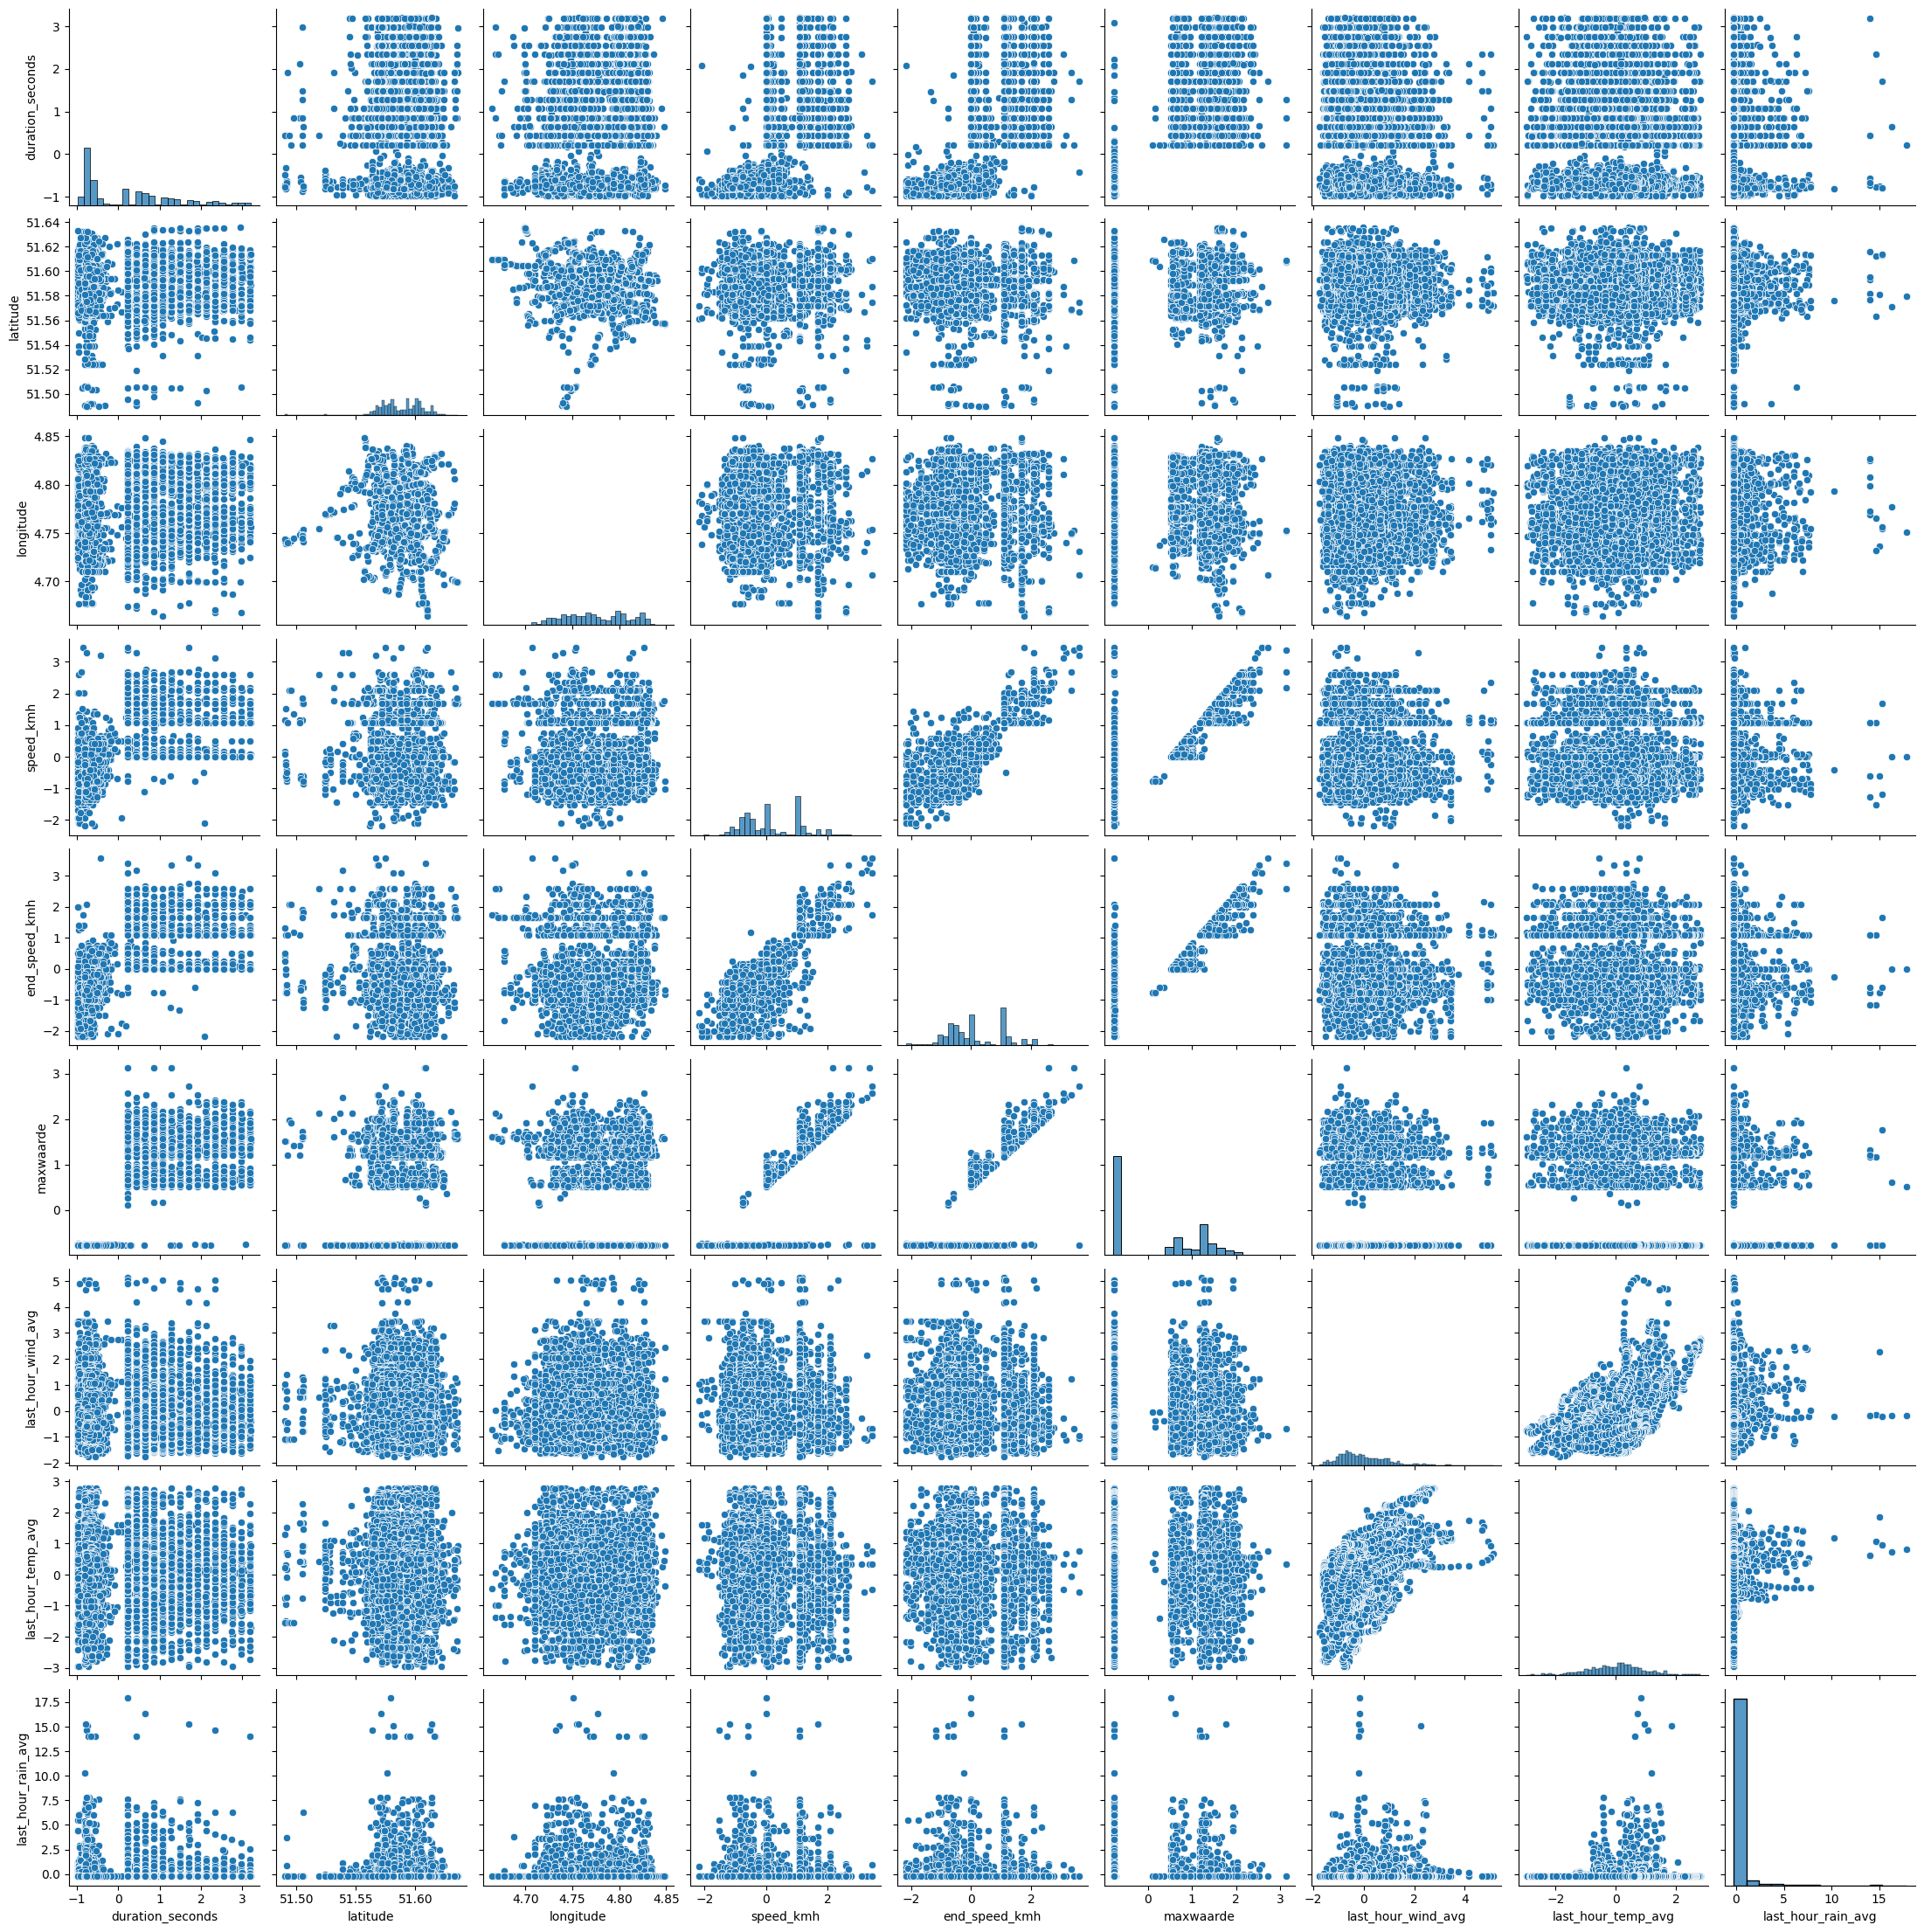

In [105]:
# Pair plots for important numerical features
sns.pairplot(safe_driving_df[important_numerical_features])
plt.show()

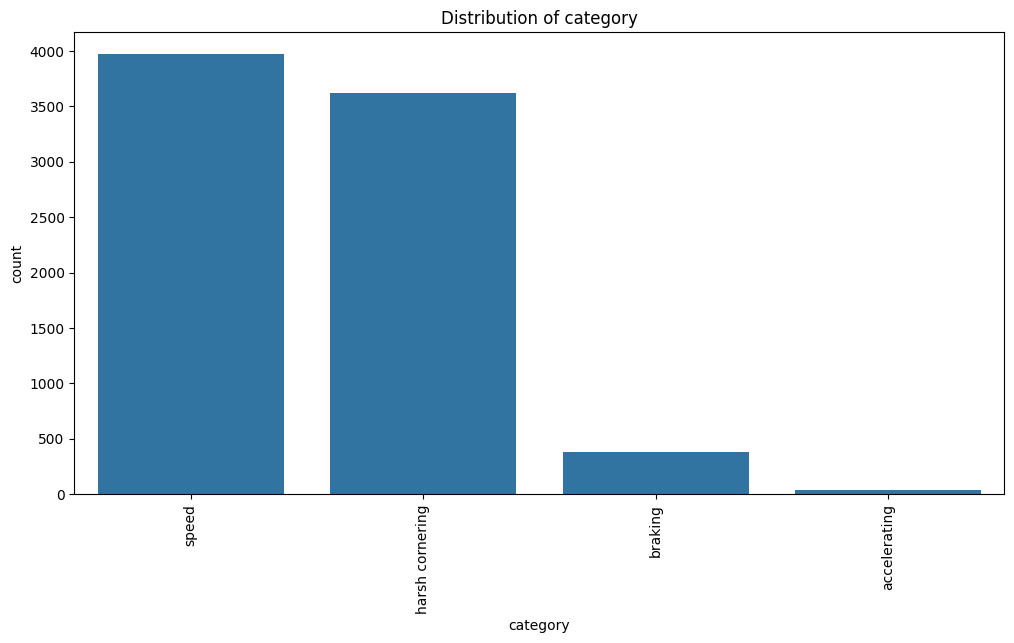

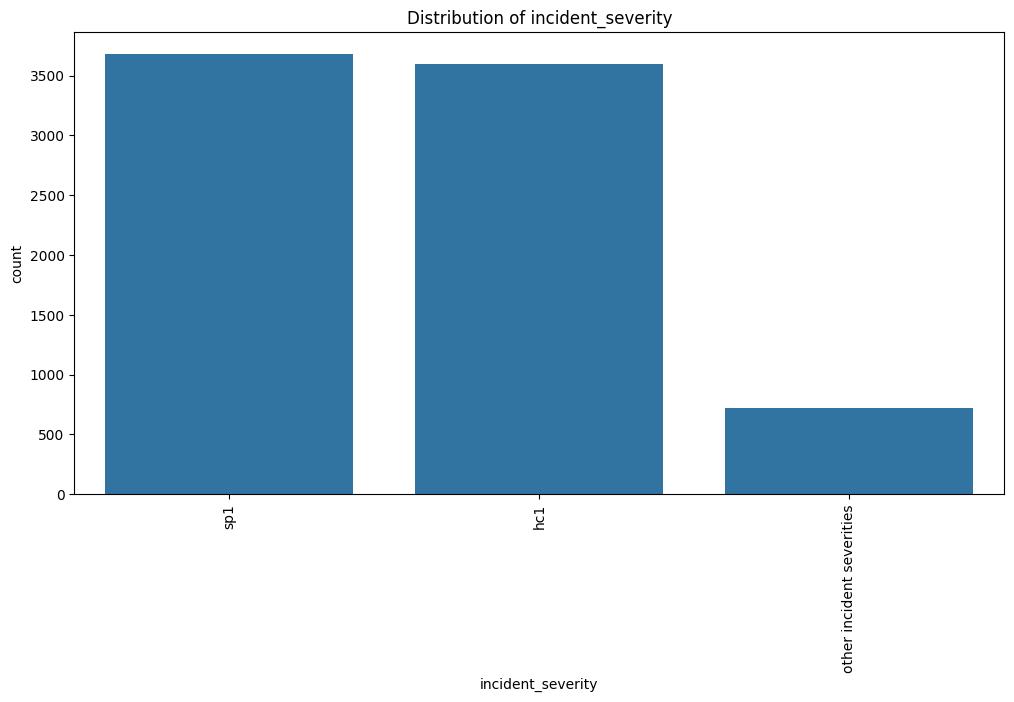

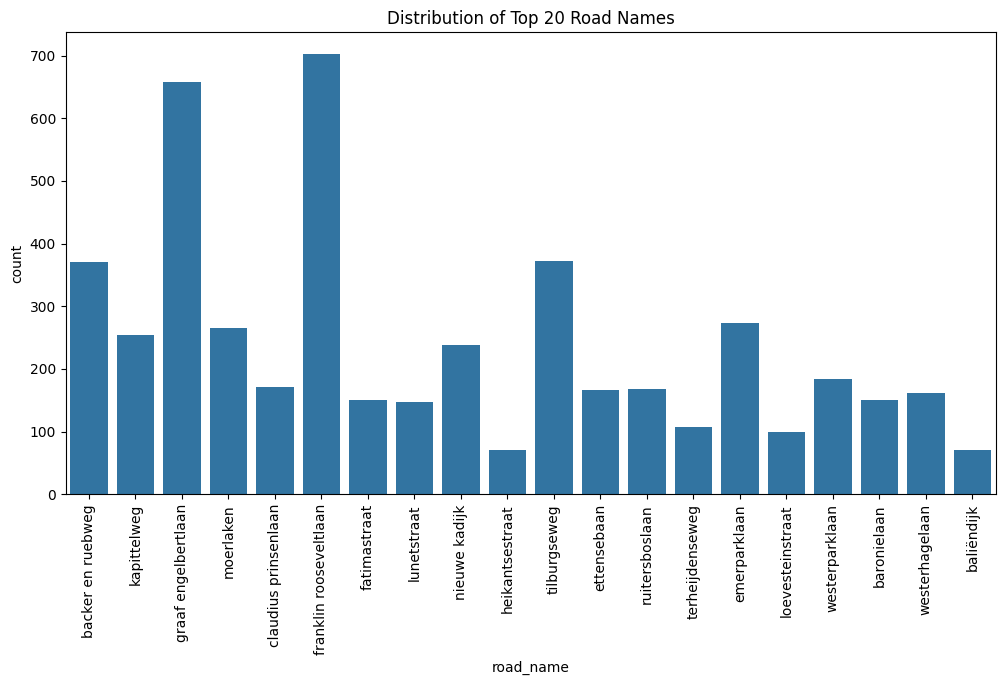

In [106]:
# Distribution of all categorical features

categorical_cols = safe_driving_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    if col == 'road_name':
        top_20_roads = safe_driving_df['road_name'].value_counts().nlargest(20).index
        sns.countplot(x=safe_driving_df[safe_driving_df['road_name'].isin(top_20_roads)]['road_name'])
        plt.title('Distribution of Top 20 Road Names')
    else:
        sns.countplot(x=safe_driving_df[col])
        plt.title(f'Distribution of {col}')
    plt.xticks(rotation=90)
    plt.show()

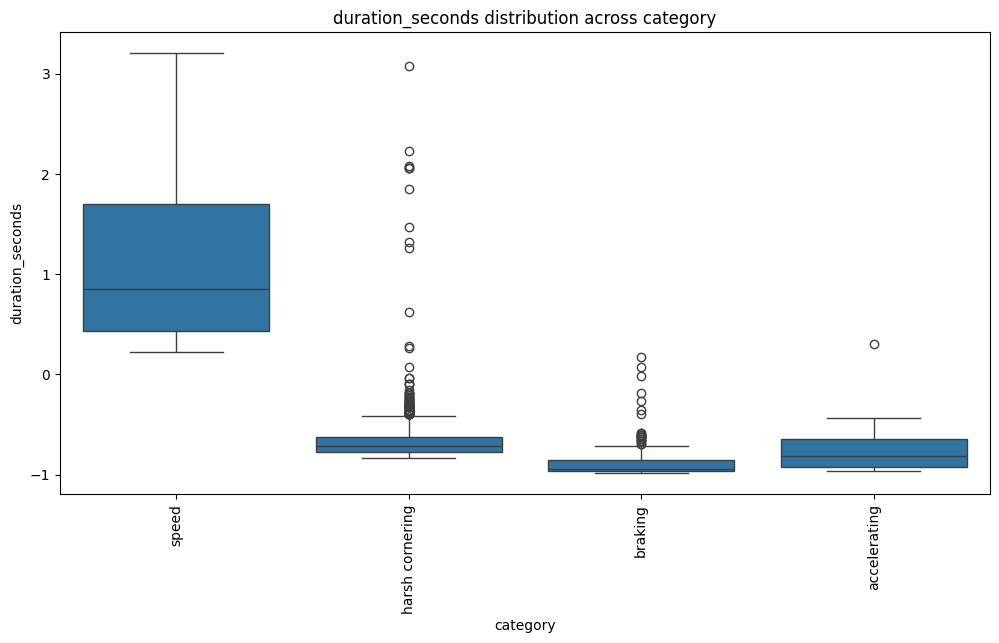

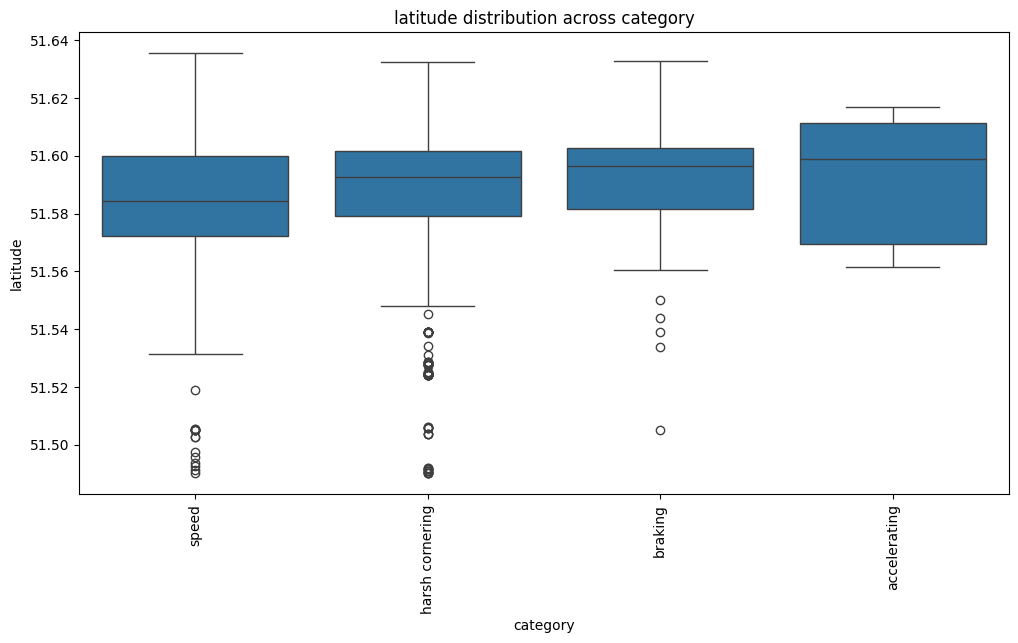

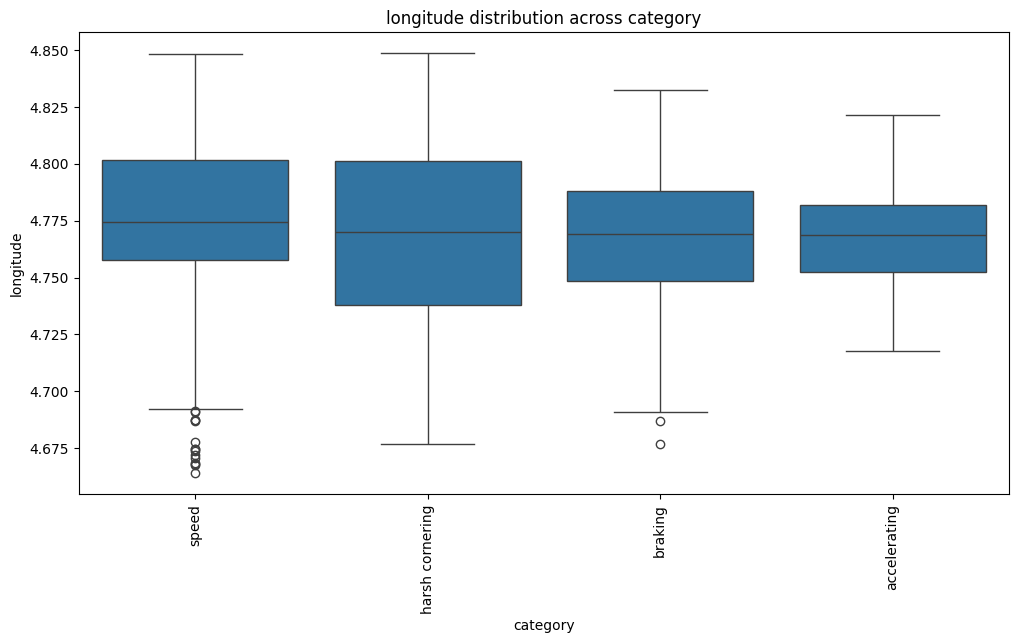

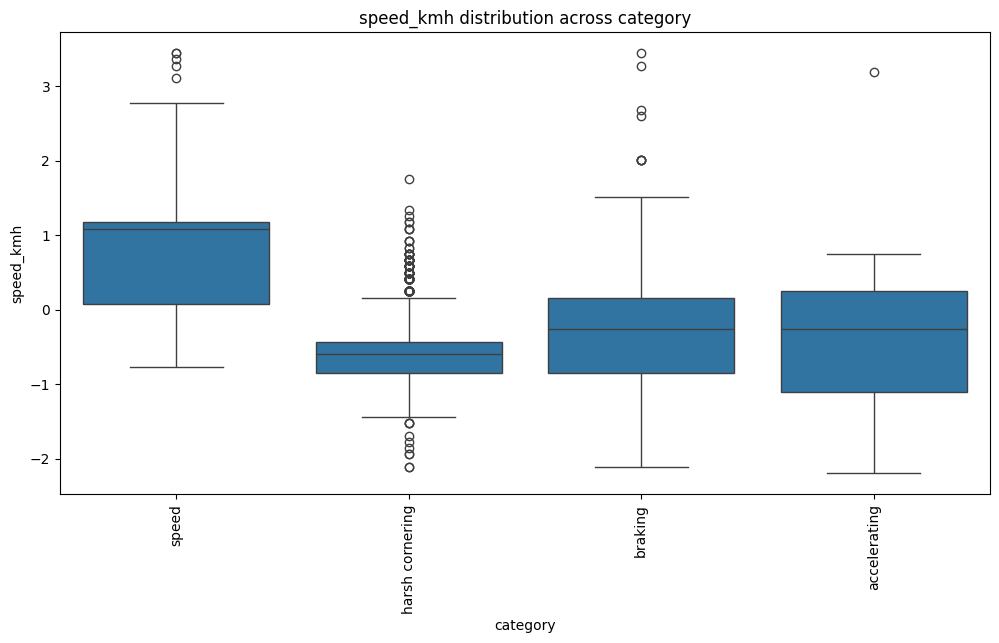

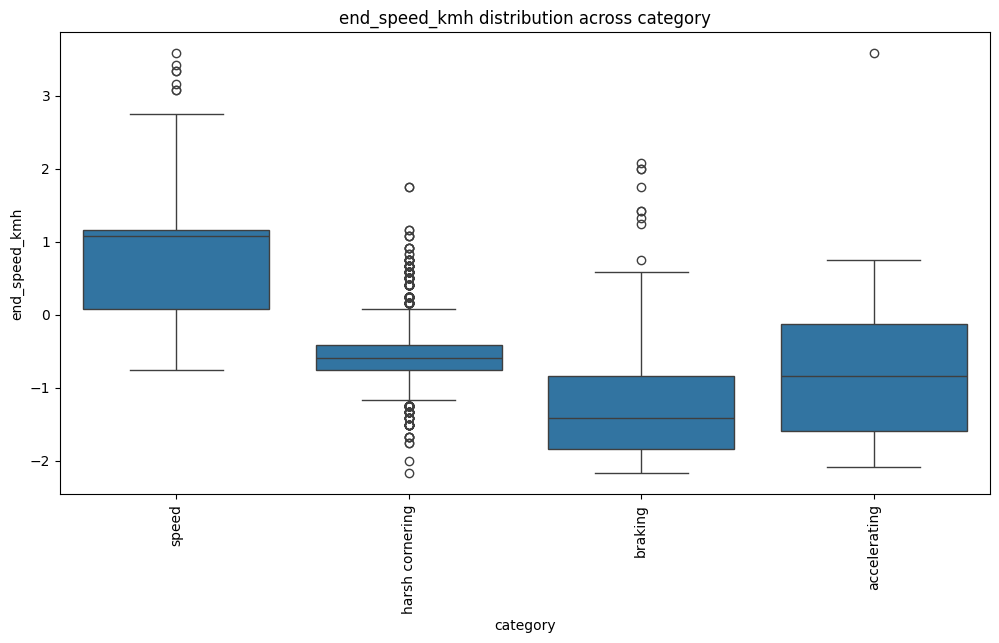

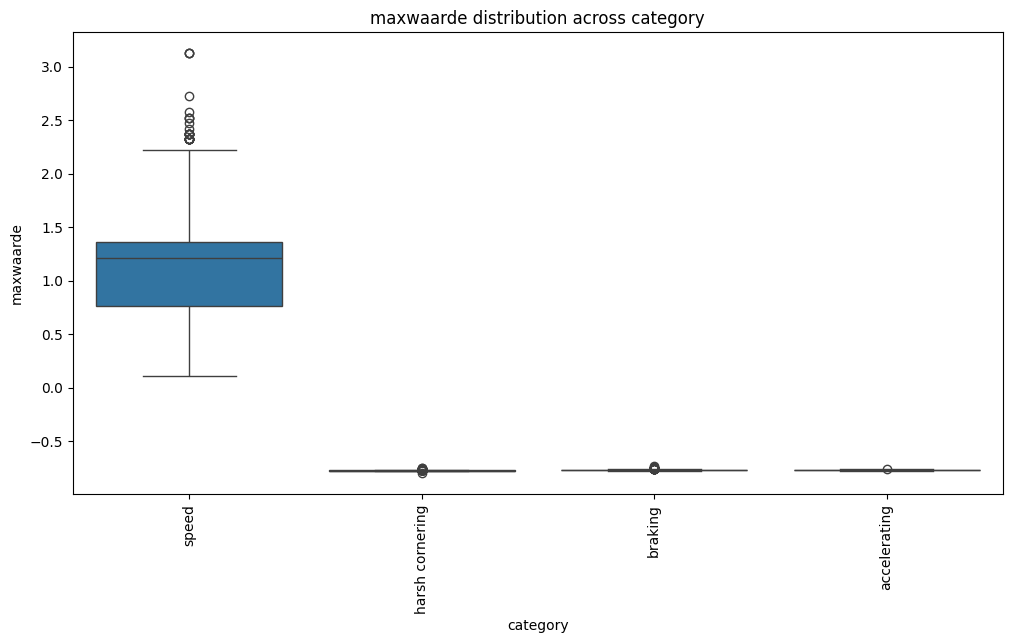

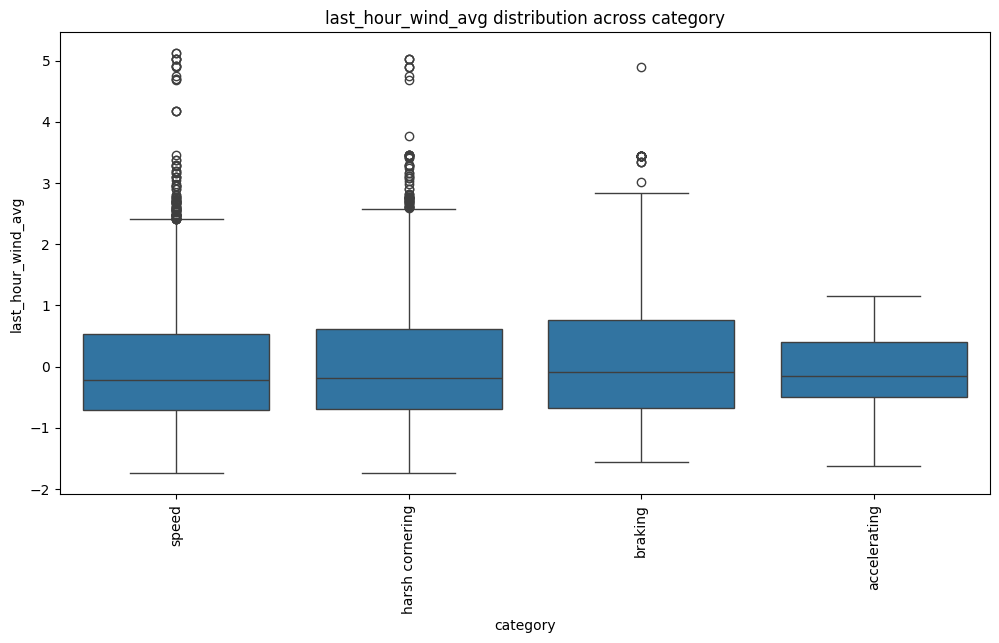

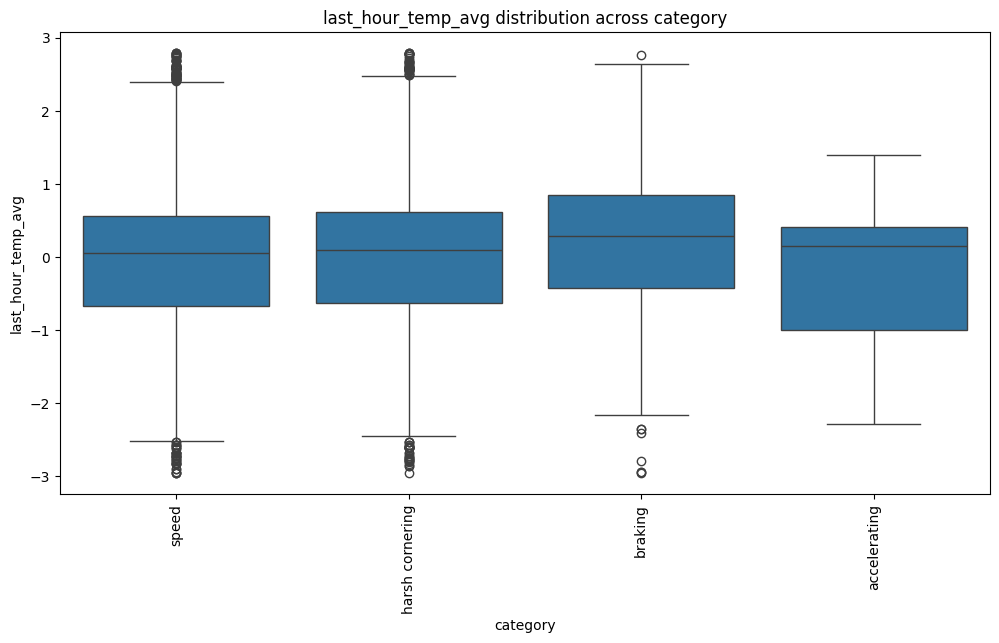

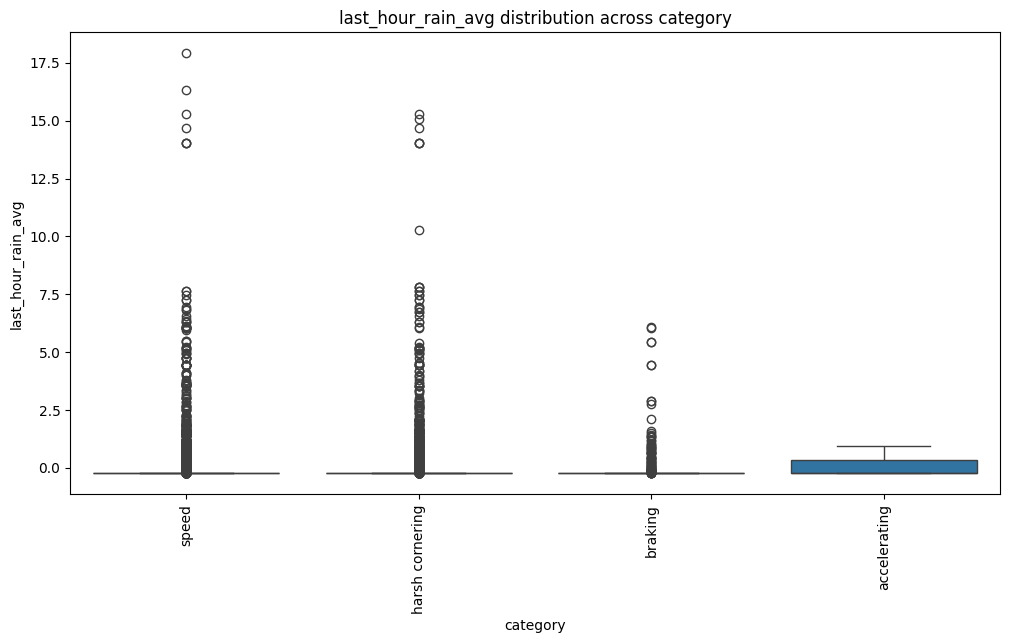

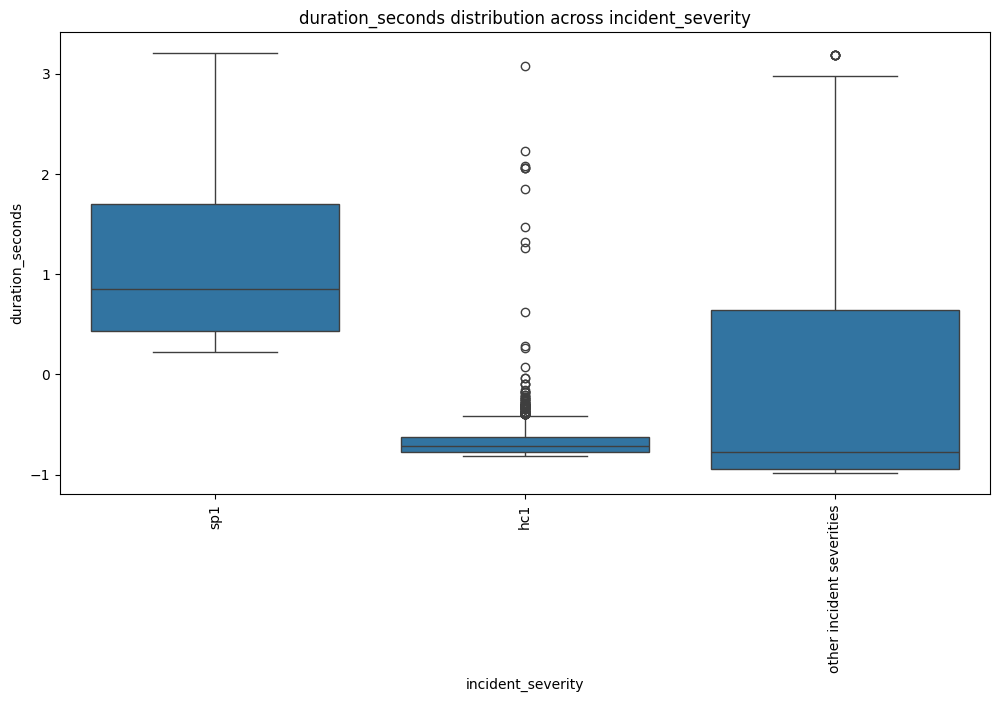

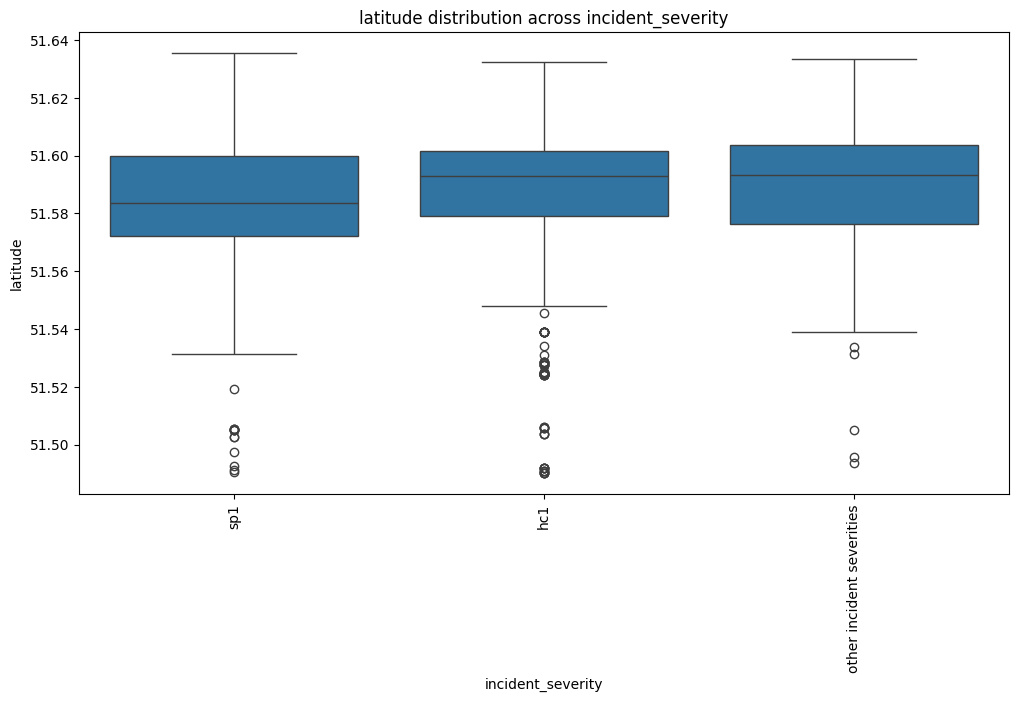

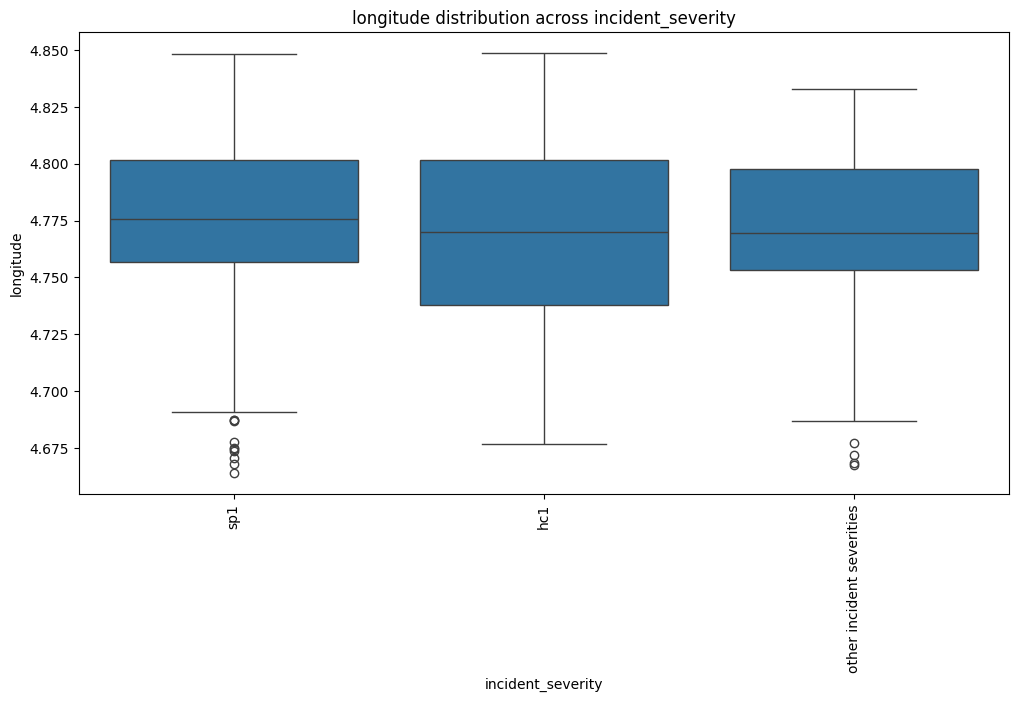

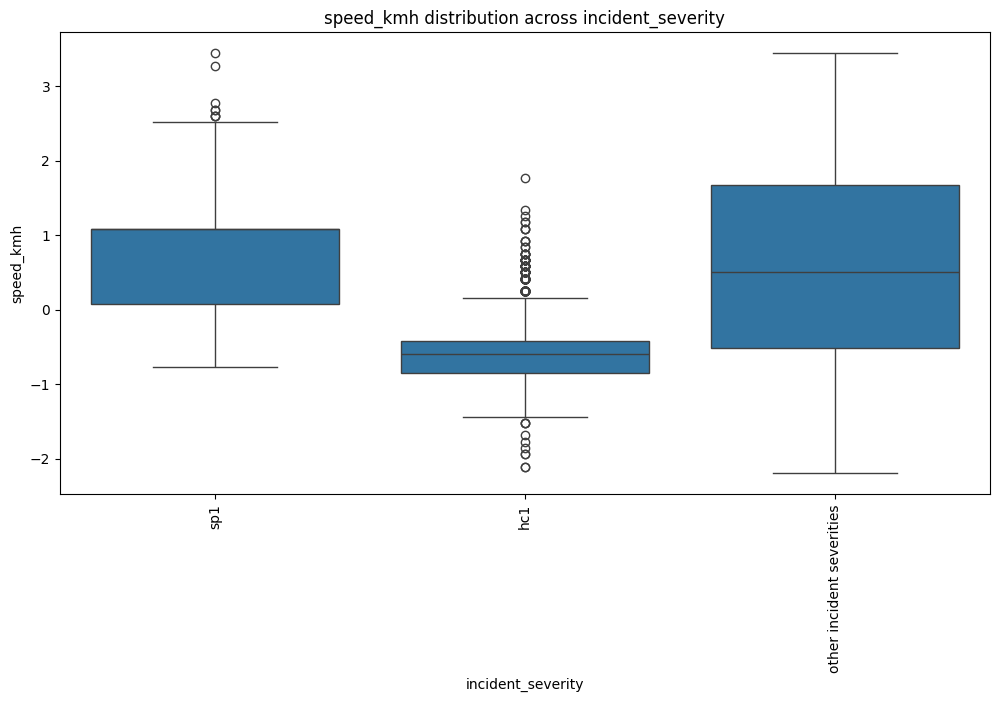

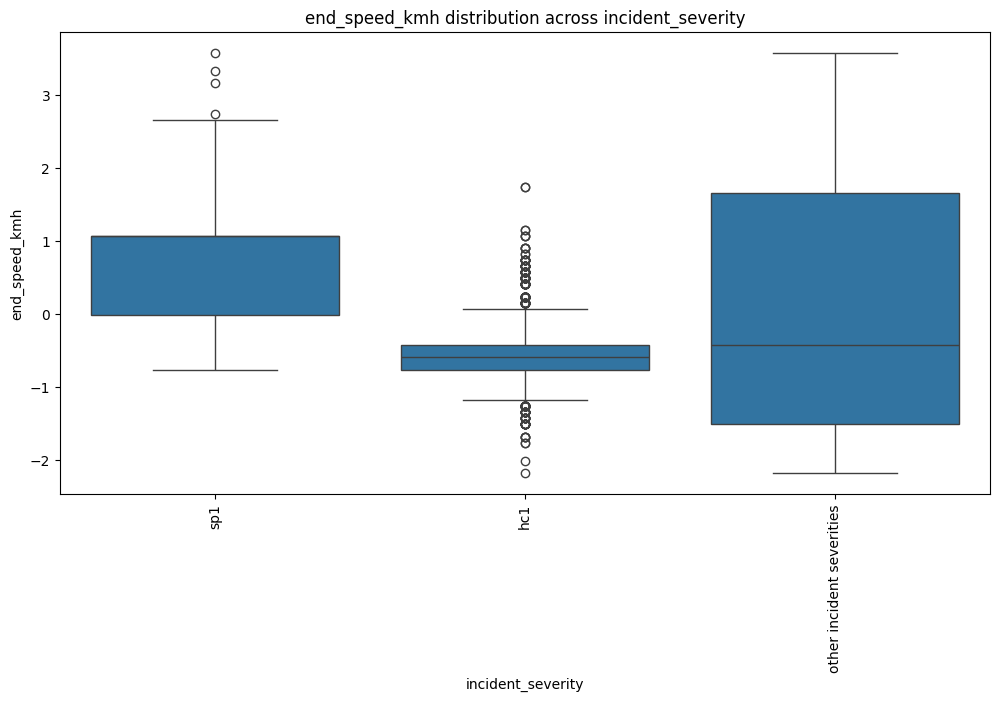

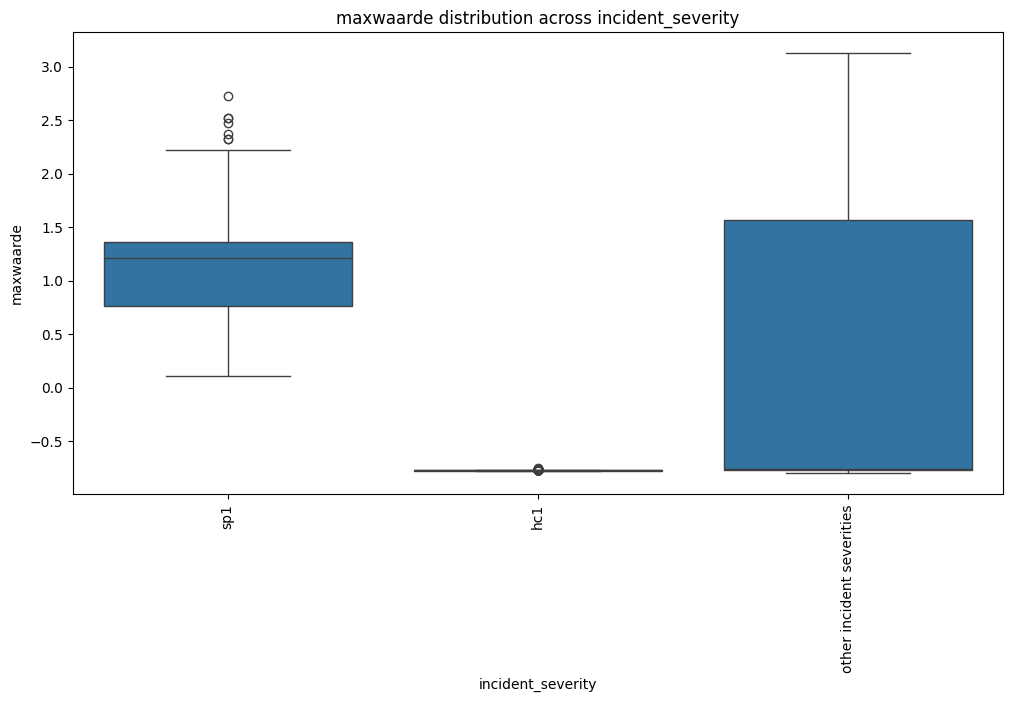

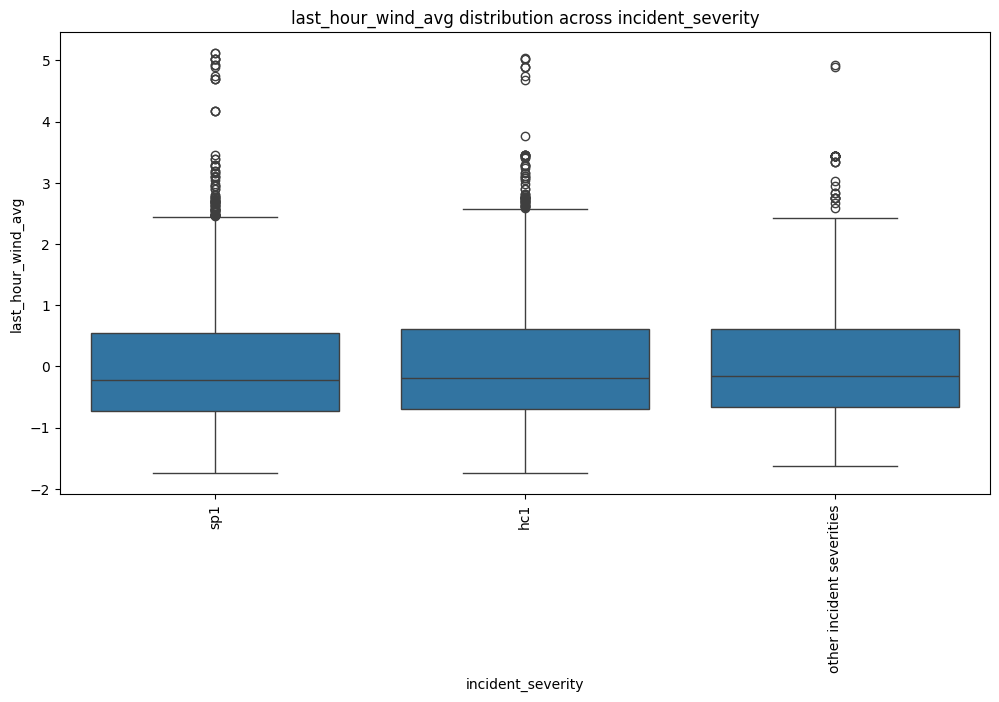

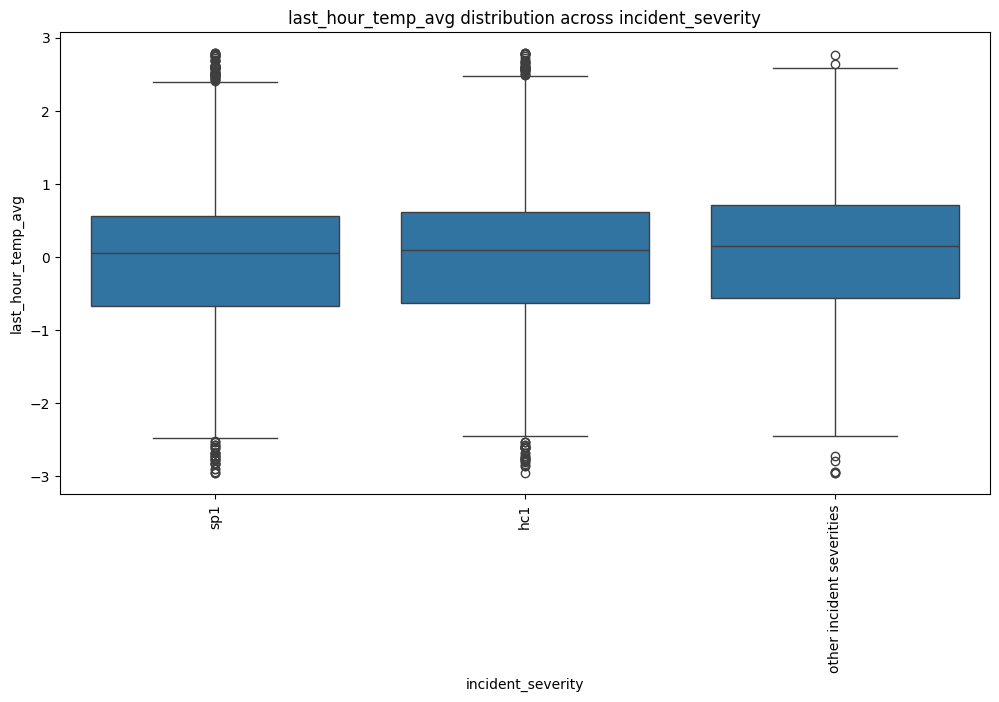

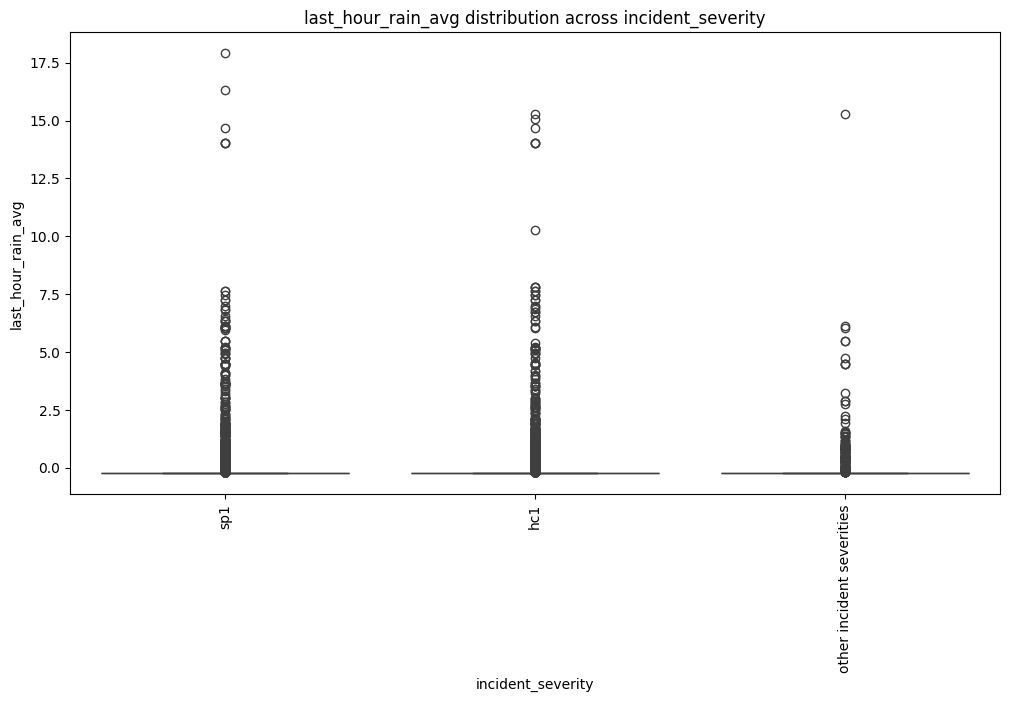

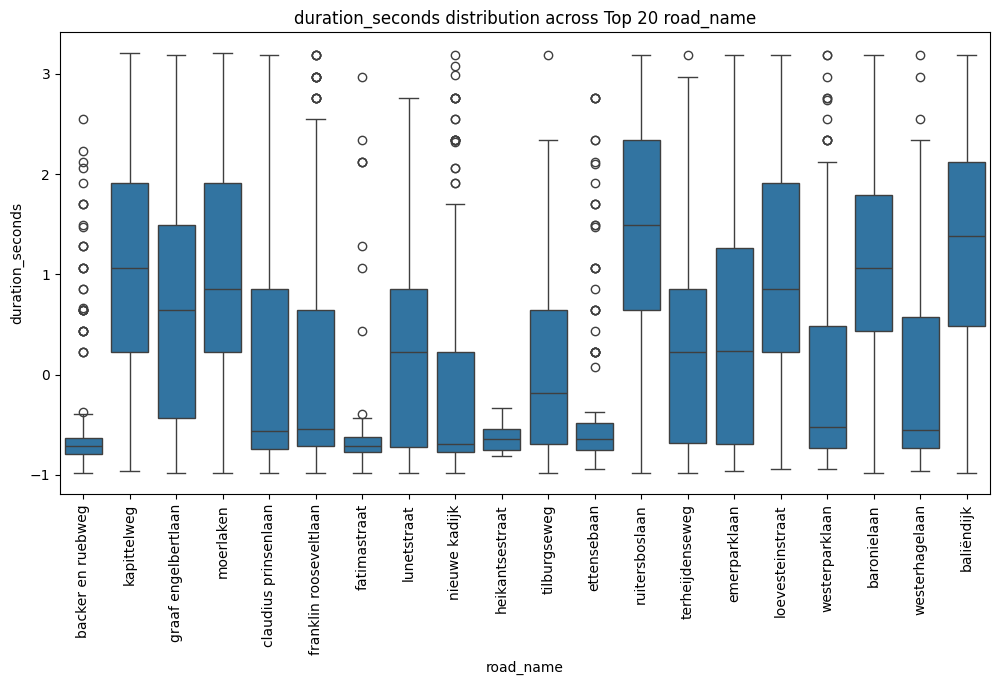

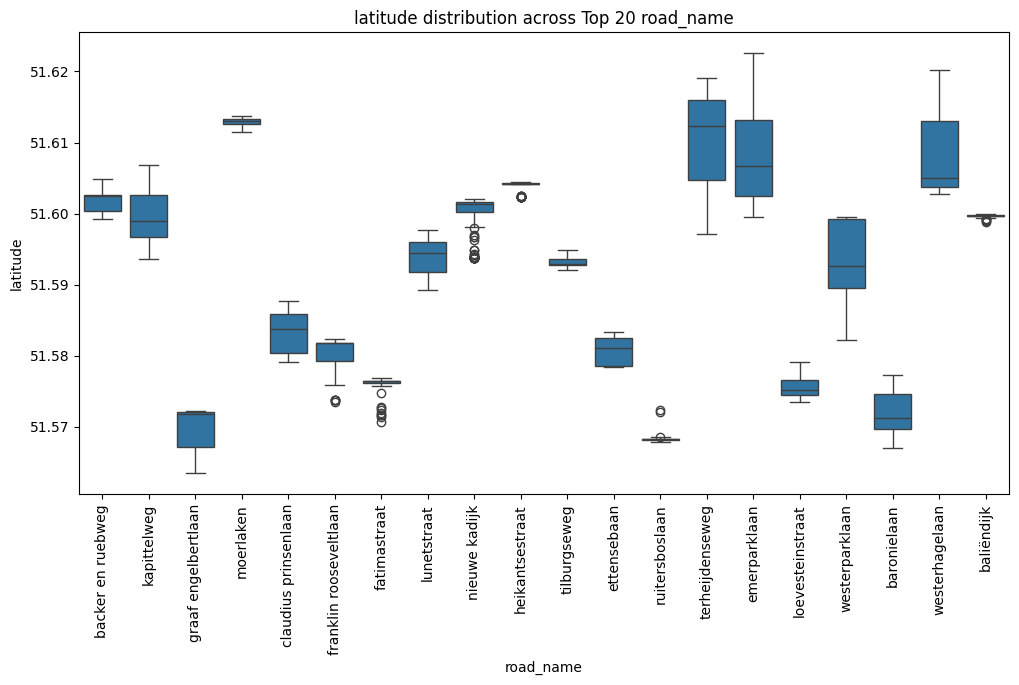

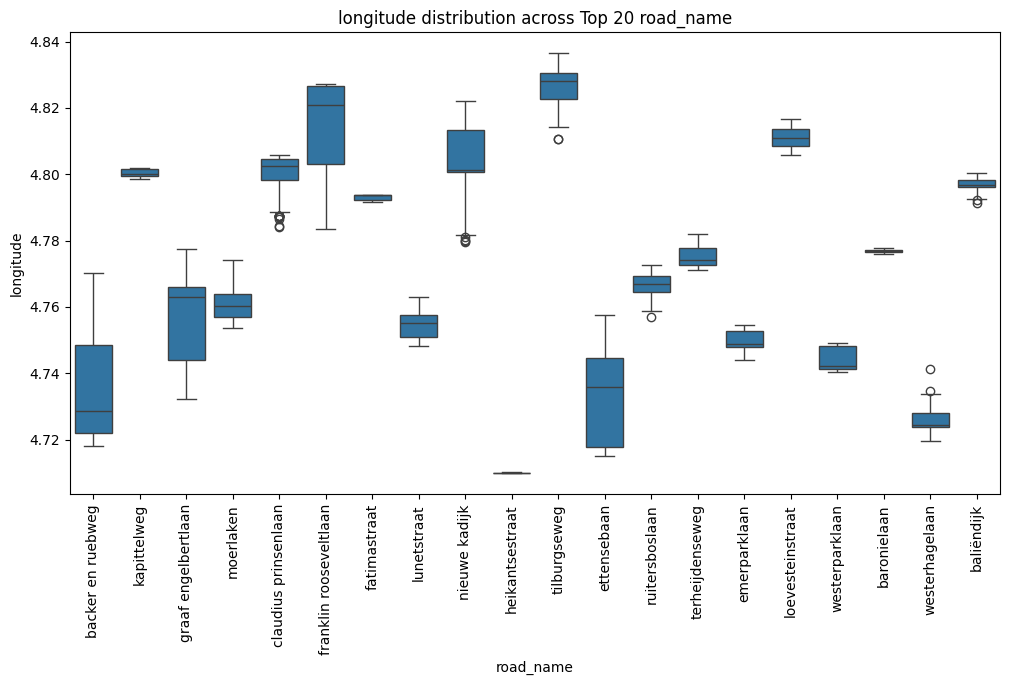

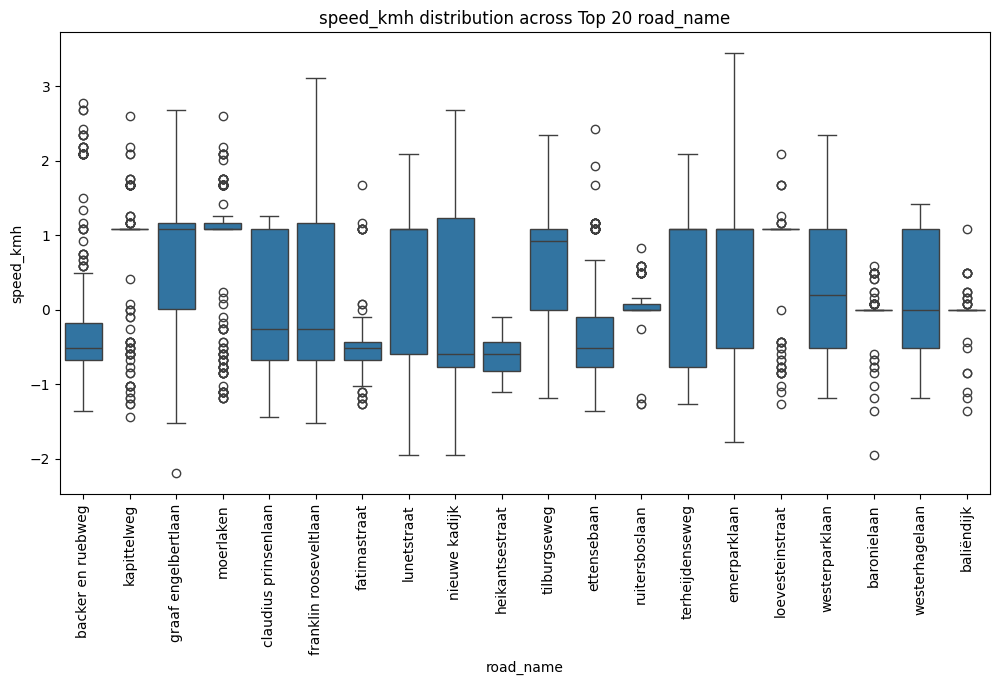

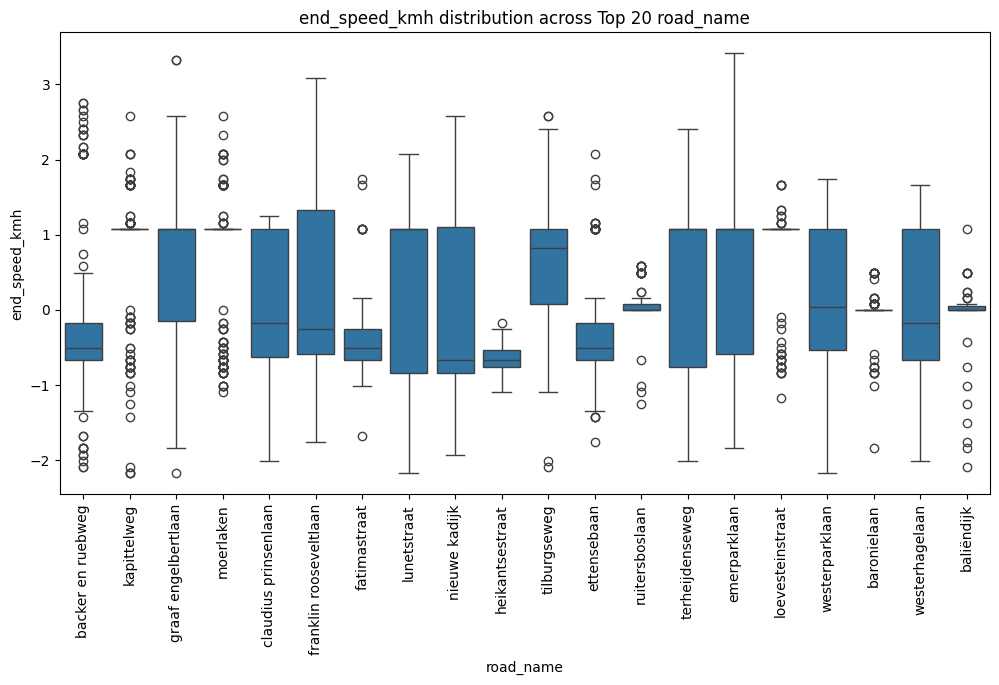

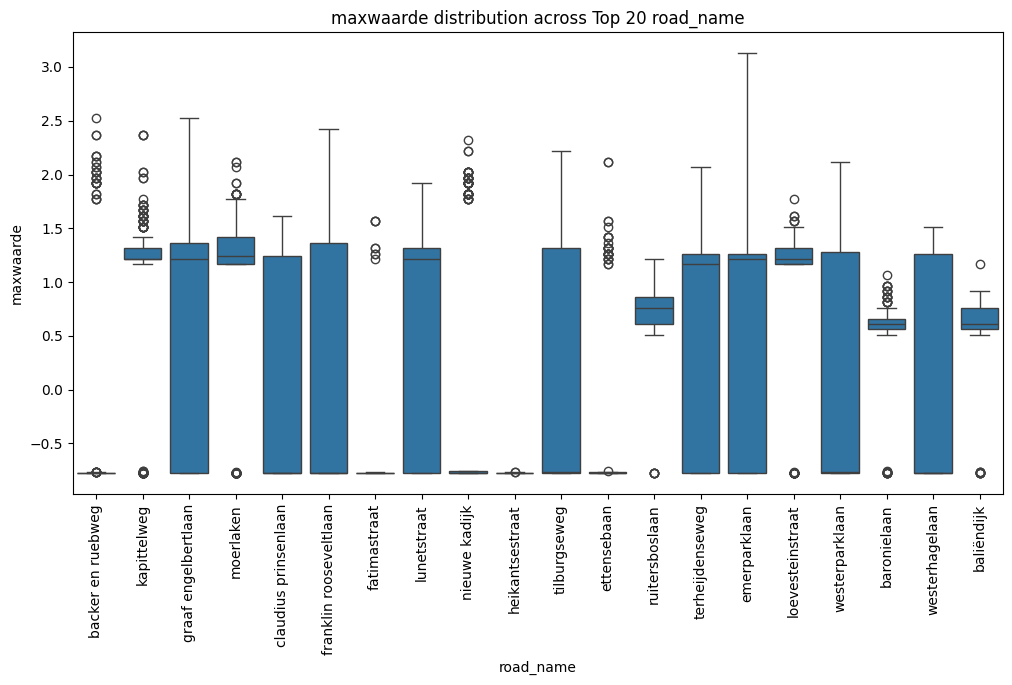

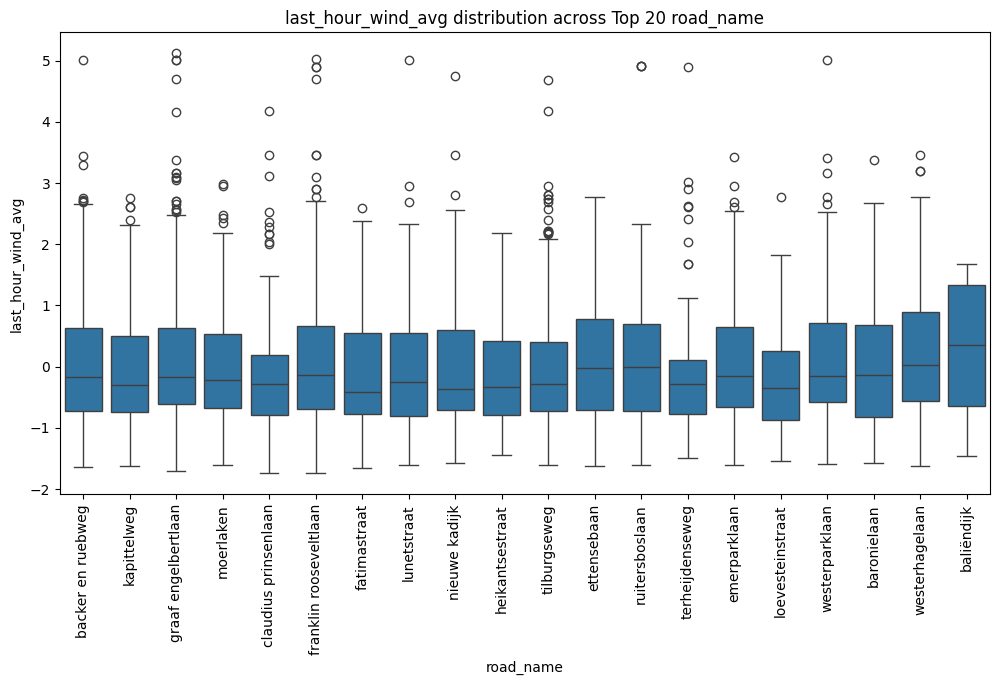

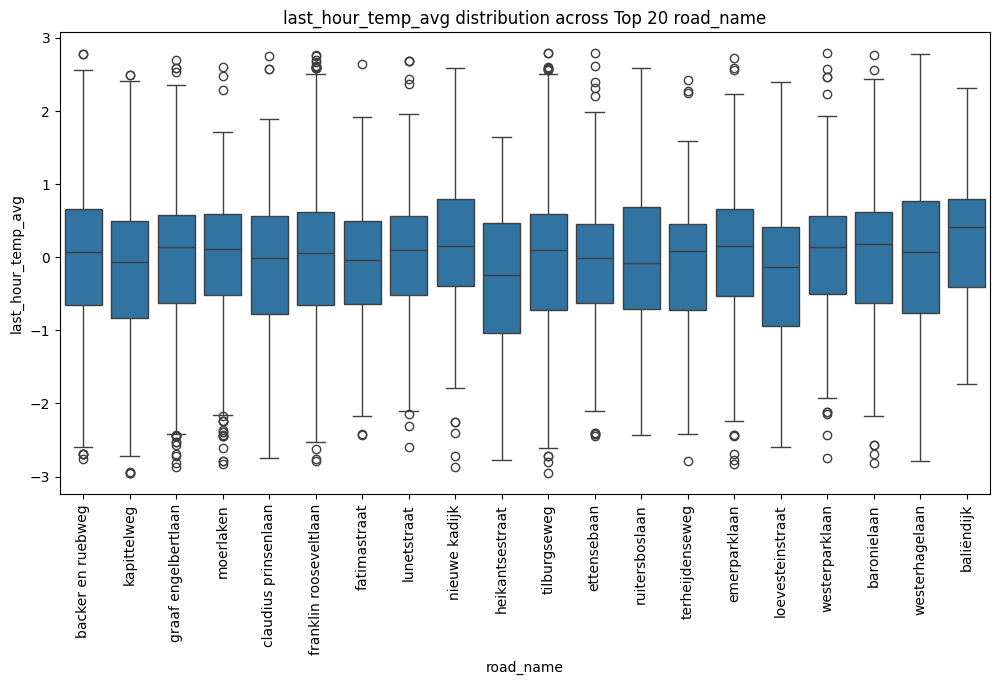

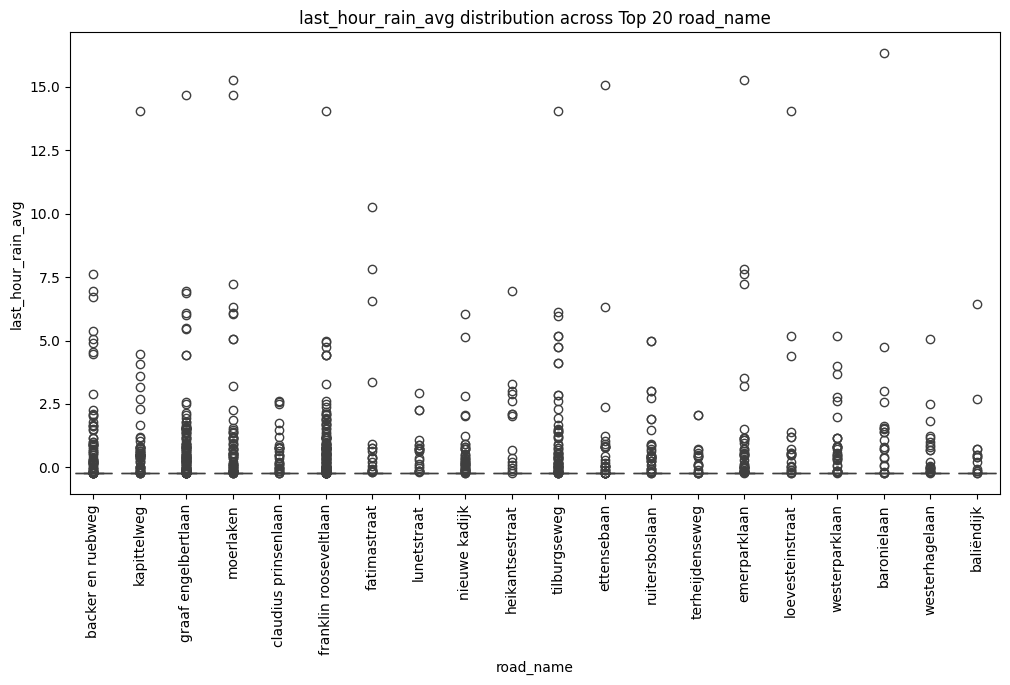

In [107]:
# Box plots for numerical features across all categorical features
categorical_cols = safe_driving_df.select_dtypes(include=['object']).columns

for cat_col in categorical_cols:
    for num_col in important_numerical_features:
        if num_col in safe_driving_df.columns:
            plt.figure(figsize=(12, 6))
            if cat_col == 'road_name':
                top_20_roads = safe_driving_df['road_name'].value_counts().nlargest(20).index
                sns.boxplot(x=safe_driving_df[safe_driving_df['road_name'].isin(top_20_roads)][cat_col], y=safe_driving_df[num_col])
                plt.title(f'{num_col} distribution across Top 20 {cat_col}')
            else:
                sns.boxplot(x=safe_driving_df[cat_col], y=safe_driving_df[num_col])
                plt.title(f'{num_col} distribution across {cat_col}')
            plt.xticks(rotation=90)
            plt.show()

# Start of models

In [ ]:
show_dataframe_general_info(safe_driving_with_accidents_df)



In [556]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

## transform all categorical values to OneHotEncoding
def transform_cat_to_onehotenc(df,  columns_to_avoid = []):
    
    new_df = df.copy()

    cat_cols = df.select_dtypes(include=['object']).columns

    cat_cols = list(filter(lambda col: col not in columns_to_avoid , cat_cols))
    print(cat_cols)

    
    new_encoding_df = pd.get_dummies(new_df, dtype='float' , columns = cat_cols , drop_first =True)
        

    return new_encoding_df
        
        


def drop_columns(df, col_list):
    new_df = df.copy()
    return new_df.drop(columns=col_list)

X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum", "road_name"]


y = safe_driving_with_accidents_df.copy()['y_var'].apply(lambda row: 1 if row =='high-risk' else 0)
X = drop_columns( safe_driving_with_accidents_df , X_droplist)


X  = transform_cat_to_onehotenc(X , columns_to_avoid = ['road_name'])

X_train,X_temp,y_train,y_temp = train_test_split(X,y , test_size=0.4 , stratify = y)

X_val,X_test,y_val,y_test =  train_test_split(X_temp,y_temp , test_size=0.3 , stratify = y_temp )



['category']


In [557]:
X_train.shape , X_test.shape , y_train.shape, y_test.shape


((4800, 12), (960, 12), (4800,), (960,))

In [558]:
X_test.columns , y_test

(Index(['duration_seconds', 'latitude', 'longitude', 'speed_kmh',
        'end_speed_kmh', 'maxwaarde', 'last_hour_wind_avg',
        'last_hour_temp_avg', 'last_hour_rain_avg', 'category_braking',
        'category_harsh cornering', 'category_speed'],
       dtype='object'),
 6563    0
 2804    1
 5951    0
 1383    1
 5480    1
        ..
 6219    0
 333     1
 178     1
 2719    1
 2682    0
 Name: y_var, Length: 960, dtype: int64)

In [559]:
def  error_analysis(model ,  X_test, y_test ):

    X_test  =X_test.copy().reset_index(drop=True)
    y_pred = model.predict(X_test).reshape(-1)
    

    
    y_test_df = pd.DataFrame({'y_test': y_test.copy()}).reset_index(drop=True)
    y_pred_df = pd.DataFrame({'y_pred': y_pred.copy()})
    y_pred_df['y_pred'] = y_pred_df['y_pred'].apply(lambda row: 0 if row < 0.5 else 1)
    

  
    
    
    df = pd.concat([X_test.copy(), y_test_df, y_pred_df] , axis  = 1 , ignore_index=False)
   
    mask = df['y_test'] != df['y_pred']

    res = df[mask]

    ### Luka work with the res df it has mismatched cases
    print('=' * 100)
    display(res.head(10))
    print('----' * 20)
    

    # make some plot functions (res)


In [560]:


# Create a function to build and train the model
def train_and_evaluate_model(learning_rate,train, test, val , input_shape):
    # Define the model
    model = Sequential()
    
    # model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu' , input_shape=(input_shape,  )))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    # Fit the model
    X_val,y_val = val
    X_train,y_train  =train
    
    print(f'Model summary : {model.summary()}')
    model_var = model.fit(X_train,y_train, epochs=1000, batch_size = 32 ,  validation_data = (X_val,y_val), callbacks=[early_stopping] )

    # Evaluate the model on the test set
    X_test,y_test  = test
    test_loss, test_acc = model.evaluate(X_test,y_test)
    print(f'Test accuracy with learning rate {learning_rate}: {test_acc}')



    
    # Return the test accuracy, model object, test loss value for record-keeping
    return model_var , test_acc , test_loss , model



    



In [561]:
def plot_results(hist, test_loss,test_acc):
        
    # Plot training & validation accuracy values 
    plt.plot(hist.history['accuracy'], label='Train Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
    
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()
    

   
    print('Test accuracy:', test_acc , test_loss)
    

    
    

0.001
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_191 (Dense)           (None, 64)                832       
                                                                 
 dense_192 (Dense)           (None, 32)                2080      
                                                                 
 dense_193 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2945 (11.50 KB)
Trainable params: 2945 (11.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model summary : None
Epoch 1/1000
150/150 [==============================] - 4s 12ms/step - loss: 0.6748 - accuracy: 0.5777 - val_loss: 0.6541 - val_accuracy: 0.5871
Epoch 2/1000
150/150 [==============================] - 1s 3ms/step - loss: 0.6416 - accuracy: 0.6204 - val_los

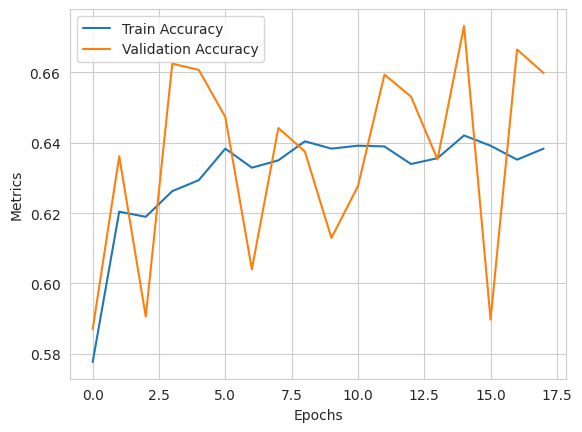

Test accuracy: 0.6489583253860474 0.6227352023124695
0.01
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_194 (Dense)           (None, 64)                832       
                                                                 
 dense_195 (Dense)           (None, 32)                2080      
                                                                 
 dense_196 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2945 (11.50 KB)
Trainable params: 2945 (11.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model summary : None
Epoch 1/1000
150/150 [==============================] - 2s 6ms/step - loss: 0.8212 - accuracy: 0.5490 - val_loss: 0.6804 - val_accuracy: 0.5371
Epoch 2/1000
150/150 [==============================] - 1s 4

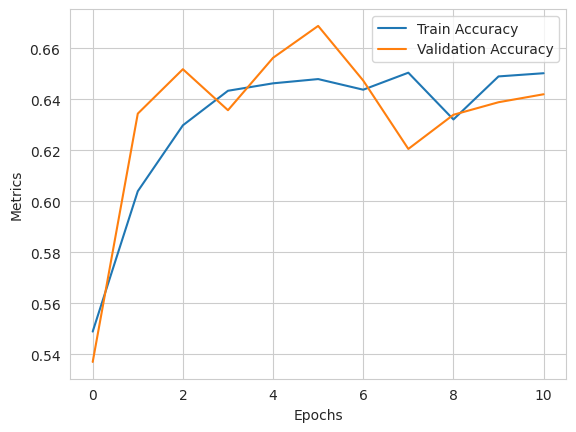

Test accuracy: 0.6604166626930237 0.6072221994400024
0.1
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_197 (Dense)           (None, 64)                832       
                                                                 
 dense_198 (Dense)           (None, 32)                2080      
                                                                 
 dense_199 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2945 (11.50 KB)
Trainable params: 2945 (11.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model summary : None
Epoch 1/1000
150/150 [==============================] - 2s 5ms/step - loss: 1.1351 - accuracy: 0.4954 - val_loss: 0.6973 - val_accuracy: 0.4862
Epoch 2/1000
150/150 [==============================] - 1s 4m

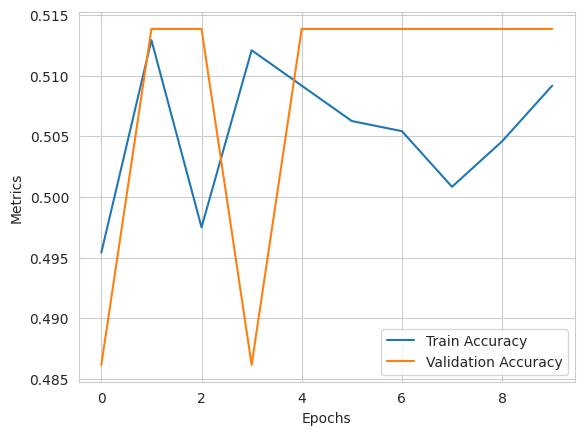

Test accuracy: 0.5135416388511658 0.6928712725639343


In [562]:

# Define a list of learning rates to try
learning_rates = [0.001, 0.01, 0.1]

# Train and evaluate the model for different learning rates
results = {}
for lr in learning_rates:
    print(lr)
    history, accuracy , loss,lr_model  = train_and_evaluate_model(lr , (X_train,y_train) , (X_test,y_test), (X_val,y_val) , X_train.shape[1])
    results[lr] = {'acc':accuracy, 'model':lr_model}
    
    print(f'Accuracy in the loop : {accuracy}')
    
    plot_results(history, loss, accuracy)

In [563]:

# Print the results
print("Results:")
for lr, vals in results.items():
    print(f'Learning Rate {lr}: Test Accuracy {vals["acc"]}')
    
highest_accuracy = max([vals["acc"] for vals in results.values()])
highest_accuracy_lr = [lr for lr, vals in results.items() if vals["acc"] == highest_accuracy][0]

print(f'Highest baseline Accuracy: {highest_accuracy} (Learning Rate {highest_accuracy_lr})')

Results:
Learning Rate 0.001: Test Accuracy 0.6489583253860474
Learning Rate 0.01: Test Accuracy 0.6604166626930237
Learning Rate 0.1: Test Accuracy 0.5135416388511658
Highest baseline Accuracy: 0.6604166626930237 (Learning Rate 0.01)


### Error analysis

In [564]:
highest_accuracy


0.6604166626930237

In [565]:
results

{0.001: {'acc': 0.6489583253860474,
  'model': <keras.src.engine.sequential.Sequential at 0x7f2371301c30>},
 0.01: {'acc': 0.6604166626930237,
  'model': <keras.src.engine.sequential.Sequential at 0x7f2386f23e80>},
 0.1: {'acc': 0.5135416388511658,
  'model': <keras.src.engine.sequential.Sequential at 0x7f238c323970>}}

In [566]:
for lr,val in results.items():
    ### perform error analysis

    ## Luka print this erorr analysis cases, plot them, analyze them etc.
    print(f'Error Analysis for  the model with {lr} learning rate and accuracy on {val["acc"]} % level:')

    error_analysis(val['model'] ,  X_test, y_test )

Error Analysis for  the model with 0.001 learning rate and accuracy on 0.6489583253860474 % level:
30/30 [==============================] - 0s 968us/step


duration_seconds  latitude  longitude  speed_kmh  end_speed_kmh  \
0          -0.816308  51.60977   4.784027   1.171049      -0.589456   
1          -0.731636  51.60282   4.728459  -1.100794      -0.839757   
2          -0.795140  51.60285   4.739188  -0.764069      -0.422589   
3          -0.604627  51.61621   4.772312  -0.764069      -0.672890   
4          -0.731636  51.60143   4.800694  -0.595707      -0.839757   
6           2.126060  51.58826   4.741914   1.086868       1.078177   
7          -0.689300  51.57645   4.793610  -0.595707      -0.672890   
9          -0.985653  51.60622   4.790169  -1.689538      -2.007307   
12          2.337741  51.57214   4.765614   1.086868       1.328478   
14         -0.710468  51.57897   4.727945  -0.427345      -0.589456   

    maxwaarde  last_hour_wind_avg  last_hour_temp_avg  last_hour_rain_avg  \
0   -0.768045           -0.438610           -0.890655           -0.234421   
1   -0.775861           -0.009811            0.074168           -0.234421   
2   -0.773360           -0.248899           -1.610672           -0.234421   
3   -0.774923           -1.423547           -0.334802           -0.234421   
4   -0.774298           -0.009811           -0.824413           -0.234421   
6    1.214675           -0.217713           -1.547311           -0.234421   
7   -0.774923           -0.682895            0.039607           -0.045630   
9   -0.771797            0.647680            1.110993            0.439833   
12   1.315343           -0.623123           -0.968417           -0.234421   
14  -0.773360            0.216283            0.174971            0.763475   

    category_braking  category_harsh cornering  category_speed  y_test  y_pred  
0                1.0                       0.0             0.0       0       1  
1                0.0                       1.0             0.0       1       0  
2                0.0                       1.0             0.0       0       1  
3                0.0                       1.0             0.0       1       0  
4                0.0                       1.0             0.0       1       0  
6                0.0                       0.0             1.0       1       0  
7                0.0                       1.0             0.0       0       1  
9                1.0                       0.0             0.0       1       0  
12               0.0                       0.0             1.0       1       0  
14               0.0                       1.0             0.0       0       1

--------------------------------------------------------------------------------
Error Analysis for  the model with 0.01 learning rate and accuracy on 0.6604166626930237 % level:
30/30 [==============================] - 0s 1ms/step


duration_seconds  latitude  longitude  speed_kmh  end_speed_kmh  \
0          -0.816308  51.60977   4.784027   1.171049      -0.589456   
1          -0.731636  51.60282   4.728459  -1.100794      -0.839757   
2          -0.795140  51.60285   4.739188  -0.764069      -0.422589   
6           2.126060  51.58826   4.741914   1.086868       1.078177   
7          -0.689300  51.57645   4.793610  -0.595707      -0.672890   
9          -0.985653  51.60622   4.790169  -1.689538      -2.007307   
14         -0.710468  51.57897   4.727945  -0.427345      -0.589456   
18          0.855973  51.58140   4.829270   1.086868       1.078177   
20         -0.752804  51.60659   4.752456   0.077218      -0.589456   
27         -0.668131  51.56646   4.780797   0.077218      -0.589456   

    maxwaarde  last_hour_wind_avg  last_hour_temp_avg  last_hour_rain_avg  \
0   -0.768045           -0.438610           -0.890655           -0.234421   
1   -0.775861           -0.009811            0.074168           -0.234421   
2   -0.773360           -0.248899           -1.610672           -0.234421   
6    1.214675           -0.217713           -1.547311           -0.234421   
7   -0.774923           -0.682895            0.039607           -0.045630   
9   -0.771797            0.647680            1.110993            0.439833   
14  -0.773360            0.216283            0.174971            0.763475   
18   1.315343           -0.222911            1.260757           -0.234421   
20  -0.774298           -0.248899           -1.610672           -0.234421   
27  -0.770234            0.013578           -1.054819           -0.234421   

    category_braking  category_harsh cornering  category_speed  y_test  y_pred  
0                1.0                       0.0             0.0       0       1  
1                0.0                       1.0             0.0       1       0  
2                0.0                       1.0             0.0       0       1  
6                0.0                       0.0             1.0       1       0  
7                0.0                       1.0             0.0       0       1  
9                1.0                       0.0             0.0       1       0  
14               0.0                       1.0             0.0       0       1  
18               0.0                       0.0             1.0       0       1  
20               0.0                       1.0             0.0       0       1  
27               0.0                       1.0             0.0       0       1

--------------------------------------------------------------------------------
Error Analysis for  the model with 0.1 learning rate and accuracy on 0.5135416388511658 % level:
30/30 [==============================] - 0s 1ms/step


duration_seconds  latitude  longitude  speed_kmh  end_speed_kmh  \
1          -0.731636  51.60282   4.728459  -1.100794      -0.839757   
3          -0.604627  51.61621   4.772312  -0.764069      -0.672890   
4          -0.731636  51.60143   4.800694  -0.595707      -0.839757   
5          -0.604627  51.58181   4.826647  -0.679888      -0.589456   
6           2.126060  51.58826   4.741914   1.086868       1.078177   
9          -0.985653  51.60622   4.790169  -1.689538      -2.007307   
11         -0.816308  51.56507   4.737915  -0.764069      -0.672890   
12          2.337741  51.57214   4.765614   1.086868       1.328478   
16          1.067654  51.59828   4.820588   2.097041       2.079379   
17          1.702698  51.57220   4.765385   1.086868       1.078177   

    maxwaarde  last_hour_wind_avg  last_hour_temp_avg  last_hour_rain_avg  \
1   -0.775861           -0.009811            0.074168           -0.234421   
3   -0.774923           -1.423547           -0.334802           -0.234421   
4   -0.774298           -0.009811           -0.824413           -0.234421   
5   -0.773360           -0.630919            0.313214           -0.234421   
6    1.214675           -0.217713           -1.547311           -0.234421   
9   -0.771797            0.647680            1.110993            0.439833   
11  -0.776486            1.523469            1.764769           -0.234421   
12   1.315343           -0.623123           -0.968417           -0.234421   
16   1.818682           -0.381437           -2.258688           -0.234421   
17   1.315343           -0.443807           -0.199438           -0.234421   

    category_braking  category_harsh cornering  category_speed  y_test  y_pred  
1                0.0                       1.0             0.0       1       0  
3                0.0                       1.0             0.0       1       0  
4                0.0                       1.0             0.0       1       0  
5                0.0                       1.0             0.0       1       0  
6                0.0                       0.0             1.0       1       0  
9                1.0                       0.0             0.0       1       0  
11               0.0                       1.0             0.0       1       0  
12               0.0                       0.0             1.0       1       0  
16               0.0                       0.0             1.0       1       0  
17               0.0                       0.0             1.0       1       0

--------------------------------------------------------------------------------


### RandomForestClassifier with coordinates and road_name

In [ ]:
X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum"]
X = safe_driving_with_accidents_df.drop(columns=X_droplist)
y = safe_driving_with_accidents_df["y_var"]

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create a column transformer with imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Create a pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100))
])

# Train the model
model_pipeline.fit(X_train, y_train)

In [ ]:
from sklearn.model_selection import cross_val_score

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

### XGBClassifier with coordinates, without road_name

In [ ]:
X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum", "road_name"]
X = safe_driving_with_accidents_df.drop(columns=X_droplist)
y = safe_driving_with_accidents_df["y_var"]

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create a column transformer with imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Create a pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Train the model
model_pipeline.fit(X_train, y_train)

In [ ]:
from sklearn.model_selection import cross_val_score

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model_pipeline, X, y_encoded, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model_pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model and best parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

### XGBClassifier, with extracted data from event_start

In [ ]:
# Extract year, month, day, and hour from 'event_start'
safe_driving_with_accidents_df['event_start'] = pd.to_datetime(safe_driving_with_accidents_df['event_start'])
safe_driving_with_accidents_df['year'] = safe_driving_with_accidents_df['event_start'].dt.year
safe_driving_with_accidents_df['month'] = safe_driving_with_accidents_df['event_start'].dt.month
safe_driving_with_accidents_df['day'] = safe_driving_with_accidents_df['event_start'].dt.day
safe_driving_with_accidents_df['hour'] = safe_driving_with_accidents_df['event_start'].dt.hour

# Drop columns that are not used
X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum", "road_name", "latitude", "longitude"]
X = safe_driving_with_accidents_df.drop(columns=X_droplist)
y = safe_driving_with_accidents_df["y_var"]

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create a column transformer with imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Create a pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model_pipeline, X, y_encoded, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters and best score
print("Best parameters:", best_params)
print("Best cross-validation score:", grid_search.best_score_)

# Predict on the test set with the best model
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Model with Dominic's code

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Transformer for target variable encoding
class TargetVariableTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, target_variable, is_regression):
        self.target_variable = target_variable
        self.is_regression = is_regression
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.is_regression:
            return X
        else:
            X[self.target_variable] = X[self.target_variable].astype('category').cat.codes
            return X

# Pipeline to transform the target variable
def target_variable_pipeline(target_variable, is_regression):
    gen_ppl = Pipeline(steps=[
        ('transform_target', TargetVariableTransformer(target_variable=target_variable, is_regression=is_regression))
    ])
    return gen_ppl

# Function to provide the full preprocessing and model pipeline
def provide_full_pipeline(model_obj, num_features, cat_features, target_variable, df):
    # Create column transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), num_features),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), cat_features)
        ])

    # Combine preprocessing and model into a single pipeline
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model_obj)
    ])
    
    return model, df, {'num_features': num_features, 'cat_features': cat_features, 'target_variable': target_variable}

# Decorator function for model training and evaluation
def model_training(func):
    def wrapper(df, num_features, cat_features, target_variable, model_obj, is_regression=True, *args):
        # Create full pipeline and preprocess the data
        model, new_df, model_properties = provide_full_pipeline(model_obj, num_features=num_features,
                                                                cat_features=cat_features,
                                                                target_variable=target_variable, df=df)
 
        new_df = target_variable_pipeline(target_variable, is_regression).fit_transform(new_df)
 
        # Split the data into features (X) and target (y)
        X = new_df.drop(target_variable, axis=1)
        y = new_df[target_variable]
 
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
        # Train the model
        model.fit(X_train, y_train)
 
        # Call the evaluation function
        res = func(model, X_test, y_test, model_properties, *args)
 
        # Print evaluation metrics
        if is_regression:
            r2_score = model.score(X_test, y_test)
            rmse = (mean_squared_error(y_test, model.predict(X_test)) ** (1 / 2))
            mae = mean_absolute_error(y_test, model.predict(X_test))
 
            print(f'R2 score: {r2_score}')
            print('MSE: ', rmse ** 2)
            print(f'RMSE: {rmse}')
            print(f'MAE: {mae}')
        else:
            score = model.score(X_test, y_test)
            print('Score', score)
 
            y_pred = model.predict(X_test)
            print(classification_report(y_test, y_pred))
 
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d')
            plt.show()
 
        return res
 
    return wrapper

In [ ]:
import pandas as pd

# Assuming safe_driving_with_accidents_df is your dataframe
df = safe_driving_with_accidents_df.copy()

# Define numerical and categorical features
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
cat_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Remove target and other columns from features
X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum"]
num_features = [feature for feature in num_features if feature not in X_droplist]
cat_features = [feature for feature in cat_features if feature not in X_droplist]

# Define target variable
target_variable = "y_var"

# Define model
model_obj = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Evaluation function decorated with model_training
@model_training
def evaluate_model(model, X_test, y_test, model_properties, *args):
    return model.score(X_test, y_test)

# Manually set hyperparameters (similar to a simplified grid search)
model_obj.set_params(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8)

# Run model training and evaluation
result = evaluate_model(df, num_features, cat_features, target_variable, model_obj, is_regression=False)

### XGBClassifier, without coordinates

In [ ]:
X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum", "road_name", "latitude", "longitude"]
X = safe_driving_with_accidents_df.drop(columns=X_droplist)
y = safe_driving_with_accidents_df["y_var"]

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create a column transformer with imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Create a pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Train the model
model_pipeline.fit(X_train, y_train)

In [ ]:
from sklearn.model_selection import cross_val_score

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model_pipeline, X, y_encoded, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model_pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model and best parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

### Now with Dominic's code, also without coordinates

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Transformer for target variable encoding
class TargetVariableTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, target_variable, is_regression):
        self.target_variable = target_variable
        self.is_regression = is_regression
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.is_regression:
            return X
        else:
            X[self.target_variable] = X[self.target_variable].astype('category').cat.codes
            return X

# Pipeline to transform the target variable
def target_variable_pipeline(target_variable, is_regression):
    gen_ppl = Pipeline(steps=[
        ('transform_target', TargetVariableTransformer(target_variable=target_variable, is_regression=is_regression))
    ])
    return gen_ppl

# Function to provide the full preprocessing and model pipeline
def provide_full_pipeline(model_obj, num_features, cat_features, target_variable, df):
    # Create column transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), num_features),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), cat_features)
        ])

    # Combine preprocessing and model into a single pipeline
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model_obj)
    ])
    
    return model, df, {'num_features': num_features, 'cat_features': cat_features, 'target_variable': target_variable}

# Decorator function for model training and evaluation
def model_training(func):
    def wrapper(df, num_features, cat_features, target_variable, model_obj, is_regression=True, *args):
        # Create full pipeline and preprocess the data
        model, new_df, model_properties = provide_full_pipeline(model_obj, num_features=num_features,
                                                                cat_features=cat_features,
                                                                target_variable=target_variable, df=df)
 
        new_df = target_variable_pipeline(target_variable, is_regression).fit_transform(new_df)
 
        # Split the data into features (X) and target (y)
        X = new_df.drop(target_variable, axis=1)
        y = new_df[target_variable]
 
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
        # Train the model
        model.fit(X_train, y_train)
 
        # Call the evaluation function
        res = func(model, X_test, y_test, model_properties, *args)
 
        # Print evaluation metrics
        if is_regression:
            r2_score = model.score(X_test, y_test)
            rmse = (mean_squared_error(y_test, model.predict(X_test)) ** (1 / 2))
            mae = mean_absolute_error(y_test, model.predict(X_test))
 
            print(f'R2 score: {r2_score}')
            print('MSE: ', rmse ** 2)
            print(f'RMSE: {rmse}')
            print(f'MAE: {mae}')
        else:
            score = model.score(X_test, y_test)
            print('Score', score)
 
            y_pred = model.predict(X_test)
            print(classification_report(y_test, y_pred))
 
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d')
            plt.show()
 
        return res
 
    return wrapper

In [ ]:
import pandas as pd

# Assuming safe_driving_with_accidents_df is your dataframe
df = safe_driving_with_accidents_df.copy()

# Define numerical and categorical features
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
cat_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Remove target and other columns from features
X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum", "road_name", "latitude", "longitude"]
num_features = [feature for feature in num_features if feature not in X_droplist]
cat_features = [feature for feature in cat_features if feature not in X_droplist]

# Define target variable
target_variable = "y_var"

# Define model
model_obj = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Evaluation function decorated with model_training
@model_training
def evaluate_model(model, X_test, y_test, model_properties, *args):
    return model.score(X_test, y_test)

# Manually set hyperparameters (similar to a simplified grid search)
model_obj.set_params(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8)

# Run model training and evaluation
result = evaluate_model(df, num_features, cat_features, target_variable, model_obj, is_regression=False)

### RandomForestClassifier with extracted data from event_start

In [ ]:
# Extract year, month, day, and hour from 'event_start'
safe_driving_with_accidents_df['event_start'] = pd.to_datetime(safe_driving_with_accidents_df['event_start'])
safe_driving_with_accidents_df['year'] = safe_driving_with_accidents_df['event_start'].dt.year
safe_driving_with_accidents_df['month'] = safe_driving_with_accidents_df['event_start'].dt.month
safe_driving_with_accidents_df['day'] = safe_driving_with_accidents_df['event_start'].dt.day
safe_driving_with_accidents_df['hour'] = safe_driving_with_accidents_df['event_start'].dt.hour

In [ ]:
X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum", "road_name", "latitude", "longitude"]
X = safe_driving_with_accidents_df.drop(columns=X_droplist)
y = safe_driving_with_accidents_df["y_var"]

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create a column transformer with imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Create a pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100))
])

# Train the model
model_pipeline.fit(X_train, y_train)

In [ ]:
from sklearn.model_selection import cross_val_score

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters and best score
print("Best parameters:", best_params)
print("Best cross-validation score:", grid_search.best_score_)

# Predict on the test set with the best model
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))